# HEEL # K20 4rd p30/50 PCA1/1 Crop.7 Affine.7 + Heel HPLv2 

## annotation_1405_HPLv2Heel_Good.csv

# 20210302-151802

# 101 Course of transfer learning and Fine tune 2021-01-01

## [How-to] 1. k-fold for cross validation

#### Create a simple k-fold for train classification model.

* In this short course you learned:

* data pipline

* transfer learning

* fine tune

* callbacks


todo: move to note.py


In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# plt.style.use("bmh")

import cv2
import tensorflow as tf

from datetime import datetime
import seaborn as sns

import errno

# albumentations
from functools import partial
# from albumentations import (
#     Compose, RandomBrightness, JpegCompression, HueSaturationValue, RandomContrast, HorizontalFlip,
#     Rotate
# )
import albumentations as A

# from adabelief_tf import AdaBeliefOptimizer

In [2]:
print(tf.__version__)
print(cv2.__version__)

2.3.1
4.3.0


In [3]:
from pytictoc import TicToc

t_timer = TicToc() #create instance of class

t_timer.tic() #Start timer

### 2. Parameters

#### Image size, Batch size, toe/heel-offset.

In [4]:
BATCH_SIZE = 64 # 16 #32 #64 #128 #32 #64 #todo: reduce the BS maybe help to reduce the loss
img_height = 120 #512 #224 #100
img_width = 120 #512 #224 #100

y_offset_toe = 80
y_offset_heel = 280 #400-120=280

#### tf MirroredStrategy seting

In [5]:

# tf MirroredStrategy seting
strategy = tf.distribute.MirroredStrategy()
REPLICAS = strategy.num_replicas_in_sync
print('\nNumber of REPLICAS: {}\n'.format(REPLICAS))


MULTI_BATCH_SIZE = BATCH_SIZE * strategy.num_replicas_in_sync
print('BATCH_SIZE: {}, MULTI_BATCH_SIZE: {}'.format(BATCH_SIZE, MULTI_BATCH_SIZE))



INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)

Number of REPLICAS: 1

BATCH_SIZE: 64, MULTI_BATCH_SIZE: 64


In [6]:
# 自動調節tf.data管道
AUTOTUNE = tf.data.experimental.AUTOTUNE

### 3. Create the training dataset W/ croped


#### Load samples as data-farame

In [7]:

# # data-org #
# ann = 'annotation_1424_merge.csv'
# im_p = 'train/images/'
# CSVNAME = ""


# # data-org-augm#
# ann = 'annotation_2848_augm.csv'
# im_p = 'train_augm/images/'
# CSVNAME = ""


# # data-train # # current best dataset.1424-79.
# ann = 'annotation_1345_good.csv'
# im_p = 'train/images/'
# CSVNAME = "K1345K10L195"

# data-augm #
# ann = 'annotation_2690_augm.csv'
# im_p = 'train_augm/images/'
# CSVNAME = ""


# # data-train-HPL-1123
# ann = 'annotation_1123_HPL_Good.csv'
# im_p = 'train/images/'
# CSVNAME = ""

# data-train # # HPLv2Toe
ann = 'annotation_1405_HPLv2Heel_Good.csv'
im_p = 'train/images/'
CSVNAME = "HPLv2heelK10L195"


df = pd.read_csv(ann)
df[1120:]

images  x1   y1  x2   y2
1120  image_6139.png  49  138  74  384
1121  image_6140.png  64  140  34  371
1122  image_6141.png  48  138  69  385
1123  image_6142.png  60  140  30  370
1124  image_6143.png  60  123  71  384
...              ...  ..  ...  ..  ...
1400  image_6420.jpg  63  158  46  381
1401  image_6421.jpg  53  157  76  376
1402  image_6422.jpg  49  154  33  375
1403  image_6423.jpg  64  149  76  381
1404  image_6424.jpg  55  147  36  385

[285 rows x 5 columns]

In [8]:
len(df)

1405

#### Shuffle and reset index

In [9]:
# reset index
df = df.sample(frac=1).reset_index(drop=True)

In [10]:
df.head(10)

images  x1   y1  x2   y2
0  image_0275.png  58  136  73  381
1  image_0919.png  61  125  35  384
2  image_0138.png  67  102  33  384
3  image_6388.jpg  60  136  30  383
4  image_0362.png  58  168  30  374
5  image_6273.jpg  53  140  69  351
6  image_6309.jpg  52  153  73  383
7  image_0088.png  64  116  39  364
8  image_6018.png  58  102  34  381
9  image_0671.png  58  148  32  384

See, the image_####.jpg now are random.

#### Create tf.dataset (DS)

In [11]:
# from dataframe
list_ds = tf.data.Dataset.from_tensor_slices((df['images'], df['x1'], df['y1'], df['x2'], df['y2']))
# list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=True) #todo: move to ds_pre. see https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle

In [12]:
len(list_ds)#.shape() #take(1)

1405

In [13]:
# check The type specification of an element of this dataset.
list_ds.element_spec


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [14]:
for f,x1,y1,x2,y2 in list_ds.take(5):
    print(f'take sample: {f} {x1} {y1} {x2} {y2}')

take sample: b'image_0275.png' 58 136 73 381
take sample: b'image_0919.png' 61 125 35 384
take sample: b'image_0138.png' 67 102 33 384
take sample: b'image_6388.jpg' 60 136 30 383
take sample: b'image_0362.png' 58 168 30 374


In [15]:
# use np decode to UTF-8
print(f.numpy().decode('UTF-8'))

image_0362.png


In [16]:
len(list_ds)

1405

#### Check ds iterator for consuming

In [17]:
# create a Python iterator

it_list_ds = iter(list_ds) # Make sure iter ds only once.

In [18]:
# using iter and consuming its elements using next: every print different image name.

for i in range(4):
    image, x1, y1, x2, y2 = next(it_list_ds)
    print(image.numpy(), x1.numpy(), y1.numpy())

b'image_0275.png' 58 136
b'image_0919.png' 61 125
b'image_0138.png' 67 102
b'image_6388.jpg' 60 136


In [19]:
# image_batch, label_batch = valid_ds_pre_s.as_numpy_iterator().next()
# pred = model.predict_on_batch(image_batch)


for i in range(4):
    image, x1, y1, x2, y2 = list_ds.as_numpy_iterator().next()# every time create a new iter, so need put iter out of above cell.
    print(image, x1, y1, x2, y2)
    
iter_test_list = list_ds.as_numpy_iterator()
print("===== Create iterator once and pull out to above cell. =====")
for i in range(4):
    image, x1, y1, x2, y2 = iter_test_list.next()
    print(image, x1, y1, x2, y2)


b'image_0275.png' 58 136 73 381
b'image_0275.png' 58 136 73 381
b'image_0275.png' 58 136 73 381
b'image_0275.png' 58 136 73 381
===== Create iterator once and pull out to above cell. =====
b'image_0275.png' 58 136 73 381
b'image_0919.png' 61 125 35 384
b'image_0138.png' 67 102 33 384
b'image_6388.jpg' 60 136 30 383


#### Process path to image tensor in DS

In [20]:

'''
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    boolen = parts[-2] == class_names
    #one_hot_num = np.array(boolen, dtype=np.int) not works should use tf.x repalced.
    one_hot_num = tf.dtypes.cast(boolen, tf.int64)
    one_num = tf.argmax(one_hot_num)
    print('one_num:', one_num)
    # Integer encode the label
    return one_num

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # resize the image to the desired size
#     return tf.image.resize(img, [img_height, img_width])# augment 已經resize過一次了 但這邊不先做會比較慢
    return tf.cast(tf.image.resize(img, [img_height, img_width]), tf.uint8)# 避免float over at augment
'''

#
# map list to ds, Toe part.
#

def decode_crop_png_toe(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_png(img, channels=3)
    # crop the toe from top-left corner [image, offset_height y1, offset_width x1, target_height, target_width]
    y1=y_offset_toe;    x1=0;    h=img_height;    w=img_width # not the pp location
    img = tf.image.crop_to_bounding_box(img, int(y1), int(x1), h, w)
    #img = tf.image.crop_to_bounding_box(img, int(y1), int(x1), int(y2)-int(y1), int(x2)-int(x1))
    # resize the image to the desired size
    return img

def process_path_toe(file_path,x1,y1,x2,y2):
    file_path = im_p + file_path
    #label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)#can read the byte string paths b'image_0001.png'
    img = decode_crop_png_toe(img)
    return img, [x1,y1-y_offset_toe]#Original [0,120]
    #return img, x1, y1-y_offset_toe #Original [0,120] #貌似ed不用改，蛋mse變超大
    #return img, [x1/120,(y1-y_offset_toe)/120]#normalized [0,1] xy <dtype: 'float64'>, no help.
    #return img, [(x1-60)/60,((y1-y_offset_toe)-60)/60]#normalized [-1,1] , no help.

#
# map list to ds, Heel part.
#

def decode_crop_png_heel(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_png(img, channels=3)
    # crop the toe from top-left corner [image, offset_height y1, offset_width x1, target_height, target_width]
    y2=y_offset_heel;    x2=0;    h=img_height;    w=img_width # not the pp location
    img = tf.image.crop_to_bounding_box(img, int(y2), int(x2), h, w)
    #img = tf.image.crop_to_bounding_box(img, int(y1), int(x1), int(y2)-int(y1), int(x2)-int(x1))
    # resize the image to the desired size
    return img

def process_path_heel(file_path,x1,y1,x2,y2):
    file_path = im_p + file_path
    #label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)#can read the byte string paths b'image_0001.png'
    img = decode_crop_png_heel(img)
    return img, [x2,y2-y_offset_heel]#Original [0,120]
    #return img, x2, y2-y_offset_heel #Original [0,120] #貌似ed不用改，蛋mse變超大
    #return img, [x2/120,(y2-y_offset_heel)/120]#normalized [0,1] xy <dtype: 'float64'>, no help.
    #return img, [(x2-60)/60,((y2-y_offset_heel)-60)/60]#normalized [-1,1] , no help.

#
# test how to put parameters to map
#

def t_ds_map(file_path,x1,y1,x2,y2):
#     img = get_img('train/images/' + str(file_path))
#     print(file_path)
    return file_path,x1,y1,x2,y2 #img, [x1,y1]
    

In [21]:
# Toe ds
train_ds_map_toe = list_ds.map(process_path_toe, num_parallel_calls=AUTOTUNE)

# Heel ds
train_ds_map_heel = list_ds.map(process_path_heel, num_parallel_calls=AUTOTUNE)

In [22]:
# for img, xy in train_ds_map_toe.take(1):
#     print(f'take sample: {xy}')
    
# print('f', f.dtype)
# print('xy', xy.dtype)

# for img, x, y in train_ds_map_toe.take(1):
#     print(f'take sample: {x} {y}')
    
# print('img', img.dtype)
# print('x', x.dtype)
# x

for img, [x, y] in train_ds_map_toe.take(1):
    print(f'take sample: {x} {y}')
    
print('f', f.dtype)
print('x', x.dtype)

take sample: 58 56
f <dtype: 'string'>
x <dtype: 'int64'>


In [23]:
x

<tf.Tensor: shape=(), dtype=int64, numpy=58>

In [24]:
# for f,x1,y1,x2,y2 in train_ds_map.take(5):
#     print(f'take sample: {f} {x1} {y1} {x2} {y2}')

#### [new] Split train_ds_pre with ratio of validation %

[ToDo 20210201] keep orignal validation in 0.1, but augmenting train_ds in input layer or in the tf.ds.

[2021-02-23] New k-split ds

In [25]:
# # split Toe
# val_size = int(tf.data.experimental.cardinality(train_ds_map_toe).numpy() * 0.2)
# # val_size = int(tf.data.experimental.cardinality(train_ds_map_toe).numpy() * 0.1)#no help

# train_ds_map_toe_s = train_ds_map_toe.skip(val_size)
# valid_ds_map_toe_s = train_ds_map_toe.take(val_size)

# print(f'whole samples = {len(train_ds_map_toe)}')
# print(f'val_size = {val_size}')

# print('ds_train = ', tf.data.experimental.cardinality(train_ds_map_toe_s).numpy())
# print('ds_valid = ', tf.data.experimental.cardinality(valid_ds_map_toe_s).numpy())

In [26]:
# # split Heel
# val_size = int(tf.data.experimental.cardinality(train_ds_map_heel).numpy() * 0.2)
# # val_size = int(tf.data.experimental.cardinality(train_ds_map_heel).numpy() * 0.1)


# train_ds_map_heel_s = train_ds_map_heel.skip(val_size)
# valid_ds_map_heel_s = train_ds_map_heel.take(val_size)

# print(len(train_ds_map_heel))
# print(val_size)
# print(tf.data.experimental.cardinality(train_ds_map_heel_s).numpy())
# print(tf.data.experimental.cardinality(valid_ds_map_heel_s).numpy())

In [27]:
# ## testing cell
# kf = []
# for k in range(5):
#     kf.append(train_ds_map_heel.shard(num_shards=5, index=k))
#     print("k =", k,"num=", tf.data.experimental.cardinality(kf[k]).numpy())

In [28]:
# kf

In [29]:

# for img, [x,y] in kf[1].take(1):
#     print(f'take sample: {x} {y}')
    
# print('img', img.dtype)
# print('x', x.dtype)
# print('y', y.dtype)

In [30]:
# ## testing cell

# range_k_0 = train_ds_map_heel.window(5)

# print(len(range_k_0))
# print(tf.data.experimental.cardinality(range_k_0).numpy())

In [31]:
# ## testing cell

# def get_train_valid_k_split():
#     x = tf.data.Dataset.range(1000)
#     val_size = int(tf.data.experimental.cardinality(x).numpy() * 0.2)
    
#     for k in range(5):
#         train_num = x.take(val_size + k*val_size)
#         valid_num = x.skip(k*val_size)
        
#         print("k=", k)
#         print(tf.data.experimental.cardinality(train_num).numpy())
#         print(tf.data.experimental.cardinality(valid_num).numpy())
    
    
# get_train_valid_k_split()

In [32]:
## testing cell

# 
# tf.slice
# tf.data.experimental.choose_from_datasets


# x = list_ds
# val_size = int(tf.data.experimental.cardinality(list_ds).numpy() * 0.2)
x = tf.data.Dataset.range(10)

def check_KFold_ds(x, K=5):
    
    val_size = int(tf.data.experimental.cardinality(x).numpy() * 0.2)
    print("val_size=", val_size)
    
    for k in range(K):
#         k_train = x.take(val_size + k*val_size)
#         k_valid = x.skip(k*val_size)
#         k_train = tf.slice(x, k*val_size, val_size) #only for pure tensors not 
#         k_valid = x.skip(k*val_size)

        # may skip twicce to performe kflod
        t_take = x.take(k*val_size)
        t_skip = x.skip(k*val_size+val_size)
        k_train = t_take.concatenate(t_skip)
        
        v_skip = x.skip(k*val_size)
        k_valid = v_skip.take(val_size)

        print("k =", k,"k*val_size+val_size", k*val_size+val_size, "k_train num=", tf.data.experimental.cardinality(k_train).numpy())


        # x = tf.data.Dataset.range(10)
#         for n in k_train:
#             print(n.numpy())
#         for n in k_valid:
#             print(n.numpy())
        
        # list_ds
#         for img, x1, y1, x2, y2 in k_train:
#             print(x1, y1)

        # train_ds_map_toe
#         for img, (x, y) in k_train:
#             print(x.numpy(), y.numpy())

    
    
    
check_KFold_ds(x)
# check_KFold_ds(list_ds)    
# check_KFold_ds(train_ds_map_toe)

val_size= 2
k = 0 k*val_size+val_size 2 k_train num= 8
k = 1 k*val_size+val_size 4 k_train num= 8
k = 2 k*val_size+val_size 6 k_train num= 8
k = 3 k*val_size+val_size 8 k_train num= 8
k = 4 k*val_size+val_size 10 k_train num= 8


In [33]:
# x = tf.data.Dataset.range(10)
# val_size = int(tf.data.experimental.cardinality(x).numpy() * 0.2)
# print("val_size=", val_size)

def get_KFold_ds(x, K=0):
        
    k = K
    # may skip twicce to perform kflod
    # train ds
    t_take = x.take(k*val_size)
    t_skip = x.skip(k*val_size+val_size)
    k_train = t_take.concatenate(t_skip)
    # val ds
    v_skip = x.skip(k*val_size)
    k_valid = v_skip.take(val_size)

    return k_train, k_valid

In [34]:
# val_size = int(tf.data.experimental.cardinality(train_ds_map_toe).numpy() * 0.2)
val_size = int(tf.data.experimental.cardinality(train_ds_map_toe).numpy() * 0.05)
t, v = get_KFold_ds(train_ds_map_toe, 1)

print(tf.data.experimental.cardinality(t).numpy())
print(tf.data.experimental.cardinality(v).numpy())

# for n in v:
#     print(n.numpy())

1335
70


In [35]:
train_ds_map_toe

<ParallelMapDataset shapes: ((120, 120, 3), (2,)), types: (tf.uint8, tf.int64)>

In [36]:
v

<TakeDataset shapes: ((120, 120, 3), (2,)), types: (tf.uint8, tf.int64)>

# Albumentation pipeline

In [37]:

# # for NO keypoint augment
# transforms = A.Compose([
# #             A.RandomBrightness(limit=0.1, p=0.5),
#             A.JpegCompression(quality_lower=65, quality_upper=100, p=0.5),#A.JpegCompression(quality_lower=85, quality_upper=100, p=0.5)
#             A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
# #             A.RandomContrast(limit=0.2, p=0.5),
#             A.FancyPCA(alpha=0.1, always_apply=False, p=1),#A.FancyPCA(alpha=0.1, always_apply=False, p=0.5)
#             A.Downscale(scale_min=0.7, scale_max=0.9, interpolation=0, always_apply=False, p=0.5), #0.8~0.99 may better
#             A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.5),
#             A.CLAHE(clip_limit=(1, 8), tile_grid_size=(8, 8), always_apply=False, p=0.5), #A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5)
# #             A.GlassBlur(sigma=0.9, max_delta=2, iterations=2, always_apply=False, mode='fast', p=0.5),
# #             A.GaussNoise(var_limit=(10.0, 50.0), mean=0, always_apply=False, p=0.5),
# #             A.GaussianBlur(blur_limit=(3, 7), sigma_limit=0, always_apply=False, p=0.5),
# #             A.HorizontalFlip(),
    
#             # try other augm, seems to strong...
#             A.RandomBrightnessContrast(always_apply=False, p=0.5, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), brightness_by_max=True),
#             A.Equalize(always_apply=False, p=0.5, mode='cv', by_channels=True),
#             A.MultiplicativeNoise(always_apply=False, p=0.5, multiplier=(0.8, 1.5), per_channel=False, elementwise=False),
#             A.RandomFog(always_apply=False, p=0.5, fog_coef_lower=0.2, fog_coef_upper=0.3, alpha_coef=0.25),

# ])


# def aug_fn(image, img_size):
#     data = {"image":image}
#     aug_data = transforms(**data)
#     aug_img = aug_data["image"]
# #     aug_img = tf.cast(aug_img/255.0, tf.float32)
#     aug_img = tf.cast(aug_img, tf.float32)
#     aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
#     return aug_img

# def process_data(image, label, img_size):
#     aug_img = tf.numpy_function(func=aug_fn, inp=[image, img_size], Tout=tf.float32)
#     return aug_img, label

# def set_shapes(img, label, img_shape=(120,120,3)):
#     img.set_shape(img_shape)
# #     label.set_shape([]) # commited for go around error
#     return img, label





# # for NO keypoint augment AND for OneOf[] for better heel loss.
# transforms_oneof = A.Compose(A.OneOf([
#             A.RandomBrightness(limit=0.1, p=0.5),
#             A.JpegCompression(quality_lower=85, quality_upper=100, p=0.5),
#             A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
#             A.RandomContrast(limit=0.2, p=0.5),
#             A.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
#             A.Downscale(scale_min=0.7, scale_max=0.9, interpolation=0, always_apply=False, p=0.5),
#             A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.5),
#             A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5),
#             A.GlassBlur(sigma=0.9, max_delta=2, iterations=2, always_apply=False, mode='fast', p=0.5),
#             A.GaussNoise(var_limit=(10.0, 50.0), mean=0, always_apply=False, p=0.5),
#             A.GaussianBlur(blur_limit=(3, 7), sigma_limit=0, always_apply=False, p=.5)
# #             A.HorizontalFlip(),
#             ]),p=0.5)


# def aug_fn_oneof(image, img_size):
#     data = {"image":image}
#     aug_data = transforms_oneof(**data)
#     aug_img = aug_data["image"]
# #     aug_img = tf.cast(aug_img/255.0, tf.float32)
#     aug_img = tf.cast(aug_img, tf.float32)
#     aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
#     return aug_img

# def process_data_oneof(image, label, img_size):
#     aug_img = tf.numpy_function(func=aug_fn_oneof, inp=[image, img_size], Tout=tf.float32)
#     return aug_img, label




# # Testing keypoints augment
# transforms = A.Compose([
#             A.RandomBrightness(limit=0.1, p=0.5),
#             A.JpegCompression(quality_lower=85, quality_upper=100, p=0.5),
#             A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
#             A.RandomContrast(limit=0.2, p=0.5),
#             A.FancyPCA (alpha=0.1, always_apply=False, p=1),
#             A.Downscale (scale_min=0.7, scale_max=0.9, interpolation=0, always_apply=False, p=0.5),
#             A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.5),
#             A.CLAHE (clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5),
#             A.HorizontalFlip(p=0.5),
#             ]
#             , 
#             keypoint_params=A.KeypointParams(format='xy'),  #currently not works for tf.ds yet.
#             )





# Testing keypoints augment
transforms = A.Compose([
            A.RandomBrightness(limit=0.1, p=0.5),
            A.JpegCompression(quality_lower=85, quality_upper=100, p=0.5),
            A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
            A.RandomContrast(limit=0.2, p=0.5),
            A.FancyPCA(alpha=0.1, always_apply=False, p=1.0),
            A.Downscale(scale_min=0.7, scale_max=0.9, interpolation=0, always_apply=False, p=0.5),
            A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.5),
            A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5),
    
            A.HorizontalFlip(p=0.5),
            A.RandomResizedCrop(always_apply=False, height=120, width=120, scale=(0.9, 0.99), ratio=(1.0, 1.0), interpolation=0, p=0.7),#xy become double need change dtype of label. # pp will outside the image.
            A.IAAAffine(scale=0.9, translate_percent=None, translate_px=None, rotate=0.0, shear=0.0, order=1, cval=0, mode='reflect', always_apply=False, p=0.7),
#             A.ShiftScaleRotate(always_apply=False, p=0.5, shift_limit=(0.06, 0.06), scale_limit=(-0.1, 0.1), rotate_limit=(-5, 5), interpolation=1, border_mode=2, value=(0, 0, 0), mask_value=None),
    #2021-02-26
#             A.IAAPerspective(scale=(0.05, 0.1), keep_size=True, always_apply=False, p=0.5),#fallout image make train stop. NOT support keypoints!!!!!
            ]
            , 
            keypoint_params=A.KeypointParams(format='xy',remove_invisible=True),  #currently not works for tf.ds yet.
            )

# Testing keypoints augment
# @tf.function
def aug_fn(image, keypoints, img_size):
#     print('Check keypoints aug_fun 00:', keypoints) # Check keypoints aug_fun 00: [[53 58]]
#     data = {"image":image}
    aug_data = transforms(image=image, keypoints=keypoints)
    aug_img = aug_data["image"]
    aug_xy  = aug_data["keypoints"]
#     aug_img = tf.cast(aug_img/255.0, tf.float32)
    aug_img = tf.cast(aug_img, tf.float32)
    aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
    
    aug_xy = tf.cast(aug_xy, tf.float32) #有些變形輸出是double
#     print('Check aug_xy:', aug_xy) # Check aug_xy: [(95, 45)] #印到這邊都是對的
    return aug_img, aug_xy 

# @tf.function
def process_data(image, keypoints, img_size):
    
    print('Check keypoints process01:', keypoints, np.shape(keypoints), type(keypoints))
        
#     keypoints = tf.make_ndarray(keypoints)
#     keypoints = np.array(keypoints)
#     keypoints = list(keypoints)
#     keypoints = np.asarray(keypoints, dtype=np.float32)
#     keypoints = tf.make_ndarray(keypoints.op.get_attr('value'))

#     keypoints = tf.reshape(keypoints, [1, 2])
    keypoints = tf.reshape(keypoints, [1, 2]) # for 'convert_keypoint_to_albumentations'
#     keypoints = np.reshape(keypoints, (1, 2))#not support tensor with np.call.

    print('Check keypoints process02:', keypoints, np.shape(keypoints), type(keypoints))

#     aug_img, aug_xy = tf.numpy_function(func=aug_fn, inp=[image, img_size], Tout=tf.float32)
#     aug_img, aug_xy = tf.py_function(func=aug_fn, inp=[image, keypoints, img_size], Tout=[tf.float32, tf.int64])#for tensors.
    aug_img, aug_xy = tf.numpy_function(func=aug_fn, inp=[image, keypoints, img_size], Tout=[tf.float32, tf.float32])
    print('Check keypoints process03:', aug_xy)
    
    aug_xy = tf.reshape(aug_xy, [2,]) # for 'tf ds tarining'
    print('Check keypoints process04:', aug_xy)
        
    return aug_img, aug_xy 








###  for AToe ###
# some pp will outside of image bcs p2 is close to 400.



# Testing keypoints augment
transforms_AToe = A.Compose([
#             A.RandomBrightness(limit=0.1, p=0.5),
#             A.JpegCompression(quality_lower=85, quality_upper=100, p=0.5),
#             A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
#             A.RandomContrast(limit=0.2, p=0.5),
#             A.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
#             A.Downscale(scale_min=0.7, scale_max=0.9, interpolation=0, always_apply=False, p=0.5),
#             A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.5),
#             A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5),
    
#             A.RandomBrightness(limit=0.1, p=0.5),
            A.JpegCompression(quality_lower=65, quality_upper=100, p=0.5),#A.JpegCompression(quality_lower=85, quality_upper=100, p=0.5)
            A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
#             A.RandomContrast(limit=0.2, p=0.5),
            A.FancyPCA(alpha=0.1, always_apply=False, p=1),#A.FancyPCA(alpha=0.1, always_apply=False, p=0.5)
            A.Downscale(scale_min=0.7, scale_max=0.9, interpolation=0, always_apply=False, p=0.5), #0.8~0.99 may better
            A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.5),
            A.CLAHE(clip_limit=(1, 8), tile_grid_size=(8, 8), always_apply=False, p=0.5), #A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5)
    
            A.HorizontalFlip(p=0.5),
#             A.RandomResizedCrop(always_apply=False, height=120, width=120, scale=(0.75, 0.9), ratio=(1.0, 1.0), interpolation=0, p=0.5),#xy become double need change dtype of label. # pp will outside the image.
            A.IAAAffine (scale=0.9, translate_percent=None, translate_px=None, rotate=0.0, shear=0.0, order=1, cval=0, mode='reflect', always_apply=False, p=0.7),
#             A.ShiftScaleRotate(always_apply=False, p=0.5, shift_limit=(0.06, 0.06), scale_limit=(-0.1, 0.1), rotate_limit=(-5, 5), interpolation=1, border_mode=2, value=(0, 0, 0), mask_value=None),
            ]
            , 
            keypoint_params=A.KeypointParams(format='xy',remove_invisible=True),  #currently not works for tf.ds yet.
            )


# Testing keypoints augment
# @tf.function
def aug_fn_AToe(image, keypoints, img_size):
#     print('Check keypoints aug_fun 00:', keypoints) # Check keypoints aug_fun 00: [[53 58]]
#     data = {"image":image}
    aug_data = transforms_AToe(image=image, keypoints=keypoints)
    aug_img = aug_data["image"]
    aug_xy  = aug_data["keypoints"]
#     aug_img = tf.cast(aug_img/255.0, tf.float32)
    aug_img = tf.cast(aug_img, tf.float32)
    aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
    
    aug_xy = tf.cast(aug_xy, tf.float32) #有些變形輸出是double
#     print('Check aug_xy:', aug_xy) # Check aug_xy: [(95, 45)] #印到這邊都是對的
    return aug_img, aug_xy 

# @tf.function
def process_data_AToe(image, keypoints, img_size):
    
    print('Check keypoints process01:', keypoints, np.shape(keypoints), type(keypoints))
        
#     keypoints = tf.make_ndarray(keypoints)
#     keypoints = np.array(keypoints)
#     keypoints = list(keypoints)
#     keypoints = np.asarray(keypoints, dtype=np.float32)
#     keypoints = tf.make_ndarray(keypoints.op.get_attr('value'))

#     keypoints = tf.reshape(keypoints, [1, 2])
    keypoints = tf.reshape(keypoints, [1, 2]) # for 'convert_keypoint_to_albumentations'
#     keypoints = np.reshape(keypoints, (1, 2))#not support tensor with np.call.

    print('Check keypoints process02:', keypoints, np.shape(keypoints), type(keypoints))

#     aug_img, aug_xy = tf.numpy_function(func=aug_fn, inp=[image, img_size], Tout=tf.float32)
#     aug_img, aug_xy = tf.py_function(func=aug_fn, inp=[image, keypoints, img_size], Tout=[tf.float32, tf.int64])#for tensors.
    aug_img, aug_xy = tf.numpy_function(func=aug_fn_AToe, inp=[image, keypoints, img_size], Tout=[tf.float32, tf.float32])
    print('Check keypoints process03:', aug_xy)
    
    aug_xy = tf.reshape(aug_xy, [2,]) # for 'tf ds tarining'
    print('Check keypoints process04:', aug_xy)
        
    return aug_img, aug_xy 




def set_shapes(img, label, img_shape=(120,120,3)):
    img.set_shape(img_shape)
#     label.set_shape([]) # commited for go around error
    return img, label

#### prepare train_ds_prefetch

In [38]:
def configure_for_performance_cache_train(ds, cache=True, augment=False):

    
    """#TODO: need to check the parse logic of ds.cache.
    if cache:
        print("Check cache-f1 to file:", cache)
        if isinstance(cache, str):
            ds = ds.cache(cache)
            print("Check cache-f2 to file:", cache)
    else:
        ds = ds.cache()
        print("Check cache in memory:", cache)
    """    
    if cache:
        ds = ds.cache()
        print("Check cache in memory:Y", cache)
    else:
        print("Check cache in memory:N", cache)
        
    if augment:
        ds = ds.map(partial(process_data, img_size=120),num_parallel_calls=AUTOTUNE)
        ds = ds.map(set_shapes, num_parallel_calls=AUTOTUNE)
        print("Check augment :Y", augment)
    else:
        print("Check augment :N", augment)
    
    #ds = ds.repeat()#TODO:2020-12-14: test
    #ds = ds.shuffle(buffer_size=MULTI_BATCH_SIZE*2) # (buffer_size=MULTI_BATCH_SIZE*5) 6sec,buffer_size=1000 take few sec. or buffer_size=image_count <- take too long # each take ds take 30~45 sec, TODO!!
    ds = ds.shuffle(len(list_ds), reshuffle_each_iteration=True) #todo: move to ds_pre. see https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle
    ds = ds.batch(MULTI_BATCH_SIZE)#MULTI_BATCH_SIZE for multi-GPUs
    ds = ds.prefetch(buffer_size=AUTOTUNE) #buffer_size=AUTOTUNE seem no speed improve
    
    print("Check ds cache[{}] and augment[{}]".format(cache, augment))
    
    return ds


def configure_for_performance_cache_train_AToe(ds, cache=True, augment=False):

    
    """#TODO: need to check the parse logic of ds.cache.
    if cache:
        print("Check cache-f1 to file:", cache)
        if isinstance(cache, str):
            ds = ds.cache(cache)
            print("Check cache-f2 to file:", cache)
    else:
        ds = ds.cache()
        print("Check cache in memory:", cache)
    """    
    if cache:
        ds = ds.cache()
        print("Check cache in memory:Y", cache)
    else:
        print("Check cache in memory:N", cache)
        
    if augment:
        ds = ds.map(partial(process_data_AToe, img_size=120),num_parallel_calls=AUTOTUNE)
        ds = ds.map(set_shapes, num_parallel_calls=AUTOTUNE)
        print("Check augment :Y", augment)
    else:
        print("Check augment :N", augment)
    
    #ds = ds.repeat()#TODO:2020-12-14: test
    #ds = ds.shuffle(buffer_size=MULTI_BATCH_SIZE*2) # (buffer_size=MULTI_BATCH_SIZE*5) 6sec,buffer_size=1000 take few sec. or buffer_size=image_count <- take too long # each take ds take 30~45 sec, TODO!!
    ds = ds.shuffle(len(list_ds), reshuffle_each_iteration=True) #todo: move to ds_pre. see https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle
    ds = ds.batch(MULTI_BATCH_SIZE)#MULTI_BATCH_SIZE for multi-GPUs
    ds = ds.prefetch(buffer_size=AUTOTUNE) #buffer_size=AUTOTUNE seem no speed improve
    
    print("Check ds cache[{}] and augment[{}]".format(cache, augment))
    
    return ds





# def configure_for_performance_cache_train_oneof(ds, cache=True, augment=False):

    
#     """#TODO: need to check the parse logic of ds.cache.
#     if cache:
#         print("Check cache-f1 to file:", cache)
#         if isinstance(cache, str):
#             ds = ds.cache(cache)
#             print("Check cache-f2 to file:", cache)
#     else:
#         ds = ds.cache()
#         print("Check cache in memory:", cache)
#     """    
#     if cache:
#         ds = ds.cache()
#         print("Check cache in memory:Y", cache)
#     else:
#         print("Check cache in memory:N", cache)
        
#     if augment:
#         ds = ds.map(partial(process_data_oneof, img_size=120),num_parallel_calls=AUTOTUNE)
#         ds = ds.map(set_shapes, num_parallel_calls=AUTOTUNE)
#         print("Check augment :Y", augment)
#     else:
#         print("Check augment :N", augment)
    
#     #ds = ds.repeat()#TODO:2020-12-14: test
#     #ds = ds.shuffle(buffer_size=MULTI_BATCH_SIZE*2) # (buffer_size=MULTI_BATCH_SIZE*5) 6sec,buffer_size=1000 take few sec. or buffer_size=image_count <- take too long # each take ds take 30~45 sec, TODO!!
#     ds = ds.shuffle(len(list_ds), reshuffle_each_iteration=True) #todo: move to ds_pre. see https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle
#     ds = ds.batch(MULTI_BATCH_SIZE)#MULTI_BATCH_SIZE for multi-GPUs
#     ds = ds.prefetch(buffer_size=AUTOTUNE) #buffer_size=AUTOTUNE seem no speed improve
    
#     print("Check ds cache[{}] and augment[{}]".format(cache, augment))
    
#     return ds




def configure_for_performance_cache_val(ds, cache=True, augment=False):

    
    """#TODO: need to check the parse logic of ds.cache
    TODO:test remove ds.shuffle from val_ds.
    .
    if cache:
        print("Check cache-f1 to file:", cache)
        if isinstance(cache, str):
            ds = ds.cache(cache)
            print("Check cache-f2 to file:", cache)
    else:
        ds = ds.cache()
        print("Check cache in memory:", cache)
    """    
    if cache:
        ds = ds.cache()
        print("Check cache in memory:Y", cache)
    else:
        print("Check cache in memory:N", cache)
        
    if augment:
#         ds = ds.map(data_augment, num_parallel_calls=AUTOTUNE)
        ds = ds.map(AA, num_parallel_calls=AUTOTUNE)
#         ds = ds.map(RA, num_parallel_calls=AUTOTUNE)
        print("Check augment :Y", augment)
    else:
        print("Check augment :N", augment)
    
    #ds = ds.repeat()#TODO:2020-12-14: test
    #ds = ds.shuffle(buffer_size=MULTI_BATCH_SIZE*2) # (buffer_size=MULTI_BATCH_SIZE*5) 6sec,buffer_size=1000 take few sec. or buffer_size=image_count <- take too long # each take ds take 30~45 sec, TODO!!
#     ds = ds.shuffle(len(list_ds), reshuffle_each_iteration=False) #todo: move to ds_pre. see https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle
    ds = ds.batch(MULTI_BATCH_SIZE)#MULTI_BATCH_SIZE for multi-GPUs
    ds = ds.prefetch(buffer_size=AUTOTUNE) #buffer_size=AUTOTUNE seem no speed improve
    
    print("Check ds cache[{}] and augment[{}]".format(cache, augment))
    
    return ds


In [39]:
# """
# Prepare the ds properties (cache, augment, bs, shuffle, prefetch, etc.) for better performance.
# """
# # Toe ds_pre
# train_ds_pre_toe = configure_for_performance_cache_train(train_ds_map_toe)

# # Heel ds_pre
# train_ds_pre_heel = configure_for_performance_cache_val(train_ds_map_heel)

#### All split ds_prefetch
* train_ds_map_toe_s = train_ds_map_toe.skip(val_size)
* valid_ds_map_toe_s = train_ds_map_toe.take(val_size)

* train_ds_map_heel_s = train_ds_map_heel.skip(val_size)
* valid_ds_map_heel_s = train_ds_map_heel.take(val_size)


In [40]:
# """
# Prepare the ds properties (cache, augment, bs, shuffle, prefetch, etc.) for better performance.
# """
# # Toe ds_pre
# train_ds_pre_toe_s = configure_for_performance_cache_train(train_ds_map_toe_s, augment=True)
# valid_ds_pre_toe_s = configure_for_performance_cache_val(valid_ds_map_toe_s)

# # Heel ds_pre
# train_ds_pre_heel_s = configure_for_performance_cache_train(train_ds_map_heel_s, augment=True)
# valid_ds_pre_heel_s = configure_for_performance_cache_val(valid_ds_map_heel_s)

#### Check ds_prefetch samples

In [41]:
# # create it_ds once
# it_train_ds_pre_toe_s = iter(train_ds_pre_toe_s)

In [42]:
# %%time

# # for albu keypoint

# # for original return aug_img, , aug_xy 


# image_batch, label_batch = next(it_train_ds_pre_toe_s)

# fig = plt.figure(figsize=(8, 8))
# print('batch * multi:', len(label_batch), ', MULTI_BATCH_SIZE=', MULTI_BATCH_SIZE)
# for i in range(16):
#     ax = plt.subplot(4, 4, i + 1)
#     plt.imshow(image_batch[i].numpy().astype("uint8"))
#     plt.title(label_batch[i].numpy())
#     plt.axis("off")

#     plt.plot(label_batch[i].numpy()[0], label_batch[i].numpy()[1], 'r+', markersize=13, mew=2.5)

#     print(f'Check lables: {label_batch[i]}')


In [43]:
# # create it_ds once
# it_train_ds_pre_heel_s = iter(train_ds_pre_heel_s)

In [44]:
# %%time

# # for albu keypoint

# # for original return aug_img, , aug_xy 


# image_batch, label_batch = next(it_train_ds_pre_heel_s)

# fig = plt.figure(figsize=(8, 8))
# print('batch * multi:', len(label_batch), ', MULTI_BATCH_SIZE=', MULTI_BATCH_SIZE)
# for i in range(16):
#     ax = plt.subplot(4, 4, i + 1)
#     plt.imshow(image_batch[i].numpy().astype("uint8"))
#     plt.title(label_batch[i].numpy())
#     plt.axis("off")

#     plt.plot(label_batch[i].numpy()[0], label_batch[i].numpy()[1], 'r+', markersize=13, mew=2.5)

#     print(f'Check lables: {label_batch[i]}')

In [45]:
# # create it_ds once
# it_valid_ds_pre_toe_s = iter(valid_ds_pre_toe_s)

In [46]:
# %%time

# # for albu keypoint

# # for return aug_img, aug_xy 


# image_batch, label_batch = next(it_valid_ds_pre_toe_s)

# plt.figure(figsize=(8, 8))
# # for images, labels in valid_ds_pre_toe_s.take(1):
# print('batch * multi:', len(label_batch), ', MULTI_BATCH_SIZE=', MULTI_BATCH_SIZE)
# for i in range(16):
#     ax = plt.subplot(4, 4, i + 1)
#     plt.imshow(image_batch[i].numpy().astype("uint8"))
#     plt.title(label_batch[i].numpy())
#     plt.axis("off")

#     plt.plot(label_batch[i].numpy()[0], label_batch[i].numpy()[1], 'r+', markersize=13, mew=2.5)

#     print(f'Check lables: {label_batch[i]}')
        

### 3.Loss function

* mae
* euclidean distance
* others


        # 'x' is [[1, 1, 1]
        #         [1, 1, 1]]
        tf.reduce_sum(x) ==> 6
        tf.reduce_sum(x, 0) ==> [2, 2, 2]
        tf.reduce_sum(x, 1) ==> [3, 3]
        the function is default for 2-D array, therefor, in our 1-D [x1,y1] to [x2,y2] the axis should be '0' or just leave it.
        
        tf.sqrt need 	A tf.Tensor of type bfloat16, half, float32, float64, complex64, complex128
        so, convert it first.

should be -> tf.Tensor([56 39], shape=(2,), dtype=int64)

In [47]:
y_true = [10, 10]
y_pred = [10, 20]

# y_true = [1.00000000000000000000123, 10]
# y_pred = [1.0, 10.000000000000000000000000001]

# y_true = [1.0000123, 10]
# y_pred = [1.0, 10.0000321]


In [48]:
# mae

loss_mae = tf.keras.losses.MAE(
    y_true, y_pred
)

loss_mae

<tf.Tensor: shape=(), dtype=int32, numpy=5>

In [49]:
# ed

# loss_ed = tf.sqrt(tf.reduce_sum(tf.square(tf.constant(y_true) - tf.constant(y_pred)), 0))

# loss_ed = tf.sqrt(tf.reduce_sum(tf.square(tf.Variable(y_true) - tf.Variable(y_pred)), 0))

loss_ed = tf.sqrt(tf.reduce_sum(tf.square(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32)), 0))

loss_ed

<tf.Tensor: shape=(), dtype=float32, numpy=10.0>

In [50]:
def ed_loss(y_true, y_pred):
    return tf.sqrt(tf.reduce_sum(tf.square(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32)), 0))

# fix NaN in euclidean distance
# tf.maximum(d, 1e-9), to keep atlease is 1e-9.
# def ed_loss(y_true, y_pred):
#     return tf.sqrt(tf.maximum(tf.reduce_sum(tf.square(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32)), 0), 1e-9))


In [51]:
# check the euclidean distance loss
ed_loss(y_true, y_pred).numpy()

10.0

In [52]:
ed_loss(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=10.0>

#### mean Euclidean distance 

* here the y_true and y_pred is 2-D array. the axis use 1.


* NOTE: LB評分的mean euclidean distance功能，應該跟model.evaluate()一樣so不需重新寫。evaluate()會自動用loss (model.metrics_names)計算後在自動平均，而模型loss我們是用ed-loss取代。

In [53]:
# y_true = [[60, 76],
#        [58, 49 ],
#        [63, 67 ],
#        [58 , 57]]
# y_pred = [[59.927303, 76.471214],
#        [58.056904, 49.98754 ],
#        [63.067844, 67.03861 ],
#        [58.70202 , 57.372707]]

y_true = [[60, 70],
       [70, 80]]
y_pred = [[61, 71],
       [72, 82]]

# y_true = [(60, 70),
#        (70, 80)]
# y_pred = [(61, 71),
#        (72, 82)]

In [54]:
tf.square(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32))

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[1., 1.],
       [4., 4.]], dtype=float32)>

In [55]:
tf.reduce_sum(tf.square(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32)), 1)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([2., 8.], dtype=float32)>

In [56]:
def ed_metric_2d(y_true, y_pred):
    return tf.sqrt(tf.reduce_sum(tf.square(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32)), 1))


In [57]:
ed_metric_2d(y_true, y_pred).numpy()

array([1.4142135, 2.828427 ], dtype=float32)

In [58]:
ed_metric_2d(y_true, y_pred)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([1.4142135, 2.828427 ], dtype=float32)>

In [59]:
# 等於true, pred點位ed的平均，LB評分方式。(toe/heel即p1,p2要個別算ed一次再相加)
def ed_metric_2d_mean(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32)), 1)))

In [60]:
# for re-scale back xy 
# return img, [(x1-60)/60,((y1-y_offset_toe)-60)/60]#normalized [-1,1] 
# return img, [(x2-60)/60,((y2-y_offset_toe)-60)/60]#normalized [-1,1] 

# 等於true, pred點位ed的平均，LB評分方式。(toe/heel即p1,p2要個別算ed一次再相加)
def edRescal(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(tf.cast((y_true*60)+60, tf.float32) - tf.cast((y_pred*60)+60, tf.float32)), 1)))

In [61]:
ed_metric_2d_mean(y_true, y_pred).numpy()

2.1213202

In [62]:
ed_metric_2d_mean(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=2.1213202>

# EFNE Training

maybe mae better than ed loss?

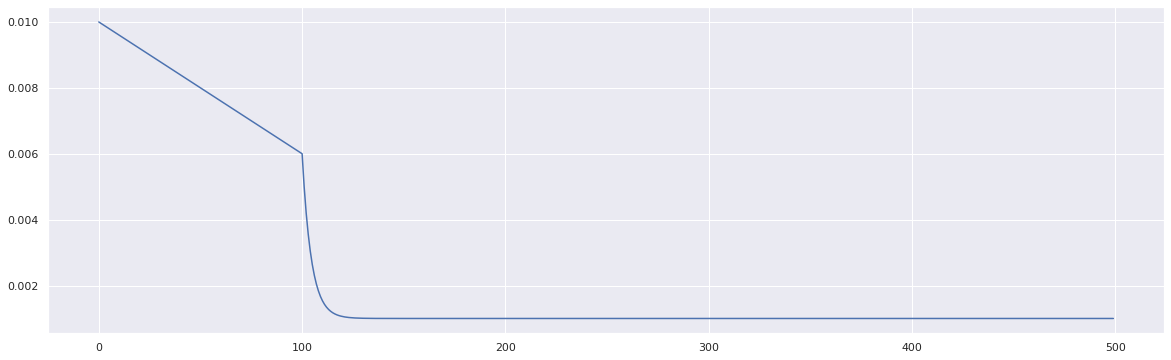

In [63]:
"""dump lr
"""
ep_num_transf = 500



def lrdump(epoch):
    
    #step_size = 100
    lr_max = 0.006
    lr_min = 0.001
    lr_start = 0.01

    lr_init_ep = 0
    lr_ramp_ep = 100
    lr_sus_ep  = 0
    lr_decay   = 0.8

    
    # warm up
    if epoch < lr_init_ep:
        lr = (lr_max - lr_min) / lr_ramp_ep * epoch + lr_min    
        
    elif lr_init_ep -1 < epoch < lr_ramp_ep:
        lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start

    elif epoch < lr_ramp_ep + lr_sus_ep:
        lr = lr_max

    else:
        lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min

    return lr

rng = [i for i in range(ep_num_transf)]
y = [lrdump(x) for x in rng]
sns.set(style='darkgrid')
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)

In [64]:
print('{} ~ {}'.format(min(y), max(y)))

0.001 ~ 0.01


In [65]:
for e, lr in zip(rng,y):
    print('{}\t {}\n'.format(e, lr))

0	 0.01

1	 0.00996

2	 0.00992

3	 0.00988

4	 0.00984

5	 0.0098

6	 0.00976

7	 0.00972

8	 0.00968

9	 0.009640000000000001

10	 0.009600000000000001

11	 0.00956

12	 0.00952

13	 0.00948

14	 0.00944

15	 0.0094

16	 0.00936

17	 0.00932

18	 0.00928

19	 0.00924

20	 0.0092

21	 0.00916

22	 0.00912

23	 0.00908

24	 0.00904

25	 0.009000000000000001

26	 0.00896

27	 0.00892

28	 0.00888

29	 0.00884

30	 0.0088

31	 0.00876

32	 0.00872

33	 0.00868

34	 0.00864

35	 0.0086

36	 0.00856

37	 0.00852

38	 0.00848

39	 0.00844

40	 0.0084

41	 0.00836

42	 0.008320000000000001

43	 0.00828

44	 0.00824

45	 0.0082

46	 0.00816

47	 0.00812

48	 0.00808

49	 0.00804

50	 0.008

51	 0.00796

52	 0.00792

53	 0.00788

54	 0.00784

55	 0.0078

56	 0.0077599999999999995

57	 0.007719999999999999

58	 0.00768

59	 0.00764

60	 0.0076

61	 0.00756

62	 0.007520000000000001

63	 0.0074800000000000005

64	 0.00744

65	 0.0074

66	 0.00736

67	 0.00732

68	 0.00728

69	 0.00724

70	 0.007

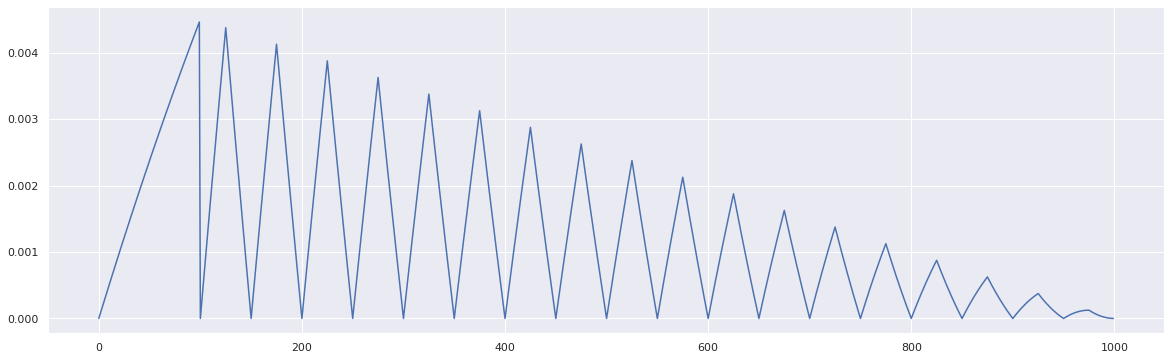

In [66]:
# clr3
# warm up 10% of epoch: it can reduce fall in local min in inital steps.


ep_num = 1000



def clr3(epoch):
    
    
    step_size = 25 # currently best for foot pp
    max_lr = 0.01 # currently best for foot pp
    base_lr = 1e-6 # 1e-6 1e-7

    # warm up
    lr_init_ep = 0
    lr_ramp_ep = 100
    lr_sus_ep  = 0
    lr_decay   = 0.5

    iterations = epoch
    cycle = np.floor(1+iterations/(2*step_size))
    x = np.abs(iterations/step_size - 2*cycle + 1)
    lr = base_lr + (max_lr-base_lr)*np.maximum(0, (1-x))
    
    #todo: boost the lr at initial setps.
#     initial_lr = lambda epoch: lr if epoch > step_size else max_lr
#     initial_lr = lambda epoch: lr if epoch > step_size else boost_lr
#     lr = initial_lr(epoch)
    #todo: boost the lr at fist step_size.
    
    # warm up
    if epoch < lr_ramp_ep:
        lr = (max_lr - base_lr) / lr_ramp_ep * epoch + base_lr
    
    decay = ((epoch+1)/ep_num)
    base_part = 1.001 #1.1
#     print(decay)
    return lr * (base_part-decay) * lr_decay # supressed the lr!


rng = [i for i in range(ep_num)]
y = [clr3(x) for x in rng]
sns.set(style='darkgrid')
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)

In [67]:
print('{} ~ {}'.format(min(y), max(y)))

2.4999999999999966e-08 ~ 0.004459954505


In [68]:
# 2.4999999999999966e-08 ~ 0.004459954505 1e-2~1e-6 

In [69]:
# %%time
# """
# cosine_decay_restarts是cosine_decay的cycle版本。
# first_decay_steps是指第一次完全下降的step數，
# t_mul是指每一次循環的步數都將乘以t_mul倍，
# m_mul指每一次循環重新開始時的初始lr是上一次循環初始值的m_mul倍。
# alpha
# """

# from matplotlib.ticker import FormatStrFormatter



# ep_num = 1000



# def CosineDecayCLRWarmUp(epoch):
    
#     #step_size = 25 # currently best for foot pp
#     max_lr = 1e-2 # currently best for foot pp
#     base_lr = 1e-8# 1e-6 1e-7

#     # warm up
#     lr_init_ep = 0
#     lr_ramp_ep = 100
#     lr_sus_ep  = 0
#     lr_decay   = 0.8


#     initial_learning_rate = 1e-2
#     first_decay_steps = 100


#     lr_decayed_fn = (
#       tf.keras.experimental.CosineDecayRestarts(
#           initial_learning_rate,
#           first_decay_steps,
#           t_mul=1.0,
#           m_mul=0.8,
#           alpha = 0.000001,
#           name="CCosineDecayRestarts"))
    
#     # warm up
#     if epoch < lr_ramp_ep:
#         lr = (max_lr - base_lr) / lr_ramp_ep * epoch + base_lr    
#     else:
#         lr = lr_decayed_fn(epoch)
#     return lr



# rng = [i for i in range(ep_num)]
# y = [CosineDecayCLRWarmUp(x) for x in rng]
# sns.set(style='darkgrid')
# fig, ax = plt.subplots(figsize=(20, 6))
# # plt.ylim(.0000000000000001, .01)# for too large loss
# ax.yaxis.set_major_formatter(FormatStrFormatter('%.12f'))# for too small loss
# plt.plot(rng, y)

In [70]:
# %%time
# """
# cosine_decay_restarts是cosine_decay的cycle版本。
# first_decay_steps是指第一次完全下降的step數，
# t_mul是指每一次循環的步數都將乘以t_mul倍，
# m_mul指每一次循環重新開始時的初始lr是上一次循環初始值的m_mul倍。
# alpha
# """

# from matplotlib.ticker import FormatStrFormatter



# ep_num = 1000



# def CosineDecayCLRWarmUpLSW(epoch):
    
#     #step_size = 25 # currently best for foot pp
#     max_lr = 1e-3 # currently best for foot pp
#     base_lr = 1e-6# 1e-6 1e-7

#     # warm up
#     lr_init_ep = 0
#     lr_ramp_ep = 20
#     lr_sus_ep  = 0
#     lr_decay   = 0.8


#     initial_learning_rate = 1e-3
#     first_decay_steps = 50


#     lr_decayed_fn = (
#       tf.keras.experimental.CosineDecayRestarts(
#           initial_learning_rate,
#           first_decay_steps,
#           t_mul=1.0,
#           m_mul=0.8,
#           alpha = 0.000001,
#           name="CCosineDecayRestarts"))
    
#     # warm up
#     if epoch < lr_ramp_ep:
#         lr = (max_lr - base_lr) / lr_ramp_ep * epoch + base_lr    
#     else:
#         lr = lr_decayed_fn(epoch-lr_ramp_ep)
#     return lr



# rng = [i for i in range(ep_num)]
# y = [CosineDecayCLRWarmUpLSW(x) for x in rng]
# sns.set(style='darkgrid')
# fig, ax = plt.subplots(figsize=(20, 6))
# # plt.ylim(.0000000000000001, .01)# for too large loss
# ax.yaxis.set_major_formatter(FormatStrFormatter('%.12f'))# for too small loss
# plt.plot(rng, y)

CPU times: user 606 ms, sys: 60 ms, total: 666 ms
Wall time: 565 ms


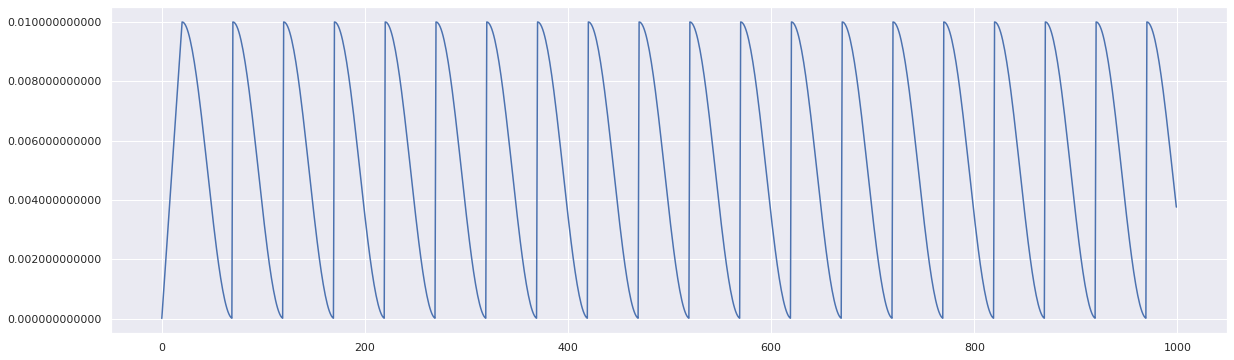

In [71]:
%%time
"""
cosine_decay_restarts是cosine_decay的cycle版本。
first_decay_steps是指第一次完全下降的step數，
t_mul是指每一次循環的步數都將乘以t_mul倍，
m_mul指每一次循環重新開始時的初始lr是上一次循環初始值的m_mul倍。
alpha
"""

from matplotlib.ticker import FormatStrFormatter



ep_num = 1000



def CosineDecayCLRWarmUpLSW_2(epoch):
    
    #step_size = 25 # currently best for foot pp
    max_lr = 1e-2 # currently best for foot pp
    base_lr = 1e-6# 1e-6 1e-7

    # warm up
    lr_init_ep = 0
    lr_ramp_ep = 20
    lr_sus_ep  = 0
    #lr_decay   = 0.8


    initial_learning_rate = 1e-2
    first_decay_steps = 50


    lr_decayed_fn = (
      tf.keras.experimental.CosineDecayRestarts(
          initial_learning_rate,
          first_decay_steps,
          t_mul=1,
          m_mul=1,
          alpha = 0.000001,
          name="CCosineDecayRestarts"))
    
    # warm up
    if epoch < lr_ramp_ep:
        lr = (max_lr - base_lr) / lr_ramp_ep * epoch + base_lr    
    else:
        lr = lr_decayed_fn(epoch-lr_ramp_ep)
    return lr



rng = [i for i in range(ep_num)]
y = [CosineDecayCLRWarmUpLSW_2(x) for x in rng]
sns.set(style='darkgrid')
fig, ax = plt.subplots(figsize=(20, 6))
# plt.ylim(.0000000000000001, .01)# for too large loss
ax.yaxis.set_major_formatter(FormatStrFormatter('%.12f'))# for too small loss
plt.plot(rng, y)

In [72]:
print('{} ~ {}'.format(min(y), max(y)))

1e-06 ~ 0.009999999776482582


In [73]:
# 1.8774175103430935e-08 ~ 0.0010000000474974513 1e-3 1e-6

In [74]:
# lr_reduceonplateau = tf.keras.callbacks.ReduceLROnPlateau(monitor=monitor, factor=0.1, patience=5, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=1e-12)

In [75]:
# Callback for printing the LR at the end of each epoch.
class PrintLRtoe(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
#     def on_epoch_end(self, epoch, logs=None):
#         print('\n[{}] Learning rate for epoch {} is {}'.format(
#             datetime.now().strftime("%Y%m%d-%H%M-%S"), 
#             epoch + 1,
#             self.model.optimizer.lr.numpy()))
        print('\n[{}] Learning rate for epoch {} is {}'.format(
        datetime.now().strftime("%Y%m%d-%H%M-%S"), 
        epoch + 1,
        model_toe.optimizer._decayed_lr(tf.float32).numpy()))

In [76]:
# Callback for printing the LR at the end of each epoch.
class PrintLRheel(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
#         print('\nLearning rate for epoch {} is {}'.format(epoch + 1,
#                                               model_heel.optimizer.lr.numpy()))
        print('\n[{}] Learning rate for epoch {} is {}'.format(
        datetime.now().strftime("%Y%m%d-%H%M-%S"), 
        epoch + 1,
        model_heel.optimizer._decayed_lr(tf.float32).numpy()))

### Output dir and models

In [77]:
def mk_log_dir(log_dir_name):
    try:
        os.makedirs(log_dir_name)
    except OSError as e:
        print("This log dir exist.")
        if e.errno != errno.EEXIST:
            raise ValueError("we got problem.")

In [78]:
monitor = 'val_loss' #'val_loss' 'val_accuracy' if use ed_loss it still the loss here.

log_dir_name = datetime.now().strftime("%Y%m%d-%H%M%S") 

# mk_log_dir(datetime.now().strftime("%Y%m%d-%H%M%S") )  

In [79]:
# use once at the time
mk_log_dir(log_dir_name)

# Toe

In [80]:
model_name = 'EfficientNetB0'

In [81]:
#get_best_model_name

# best_model_name = './' + model_name + '_bs-' + str(BATCH_SIZE) + '_s-' + str(img_height) + '_' + "ep-{epoch:02d}-vloss-{val_loss:.2f}" +'_best-weight.h5'
# best_model_name = '{model_name}-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
#best_model_name = './' + model_name + '_bs' + str(BATCH_SIZE) + '_w' + str(img_width) + '_' + monitor + '_best.h5'
# best_model_name = './Leaf_' + model_name + '_bs' + str(BATCH_SIZE) + '_w' + str(img_width) + '_' + datetime.now().strftime("%Y%m%d-%H%M%S") + '_best_' + monitor + '.h5'

# best_model_name = './cop' + model_name + '_bs' + str(BATCH_SIZE) + '_w' + str(img_width) + '_' + datetime.now().strftime("%Y%m%d-%H%M%S") + '_best_' + monitor + '.h5'

def get_best_model_name(th, K):
    return './' + log_dir_name + '/' + th + '_K' + K + '_' + model_name + '_bs' + str(BATCH_SIZE) + '_w' + str(img_width) + '_best_' + monitor + '.h5'

# th = 'toe'
# # th = 'heel'

# # print(get_best_model_name(th,K))

# best_model_name = get_best_model_name(th, K)


# best_model_save = tf.keras.callbacks.ModelCheckpoint(filepath=best_model_name, 
#                              save_best_only = True, 
#                              save_weights_only = False,
#                              monitor = monitor, 
#                              mode = 'auto', verbose = 1)
# print('best_model_name:', best_model_name)

In [82]:
logdir = log_dir_name + "/logs/toe/"

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [83]:
# callbacks = [
# #     tensorboard_callback,
#     best_model_save,
#     tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=20), #patience=step_size or ep_num
# #     lr_reduceonplateau,
#     tf.keras.callbacks.LearningRateScheduler(lrdump),#lrdump, decay or lrfn or lrfn2. clr
#     PrintLRtoe()
# ]

In [84]:
# Transfer learning from pre-trained weights
def build_efn_model(outputnum, top_dropout_rate, drop_connect_rate):
    base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights="imagenet", input_shape=(120,120,3),drop_connect_rate=drop_connect_rate) #{'imagenet', None}

    # Freeze the pretrained weights
    base_model.trainable = False
    print("base_model.trainable : ", base_model.trainable)

    # Rebuild top
    gap2d = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    BNL = tf.keras.layers.BatchNormalization()(gap2d) #tood: remove#
    dropout = tf.keras.layers.Dropout(top_dropout_rate)(BNL)#tood: remove# J add dropout, for flood 0.2 is ok. for leaf 0.4 is better.
    outputs = tf.keras.layers.Dense(outputnum)(dropout)# remove activation for regression output (to default, the linear), , activation = 'relu' no help

    # Compile new model
    model = tf.keras.Model(base_model.input, outputs, name=model_name)


#     # unfreeze the top #fine_tune_at# layers while leaving BatchNorm layers frozen
#     fine_tune_at = 20 #10 #241 #20
#     print('[Note] Now create model fine tuneing at Top-{} layers!'.format(fine_tune_at))
#     for layer in model_toe.layers[-fine_tune_at:]:
#         if not isinstance(layer, tf.keras.layers.BatchNormalization):
#             layer.trainable = True

    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),#RMSprop , Adam, SGD Adadelta(learning_rate=0.001), if set lr_callback the learning_rate=0.001 will not effeced.
                    loss=ed_metric_2d_mean)

    
    return model

In [85]:
# """Supervised pre-training 減少每次fold都要重新train的時間
# 只先改toe"""

# # Transfer learning from pre-trained weights
# def load_pretrained_efn_model():
#     pre_model_toe_name = "20210224-200728/toe_K0_EfficientNetB0_bs64_w120_best_val_loss.h5"
#     model = tf.keras.models.load_model(pre_model_toe_name,compile=False)

#     # Freeze the pretrained weights
#     model.trainable = False
# #     print("base_model.trainable : ", base_model.trainable)

# #     # Rebuild top
# #     gap2d = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
# #     BNL = tf.keras.layers.BatchNormalization()(gap2d) #tood: remove#
# #     dropout = tf.keras.layers.Dropout(top_dropout_rate)(BNL)#tood: remove# J add dropout, for flood 0.2 is ok. for leaf 0.4 is better.
# #     outputs = tf.keras.layers.Dense(outputnum)(dropout)# remove activation for regression output (to default, the linear), , activation = 'relu' no help

# #     # Compile new model
# #     model = tf.keras.Model(base_model.input, outputs, name=model_name)


# #     # unfreeze the top #fine_tune_at# layers while leaving BatchNorm layers frozen
#     fine_tune_at = 4 #10 #241 #20
#     print('[Note] Now create model fine tuneing at Top-{} layers!'.format(fine_tune_at))
#     for layer in model.layers[-fine_tune_at:]:
#         if not isinstance(layer, tf.keras.layers.BatchNormalization):
#             print('layer trainable +1', layer.name)
#             layer.trainable = True

#     model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),#RMSprop , Adam, SGD Adadelta(learning_rate=0.001), if set lr_callback the learning_rate=0.001 will not effeced.
#                     loss=ed_metric_2d_mean)

    
#     return model

In [86]:
def unfreeze_model(model):
#
#'block7a_expand_conv'20 'block6c_expand_conv'50 'block6a_expand_conv'79 'block5b_expand_conv'109 'block4a_expand_conv' 166  block3a_expand_conv 195
#
    model.trainable = True
    set_trainable = False
    for layer in model.layers:
        if layer.name == 'block3a_expand_conv': 
            set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False

    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),#RMSprop , Adam, SGD Adadelta(learning_rate=0.001), if set lr_callback the learning_rate=0.001 will not effeced.
                    loss=ed_metric_2d_mean)


In [87]:
# top_dropout_rate = 0.8 #less dp rate, say 0.1, train_loss will lower than val_loss
# drop_connect_rate = 0.9 #for efnet This parameter serves as a toggle for extra regularization in finetuning, but does not affect loaded weights.
# outputnum = 2
# with strategy.scope():
#     model_toe = build_efn_model(outputnum, top_dropout_rate, drop_connect_rate)

In [88]:
# len(model_toe.layers)

In [89]:
# tt = 0
# nt = 0
# for layer in model_toe.layers:
#     if layer.trainable:
#         tt +=1
#         print(f'{layer.name}')
#     else:
#         nt +=1
# print(f'tt: {tt}, nt:{nt}')

In [90]:
def count_model_trainOrNot_layers(model, printlayers=False):
    tt = 0
    nt = 0
    for layer in model.layers:
        if layer.trainable:
            tt +=1
            if printlayers:
                print(f'{layer.name}')
        else:
            nt +=1
    print('\n*********************************** Start fine tune ***********************************')
    print(f'tt: {tt}, nt:{nt}, total layers:{tt+nt}')
    print('*********************************** Start fine tune ***********************************')

In [91]:
# count_model_trainOrNot_layers(model_toe)

In [92]:
# model_toe.summary()

In [93]:
# %%time

# # fit the model on all data
# history_toe = model_toe.fit(train_ds_pre_toe_s, 
#                       verbose=1, 
#                       epochs=ep_num_transf, 
#                       validation_data=valid_ds_pre_toe_s, 
#                       callbacks=callbacks)#, validation_split=0.1)

# K-Fold Training

2021-02-23 v1

### Toe K-model

In [94]:
# %%time

# # big K = 5 (fold 0 ~ 4) 
# KFlodNum = 10



# history_toe = []
# history_toe_finetune = []

# #above until 'train_ds_map_toe now' to 'train_ds_map_toe_s', 'valid_ds_map_toe_s'
# for k in range(KFlodNum):
    
    
#     # Split data to train/valid with K-Fold #
#     print("\n \n K = ", k, "\n")
#     # Toe split
#     train_ds_map_toe_s, valid_ds_map_toe_s = get_KFold_ds(train_ds_map_toe, K=k)
    
#     # Toe ds_pre
#     train_ds_pre_toe_s = configure_for_performance_cache_train(train_ds_map_toe_s, augment=True)
#     valid_ds_pre_toe_s = configure_for_performance_cache_val(valid_ds_map_toe_s)
    
    
# #     # heel split
# #     train_ds_map_heel_s, valid_ds_map_heel_s = get_KFold_ds(train_ds_map_heel, K=k)
# #     # Heel ds_pre
# #     train_ds_pre_heel_s = configure_for_performance_cache_train(train_ds_map_heel_s, augment=True)
# #     valid_ds_pre_heel_s = configure_for_performance_cache_val(valid_ds_map_heel_s)
    
    
#     # Train K-Model with transfer learnling #
    
#     # Toe model, TL
#     th = 'toe'
#     # th = 'heel'
#     best_model_name = get_best_model_name(th, K=str(k))
#     best_model_save = tf.keras.callbacks.ModelCheckpoint(filepath=best_model_name, 
#                                  save_best_only = True, 
#                                  save_weights_only = False,
#                                  monitor = monitor, 
#                                  mode = 'auto', verbose = 1)
#     callbacks_toe_tl = [
#                     #     tensorboard_callback,
#                         best_model_save,
#                         tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=30), #patience=step_size or ep_num
#                     #     lr_reduceonplateau,
#                         tf.keras.callbacks.LearningRateScheduler(lrdump),#lrdump, decay or lrfn or lrfn2. clr
#                         PrintLRtoe()
#                         ]
#     callbacks_toe_fn = [
#                     #     tensorboard_callback,
#                         best_model_save,
#                         tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=150), #patience=step_size or ep_num
#                     #     lr_reduceonplateau,
#                         tf.keras.callbacks.LearningRateScheduler(clr3),#lrdump, decay or lrfn or lrfn2. clr, CosineDecayCLRWarmUp, CosineDecayCLRWarmUpLSW
#                         PrintLRtoe()
#                     ]
#     print('best_model_name:', best_model_name)


#     top_dropout_rate = 0.8 #less dp rate, say 0.1, train_loss will lower than val_loss
#     drop_connect_rate = 0.9 #for efnet This parameter serves as a toggle for extra regularization in finetuning, but does not affect loaded weights.
#     outputnum = 2
#     with strategy.scope():
#         model_toe = build_efn_model(outputnum, top_dropout_rate, drop_connect_rate)
# #         model_toe = load_pretrained_efn_model() # from 20210224-200728 ed5.3
# #         count_model_trainOrNot_layers(model_toe)
        
#     # fit the model on all data
#     hist = model_toe.fit(train_ds_pre_toe_s, 
#                           verbose=1, 
#                           epochs=ep_num_transf, 
#                           validation_data=valid_ds_pre_toe_s, 
#                           callbacks=callbacks_toe_tl)#, validation_split=0.1)
#     history_toe.append(hist)
    
      
#     # Train K-Model with fine tune #
    
#     # Toe model, FT
#     unfreeze_model(model_toe)
#     count_model_trainOrNot_layers(model_toe)
#     # fit the model on all data
#     hist = model_toe.fit(train_ds_pre_toe_s, 
#                           verbose=1, 
#                           epochs=ep_num, 
#                           validation_data=valid_ds_pre_toe_s, 
#                           callbacks=callbacks_toe_fn)#, validation_split=0.1)
#     history_toe_finetune.append(hist)


In [95]:
# #ED sum
# def get_valloss(his_v_l):  
#     return np.min(his_v_l), np.argmin(his_v_l)

# t_vl = []
# # h_vl = []
# for k in range(KFlodNum):
#     print(f'K:{k}')
#     t_v, _ = get_valloss(history_toe_finetune[k].history['val_loss'])
# #     h_v, _ = get_valloss(history_heel_finetune[k].history['val_loss'])
    
#     t_vl.append(t_v)
# #     h_vl.append(h_v)

# # t_vl = np.mean(t_vl, axis=0)
# # h_vl = np.mean(h_vl, axis=0)
# # print(f'{round(t_vl,5)} + {round(h_vl,5)} = {round(t_vl + h_vl,5)}')

# t_vl

In [96]:
# np.savetxt(f'{log_dir_name}/toe_FNED.txt', t_vl)

In [97]:
# # Sum plot losses toe-tl

# plt.figure(figsize=(25, 10))

# for k in range(KFlodNum):

#     plt.plot(history_toe[k].history['loss'])
#     plt.plot(history_toe[k].history['val_loss'])

    
# plt.title('K-model ed loss toe-TL')
# plt.ylabel('ed loss'), plt.ylim(5, 80)# for too large loss
# plt.xlabel('epoch')
# plt.legend(['k0 loss', 'k0 val_loss', 'k1 loss', 'k1 val_loss', 'k2 loss', 'k2 val_loss', 
#             'k3 loss', 'k3 val_loss', 'k4 loss', 'k4 val_loss'], loc='upper left') 
# # plt.show()

# # save plot : comment plo.show in jupyter notebook.
# plt.savefig(f'{log_dir_name}/{log_dir_name}_toe_Ksum_TL.png', bbox_inches = 'tight')

In [98]:
# # Single plot loss toe-tl

# for k in range(KFlodNum):
#     plt.figure(figsize=(25, 10))
#     plt.plot(history_toe[k].history['loss'])
#     plt.plot(history_toe[k].history['val_loss'])
#     plt.title('K-model ed loss toe-TL')
#     plt.ylabel('ed loss'), plt.ylim(5, 20)# for too large loss
#     plt.xlabel('epoch')
#     plt.legend(['loss', 'val_loss'], loc='upper left') 
#     # plt.show()

#     # save plot : comment plo.show in jupyter notebook.
#     def get_valloss(his_v_l):   
#         return np.min(his_v_l), np.argmin(his_v_l)

#     vl, ep = get_valloss(history_toe[k].history['val_loss'])
#     plt.savefig(f'{log_dir_name}/{log_dir_name}_toe_K{k}_TL_clr_ed{round(vl,4)}@{ep}.png', bbox_inches = 'tight')

In [99]:
# # check the loos the model trained.

# def get_valloss(his_v_l):  
#     return np.min(his_v_l), np.argmin(his_v_l)

# t_vl = []
# # h_vl = []
# for k in range(KFlodNum):
#     print(f'K:{k}')
#     t_v, _ = get_valloss(history_toe_finetune[k].history['val_loss'])
# #     h_v, _ = get_valloss(history_heel_finetune[k].history['val_loss'])
    
#     t_vl.append(t_v)
    
# # for different scales (different Y-axes)
# # fig, ax1 = plt.subplots()
# fig, ax1 = plt.subplots(figsize=(25, 10))

# # nice to have this colorful tip.
# color = 'tab:red'

# ax1.set_title('[ toe_finetune ] \n ED loss')

# ax1.set_xlabel('epoch')
# ax1.set_ylabel('ed loss', color=color)

# for k in range(KFlodNum):

#     plt.plot(history_toe_finetune[k].history['loss'])
#     plt.plot(history_toe_finetune[k].history['val_loss'])

# ax1.tick_params(axis='y', labelcolor=color)
# # ax1.legend(['loss', 'val_loss'], loc='upper center') # legend may ocvered by next ax ploting. moved to end.
# ax1.legend(['k0 loss', 'k0 val_loss', 'k1 loss', 'k1 val_loss', 'k2 loss', 'k2 val_loss', 
#             'k3 loss', 'k3 val_loss', 'k4 loss', 'k4 val_loss'], loc='upper left') 

# ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# color = 'tab:blue'
# ax2.set_ylabel('learning rate', color=color)
# ax2.plot(history_toe_finetune[0].history['lr'], color=color)
# ax2.tick_params(axis='y', labelcolor=color)
# ax2.legend(['lr'], loc='upper right') 

# # plt.show()

# # # save plot : comment plo.show in jupyter notebook.
# # def get_valloss(his_v_l):   
# #     return np.min(his_v_l), np.argmin(his_v_l)

# # vl, ep = get_valloss(history_toe_finetune.history['val_loss'])


# t_vl = np.mean(t_vl, axis=0)
# plt.savefig(f'{log_dir_name}/{log_dir_name}_toe_ft_Ksum-clr_ed{round(t_vl,4)}.png', bbox_inches = 'tight')

In [100]:
# # Sum plot losses toe-ft

# plt.figure(figsize=(25, 10))

# for k in range(KFlodNum):

#     plt.plot(history_toe_finetune[k].history['loss'])
#     plt.plot(history_toe_finetune[k].history['val_loss'])

    
# plt.title('K-model ed loss toe-FT')
# plt.ylabel('ed loss'), plt.ylim(4, 20)# for too large loss
# plt.xlabel('epoch')
# plt.legend(['k0 loss', 'k0 val_loss', 'k1 loss', 'k1 val_loss', 'k2 loss', 'k2 val_loss', 
#             'k3 loss', 'k3 val_loss', 'k4 loss', 'k4 val_loss'], loc='upper left') 
# # plt.show()

# # save plot : comment plo.show in jupyter notebook.
# plt.savefig(f'{log_dir_name}/{log_dir_name}_toe_Ksum_FT.png', bbox_inches = 'tight')

In [101]:
# # Single plot loss toe-FT

# for k in range(KFlodNum):
#     plt.figure(figsize=(25, 10))
#     plt.plot(history_toe_finetune[k].history['loss'])
#     plt.plot(history_toe_finetune[k].history['val_loss'])
#     plt.title('K-model ed loss toe-FT')
#     plt.ylabel('ed loss'), plt.ylim(4, 20)# for too large loss
#     plt.xlabel('epoch')
#     plt.legend(['loss', 'val_loss'], loc='upper left') 
#     # plt.show()

#     # save plot : comment plo.show in jupyter notebook.
#     def get_valloss(his_v_l):   
#         return np.min(his_v_l), np.argmin(his_v_l)

#     vl, ep = get_valloss(history_toe_finetune[k].history['val_loss'])
#     plt.savefig(f'{log_dir_name}/{log_dir_name}_toe_K{k}_FT_clr_ed{round(vl,4)}@{ep}.png', bbox_inches = 'tight')

### Heel K-model

In [102]:
%%time

# big K = 5 (fold 0 ~ 4) 
KFlodNum = 20 # follow Toe's K.



history_heel = []
history_heel_finetune = []

#above until 'train_ds_map_toe now' to 'train_ds_map_toe_s', 'valid_ds_map_toe_s'
for k in range(KFlodNum):
    
    
    # Split data to train/valid with K-Fold #
    print("K=", k)
#     # Toe split
#     train_ds_map_toe_s, valid_ds_map_toe_s = get_KFold_ds(train_ds_map_toe, K=k)
    
#     # Toe ds_pre
#     train_ds_pre_toe_s = configure_for_performance_cache_train(train_ds_map_toe_s, augment=True)
#     valid_ds_pre_toe_s = configure_for_performance_cache_val(valid_ds_map_toe_s)
    
    
    # heel split
    train_ds_map_heel_s, valid_ds_map_heel_s = get_KFold_ds(train_ds_map_heel, K=k)
    # Heel ds_pre
    train_ds_pre_heel_s = configure_for_performance_cache_train_AToe(train_ds_map_heel_s, augment=True)
    valid_ds_pre_heel_s = configure_for_performance_cache_val(valid_ds_map_heel_s)
    
    
    # Train K-Model with transfer learnling #
    
    # Toe model, TL
    #th = 'toe'
    th = 'heel'
    best_model_name = get_best_model_name(th, K=str(k))
    best_model_save = tf.keras.callbacks.ModelCheckpoint(filepath=best_model_name, 
                                 save_best_only = True, 
                                 save_weights_only = False,
                                 monitor = monitor, 
                                 mode = 'auto', verbose = 1)
    callbacks_heel_tl = [
                    #     tensorboard_callback,
                        best_model_save,
                        tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=30), #patience=step_size or ep_num
                    #     lr_reduceonplateau,
                        tf.keras.callbacks.LearningRateScheduler(lrdump),#lrdump, decay or lrfn or lrfn2. clr
#                         PrintLRheel()
                        ]
    callbacks_heel_fn = [
                    #     tensorboard_callback,
                        best_model_save,
                        tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=150), #patience=step_size or ep_num
                    #     lr_reduceonplateau,
                        tf.keras.callbacks.LearningRateScheduler(clr3),#lrdump, decay or lrfn or lrfn2. clr, CosineDecayCLRWarmUp, CosineDecayCLRWarmUpLSW
#                         PrintLRheel()
                    ]
    print('best_model_name:', best_model_name)


    top_dropout_rate = 0.4 #less dp rate, say 0.1, train_loss will lower than val_loss
    drop_connect_rate = 0.4 #for efnet This parameter serves as a toggle for extra regularization in finetuning, but does not affect loaded weights.
    outputnum = 2
    with strategy.scope():
        model_heel = build_efn_model(outputnum, top_dropout_rate, drop_connect_rate)
    # fit the model on all data
    hist = model_heel.fit(train_ds_pre_heel_s, 
                          verbose=1, 
                          epochs=ep_num_transf, 
                          validation_data=valid_ds_pre_heel_s, 
                          callbacks=callbacks_heel_tl)#, validation_split=0.1)
    history_heel.append(hist)
    
      
    # Train K-Model with fine tune #
    
    # Toe model, FT
    unfreeze_model(model_heel)
    count_model_trainOrNot_layers(model_heel)
    # fit the model on all data
    hist = model_heel.fit(train_ds_pre_heel_s, 
                          verbose=1, 
                          epochs=ep_num, 
                          validation_data=valid_ds_pre_heel_s, 
                          callbacks=callbacks_heel_fn)#, validation_split=0.1)
    history_heel_finetune.append(hist)


K= 0
Check cache in memory:Y True
Check keypoints process01: Tensor("args_1:0", shape=(2,), dtype=int64) (2,) <class 'tensorflow.python.framework.ops.Tensor'>
Check keypoints process02: Tensor("Reshape:0", shape=(1, 2), dtype=int64) (1, 2) <class 'tensorflow.python.framework.ops.Tensor'>
Check keypoints process03: Tensor("PyFunc:1", dtype=float32, device=/job:localhost/replica:0/task:0)
Check keypoints process04: Tensor("Reshape_1:0", shape=(2,), dtype=float32)
Check augment :Y True
Check ds cache[True] and augment[True]
Check cache in memory:Y True
Check augment :N False
Check ds cache[True] and augment[False]
best_model_name: ./20210302-151802/heel_K0_EfficientNetB0_bs64_w120_best_val_loss.h5
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:

21/21 [==============================] - 1s 41ms/step - loss: 16.4029 - val_loss: 13.3871
Epoch 21/500
19/21 [==========================>...] - ETA: 0s - loss: 16.3497
Epoch 00021: val_loss improved from 13.38713 to 12.69112, saving model to ./20210302-151802/heel_K0_EfficientNetB0_bs64_w120_best_val_loss.h5
21/21 [==============================] - 1s 41ms/step - loss: 16.2257 - val_loss: 12.6911
Epoch 22/500
19/21 [==========================>...] - ETA: 0s - loss: 16.4358
Epoch 00022: val_loss did not improve from 12.69112
21/21 [==============================] - 0s 22ms/step - loss: 16.2559 - val_loss: 13.2858
Epoch 23/500
20/21 [===========================>..] - ETA: 0s - loss: 16.2356
Epoch 00023: val_loss improved from 12.69112 to 11.97670, saving model to ./20210302-151802/heel_K0_EfficientNetB0_bs64_w120_best_val_loss.h5
21/21 [==============================] - 1s 58ms/step - loss: 16.1715 - val_loss: 11.9767
Epoch 24/500
21/21 [==============================] - ETA: 0s - loss: 

20/21 [===========================>..] - ETA: 0s - loss: 15.0854
Epoch 00087: val_loss did not improve from 7.92673
21/21 [==============================] - 0s 21ms/step - loss: 15.0363 - val_loss: 8.1369
Epoch 88/500
19/21 [==========================>...] - ETA: 0s - loss: 15.3940
Epoch 00088: val_loss did not improve from 7.92673
21/21 [==============================] - 0s 22ms/step - loss: 15.2901 - val_loss: 8.5074
Epoch 89/500
19/21 [==========================>...] - ETA: 0s - loss: 14.7815
Epoch 00089: val_loss did not improve from 7.92673
21/21 [==============================] - 0s 21ms/step - loss: 14.9732 - val_loss: 9.5293
Epoch 90/500
19/21 [==========================>...] - ETA: 0s - loss: 15.4042
Epoch 00090: val_loss did not improve from 7.92673
21/21 [==============================] - 0s 22ms/step - loss: 15.3821 - val_loss: 8.5108
Epoch 91/500
19/21 [==========================>...] - ETA: 0s - loss: 14.7973
Epoch 00091: val_loss did not improve from 7.92673
21/21 [=====

Epoch 46/1000
21/21 [==============================] - ETA: 0s - loss: 6.8778
Epoch 00046: val_loss did not improve from 3.34383
21/21 [==============================] - 1s 66ms/step - loss: 6.8778 - val_loss: 14.5181
Epoch 47/1000
21/21 [==============================] - ETA: 0s - loss: 7.2161
Epoch 00047: val_loss did not improve from 3.34383
21/21 [==============================] - 1s 64ms/step - loss: 7.2161 - val_loss: 9.5740
Epoch 48/1000
21/21 [==============================] - ETA: 0s - loss: 6.7088
Epoch 00048: val_loss did not improve from 3.34383
21/21 [==============================] - 1s 64ms/step - loss: 6.7088 - val_loss: 4.7821
Epoch 49/1000
21/21 [==============================] - ETA: 0s - loss: 6.8816
Epoch 00049: val_loss did not improve from 3.34383
21/21 [==============================] - 1s 67ms/step - loss: 6.8816 - val_loss: 21.9836
Epoch 50/1000
21/21 [==============================] - ETA: 0s - loss: 6.8747
Epoch 00050: val_loss did not improve from 3.34383
2

Epoch 84/1000
21/21 [==============================] - ETA: 0s - loss: 6.7558
Epoch 00084: val_loss did not improve from 3.34383
21/21 [==============================] - 1s 68ms/step - loss: 6.7558 - val_loss: 3.9847
Epoch 85/1000
21/21 [==============================] - ETA: 0s - loss: 6.3829
Epoch 00085: val_loss did not improve from 3.34383
21/21 [==============================] - 1s 68ms/step - loss: 6.3829 - val_loss: 4.5537
Epoch 86/1000
21/21 [==============================] - ETA: 0s - loss: 6.9136
Epoch 00086: val_loss did not improve from 3.34383
21/21 [==============================] - 1s 66ms/step - loss: 6.9136 - val_loss: 5.2753
Epoch 87/1000
21/21 [==============================] - ETA: 0s - loss: 6.2326
Epoch 00087: val_loss did not improve from 3.34383
21/21 [==============================] - 1s 68ms/step - loss: 6.2326 - val_loss: 5.6011
Epoch 88/1000
21/21 [==============================] - ETA: 0s - loss: 6.5589
Epoch 00088: val_loss did not improve from 3.34383
21/

Epoch 121/1000
21/21 [==============================] - ETA: 0s - loss: 6.2355
Epoch 00121: val_loss did not improve from 3.19840
21/21 [==============================] - 1s 70ms/step - loss: 6.2355 - val_loss: 4.2477
Epoch 122/1000
21/21 [==============================] - ETA: 0s - loss: 5.8415
Epoch 00122: val_loss did not improve from 3.19840
21/21 [==============================] - 1s 65ms/step - loss: 5.8415 - val_loss: 4.1403
Epoch 123/1000
21/21 [==============================] - ETA: 0s - loss: 6.4194- ETA: 0
Epoch 00123: val_loss did not improve from 3.19840
21/21 [==============================] - 1s 69ms/step - loss: 6.4194 - val_loss: 4.1266
Epoch 124/1000
21/21 [==============================] - ETA: 0s - loss: 6.4722
Epoch 00124: val_loss did not improve from 3.19840
21/21 [==============================] - 1s 66ms/step - loss: 6.4722 - val_loss: 4.9713
Epoch 125/1000
21/21 [==============================] - ETA: 0s - loss: 5.9474
Epoch 00125: val_loss did not improve fro

21/21 [==============================] - ETA: 0s - loss: 5.4445
Epoch 00195: val_loss did not improve from 3.16379
21/21 [==============================] - 1s 64ms/step - loss: 5.4445 - val_loss: 3.6342
Epoch 196/1000
21/21 [==============================] - ETA: 0s - loss: 5.6889
Epoch 00196: val_loss did not improve from 3.16379
21/21 [==============================] - 1s 63ms/step - loss: 5.6889 - val_loss: 3.4050
Epoch 197/1000
21/21 [==============================] - ETA: 0s - loss: 5.1970
Epoch 00197: val_loss did not improve from 3.16379
21/21 [==============================] - 1s 63ms/step - loss: 5.1970 - val_loss: 3.2909
Epoch 198/1000
21/21 [==============================] - ETA: 0s - loss: 5.1439
Epoch 00198: val_loss did not improve from 3.16379
21/21 [==============================] - 1s 68ms/step - loss: 5.1439 - val_loss: 3.2204
Epoch 199/1000
21/21 [==============================] - ETA: 0s - loss: 5.6076
Epoch 00199: val_loss did not improve from 3.16379
21/21 [======

Epoch 232/1000
21/21 [==============================] - ETA: 0s - loss: 6.2425
Epoch 00232: val_loss did not improve from 3.05536
21/21 [==============================] - 1s 71ms/step - loss: 6.2425 - val_loss: 4.1369
Epoch 233/1000
21/21 [==============================] - ETA: 0s - loss: 5.7673
Epoch 00233: val_loss did not improve from 3.05536
21/21 [==============================] - 1s 68ms/step - loss: 5.7673 - val_loss: 4.9408
Epoch 234/1000
21/21 [==============================] - ETA: 0s - loss: 5.6038
Epoch 00234: val_loss did not improve from 3.05536
21/21 [==============================] - 1s 64ms/step - loss: 5.6038 - val_loss: 4.0418
Epoch 235/1000
21/21 [==============================] - ETA: 0s - loss: 5.7496
Epoch 00235: val_loss did not improve from 3.05536
21/21 [==============================] - 1s 69ms/step - loss: 5.7496 - val_loss: 3.6900
Epoch 236/1000
21/21 [==============================] - ETA: 0s - loss: 5.8435
Epoch 00236: val_loss did not improve from 3.0553

Epoch 306/1000
21/21 [==============================] - ETA: 0s - loss: 5.2370
Epoch 00306: val_loss did not improve from 2.94775
21/21 [==============================] - 1s 66ms/step - loss: 5.2370 - val_loss: 3.4179
Epoch 307/1000
21/21 [==============================] - ETA: 0s - loss: 5.3619
Epoch 00307: val_loss did not improve from 2.94775
21/21 [==============================] - 1s 68ms/step - loss: 5.3619 - val_loss: 3.3926
Epoch 308/1000
21/21 [==============================] - ETA: 0s - loss: 5.3172
Epoch 00308: val_loss did not improve from 2.94775
21/21 [==============================] - 1s 66ms/step - loss: 5.3172 - val_loss: 3.5794
Epoch 309/1000
21/21 [==============================] - ETA: 0s - loss: 5.1777
Epoch 00309: val_loss did not improve from 2.94775
21/21 [==============================] - 1s 66ms/step - loss: 5.1777 - val_loss: 3.4200
Epoch 310/1000
21/21 [==============================] - ETA: 0s - loss: 5.6160
Epoch 00310: val_loss did not improve from 2.9477

Epoch 344/1000
21/21 [==============================] - ETA: 0s - loss: 5.5392
Epoch 00344: val_loss did not improve from 2.94775
21/21 [==============================] - 1s 65ms/step - loss: 5.5392 - val_loss: 3.1590
Epoch 345/1000
21/21 [==============================] - ETA: 0s - loss: 5.3335
Epoch 00345: val_loss did not improve from 2.94775
21/21 [==============================] - 1s 64ms/step - loss: 5.3335 - val_loss: 3.4072
Epoch 346/1000
21/21 [==============================] - ETA: 0s - loss: 5.5494
Epoch 00346: val_loss did not improve from 2.94775
21/21 [==============================] - 1s 62ms/step - loss: 5.5494 - val_loss: 3.1299
Epoch 347/1000
21/21 [==============================] - ETA: 0s - loss: 5.1112
Epoch 00347: val_loss did not improve from 2.94775
21/21 [==============================] - 1s 65ms/step - loss: 5.1112 - val_loss: 3.0947
Epoch 348/1000
21/21 [==============================] - ETA: 0s - loss: 5.3519
Epoch 00348: val_loss did not improve from 2.9477

Epoch 382/1000
21/21 [==============================] - ETA: 0s - loss: 5.2970
Epoch 00382: val_loss did not improve from 2.94775
21/21 [==============================] - 1s 67ms/step - loss: 5.2970 - val_loss: 3.5963
Epoch 383/1000
21/21 [==============================] - ETA: 0s - loss: 5.2170
Epoch 00383: val_loss did not improve from 2.94775
21/21 [==============================] - 2s 80ms/step - loss: 5.2170 - val_loss: 3.6792
Epoch 384/1000
21/21 [==============================] - ETA: 0s - loss: 5.3242
Epoch 00384: val_loss did not improve from 2.94775
21/21 [==============================] - 1s 67ms/step - loss: 5.3242 - val_loss: 3.8843
Epoch 385/1000
21/21 [==============================] - ETA: 0s - loss: 5.2902
Epoch 00385: val_loss did not improve from 2.94775
21/21 [==============================] - 1s 64ms/step - loss: 5.2902 - val_loss: 3.5478
Epoch 386/1000
21/21 [==============================] - ETA: 0s - loss: 5.2089
Epoch 00386: val_loss did not improve from 2.9477

Epoch 40/500
19/21 [==========================>...] - ETA: 0s - loss: 16.2160
Epoch 00040: val_loss improved from 10.51432 to 9.00252, saving model to ./20210302-151802/heel_K1_EfficientNetB0_bs64_w120_best_val_loss.h5
21/21 [==============================] - 1s 40ms/step - loss: 16.1964 - val_loss: 9.0025
Epoch 41/500
19/21 [==========================>...] - ETA: 0s - loss: 15.7138
Epoch 00041: val_loss improved from 9.00252 to 8.89072, saving model to ./20210302-151802/heel_K1_EfficientNetB0_bs64_w120_best_val_loss.h5
21/21 [==============================] - 1s 39ms/step - loss: 15.7457 - val_loss: 8.8907
Epoch 42/500
19/21 [==========================>...] - ETA: 0s - loss: 16.0098
Epoch 00042: val_loss did not improve from 8.89072
21/21 [==============================] - 0s 22ms/step - loss: 16.0723 - val_loss: 10.0264
Epoch 43/500
19/21 [==========================>...] - ETA: 0s - loss: 15.5046
Epoch 00043: val_loss did not improve from 8.89072
21/21 [==============================

Epoch 76/500
21/21 [==============================] - ETA: 0s - loss: 15.6561
Epoch 00076: val_loss did not improve from 8.61150
21/21 [==============================] - 0s 23ms/step - loss: 15.6561 - val_loss: 9.9385
Epoch 77/500
19/21 [==========================>...] - ETA: 0s - loss: 15.9930
Epoch 00077: val_loss did not improve from 8.61150
21/21 [==============================] - 0s 22ms/step - loss: 16.0961 - val_loss: 8.7087
Epoch 78/500
21/21 [==============================] - ETA: 0s - loss: 15.3896
Epoch 00078: val_loss did not improve from 8.61150
21/21 [==============================] - 0s 21ms/step - loss: 15.3896 - val_loss: 9.1679
Epoch 79/500
19/21 [==========================>...] - ETA: 0s - loss: 15.5657
Epoch 00079: val_loss did not improve from 8.61150
21/21 [==============================] - 0s 23ms/step - loss: 15.6047 - val_loss: 10.1955
Epoch 80/500
20/21 [===========================>..] - ETA: 0s - loss: 15.1369
Epoch 00080: val_loss did not improve from 8.6115

Epoch 59/1000
21/21 [==============================] - ETA: 0s - loss: 6.4326
Epoch 00059: val_loss did not improve from 3.65708
21/21 [==============================] - 1s 61ms/step - loss: 6.4326 - val_loss: 4.1246
Epoch 60/1000
21/21 [==============================] - ETA: 0s - loss: 6.4010
Epoch 00060: val_loss did not improve from 3.65708
21/21 [==============================] - 1s 66ms/step - loss: 6.4010 - val_loss: 5.2271
Epoch 61/1000
21/21 [==============================] - ETA: 0s - loss: 6.6134
Epoch 00061: val_loss did not improve from 3.65708
21/21 [==============================] - 1s 66ms/step - loss: 6.6134 - val_loss: 4.1731
Epoch 62/1000
21/21 [==============================] - ETA: 0s - loss: 6.8007
Epoch 00062: val_loss did not improve from 3.65708
21/21 [==============================] - 1s 68ms/step - loss: 6.8007 - val_loss: 5.7413
Epoch 63/1000
21/21 [==============================] - ETA: 0s - loss: 7.0618
Epoch 00063: val_loss did not improve from 3.65708
21/

21/21 [==============================] - ETA: 0s - loss: 6.1917
Epoch 00133: val_loss did not improve from 3.46376
21/21 [==============================] - 1s 68ms/step - loss: 6.1917 - val_loss: 4.1977
Epoch 134/1000
21/21 [==============================] - ETA: 0s - loss: 6.1842
Epoch 00134: val_loss did not improve from 3.46376
21/21 [==============================] - 1s 65ms/step - loss: 6.1842 - val_loss: 5.0298
Epoch 135/1000
21/21 [==============================] - ETA: 0s - loss: 6.8114
Epoch 00135: val_loss did not improve from 3.46376
21/21 [==============================] - 1s 67ms/step - loss: 6.8114 - val_loss: 5.8379
Epoch 136/1000
21/21 [==============================] - ETA: 0s - loss: 5.8218
Epoch 00136: val_loss did not improve from 3.46376
21/21 [==============================] - 1s 68ms/step - loss: 5.8218 - val_loss: 4.8142
Epoch 137/1000
21/21 [==============================] - ETA: 0s - loss: 5.5818
Epoch 00137: val_loss did not improve from 3.46376
21/21 [======

Epoch 208/1000
21/21 [==============================] - ETA: 0s - loss: 5.4079
Epoch 00208: val_loss did not improve from 3.30088
21/21 [==============================] - 1s 67ms/step - loss: 5.4079 - val_loss: 4.0021
Epoch 209/1000
21/21 [==============================] - ETA: 0s - loss: 5.9997
Epoch 00209: val_loss did not improve from 3.30088
21/21 [==============================] - 1s 67ms/step - loss: 5.9997 - val_loss: 4.1095
Epoch 210/1000
21/21 [==============================] - ETA: 0s - loss: 5.4439
Epoch 00210: val_loss did not improve from 3.30088
21/21 [==============================] - 1s 66ms/step - loss: 5.4439 - val_loss: 3.6077
Epoch 211/1000
21/21 [==============================] - ETA: 0s - loss: 5.5232
Epoch 00211: val_loss did not improve from 3.30088
21/21 [==============================] - 1s 67ms/step - loss: 5.5232 - val_loss: 4.0014
Epoch 212/1000
21/21 [==============================] - ETA: 0s - loss: 5.6869
Epoch 00212: val_loss did not improve from 3.3008

Epoch 246/1000
21/21 [==============================] - ETA: 0s - loss: 5.0518
Epoch 00246: val_loss did not improve from 3.30088
21/21 [==============================] - 1s 63ms/step - loss: 5.0518 - val_loss: 3.3667
Epoch 247/1000
21/21 [==============================] - ETA: 0s - loss: 5.2833
Epoch 00247: val_loss did not improve from 3.30088
21/21 [==============================] - 1s 61ms/step - loss: 5.2833 - val_loss: 3.3342
Epoch 248/1000
21/21 [==============================] - ETA: 0s - loss: 4.9346
Epoch 00248: val_loss did not improve from 3.30088
21/21 [==============================] - 1s 66ms/step - loss: 4.9346 - val_loss: 3.3810
Epoch 249/1000
21/21 [==============================] - ETA: 0s - loss: 5.2372
Epoch 00249: val_loss did not improve from 3.30088
21/21 [==============================] - 1s 64ms/step - loss: 5.2372 - val_loss: 3.3781
Epoch 250/1000
21/21 [==============================] - ETA: 0s - loss: 5.3400
Epoch 00250: val_loss did not improve from 3.3008

Epoch 284/1000
21/21 [==============================] - ETA: 0s - loss: 5.7036
Epoch 00284: val_loss did not improve from 3.30088
21/21 [==============================] - 1s 67ms/step - loss: 5.7036 - val_loss: 3.3872
Epoch 285/1000
21/21 [==============================] - ETA: 0s - loss: 5.6422
Epoch 00285: val_loss did not improve from 3.30088
21/21 [==============================] - 1s 66ms/step - loss: 5.6422 - val_loss: 3.8873
Epoch 286/1000
21/21 [==============================] - ETA: 0s - loss: 5.0581
Epoch 00286: val_loss did not improve from 3.30088
21/21 [==============================] - 1s 64ms/step - loss: 5.0581 - val_loss: 3.4938
Epoch 287/1000
21/21 [==============================] - ETA: 0s - loss: 5.3169
Epoch 00287: val_loss did not improve from 3.30088
21/21 [==============================] - 1s 66ms/step - loss: 5.3169 - val_loss: 3.7854
Epoch 288/1000
21/21 [==============================] - ETA: 0s - loss: 5.8946
Epoch 00288: val_loss did not improve from 3.3008

Epoch 320/1000
21/21 [==============================] - ETA: 0s - loss: 6.2566
Epoch 00320: val_loss did not improve from 3.17866
21/21 [==============================] - 1s 62ms/step - loss: 6.2566 - val_loss: 3.7964
Epoch 321/1000
21/21 [==============================] - ETA: 0s - loss: 5.5885
Epoch 00321: val_loss did not improve from 3.17866
21/21 [==============================] - 1s 67ms/step - loss: 5.5885 - val_loss: 8.7088
Epoch 322/1000
21/21 [==============================] - ETA: 0s - loss: 5.6611
Epoch 00322: val_loss did not improve from 3.17866
21/21 [==============================] - 1s 68ms/step - loss: 5.6611 - val_loss: 3.8295
Epoch 323/1000
21/21 [==============================] - ETA: 0s - loss: 5.3812
Epoch 00323: val_loss did not improve from 3.17866
21/21 [==============================] - 1s 65ms/step - loss: 5.3812 - val_loss: 3.5951
Epoch 324/1000
21/21 [==============================] - ETA: 0s - loss: 5.2488
Epoch 00324: val_loss did not improve from 3.1786

Epoch 363/1000
21/21 [==============================] - ETA: 0s - loss: 5.2479
Epoch 00363: val_loss did not improve from 3.17866
21/21 [==============================] - 1s 62ms/step - loss: 5.2479 - val_loss: 3.6868
Epoch 364/1000
21/21 [==============================] - ETA: 0s - loss: 4.9603
Epoch 00364: val_loss did not improve from 3.17866
21/21 [==============================] - 1s 68ms/step - loss: 4.9603 - val_loss: 3.7446
Epoch 365/1000
21/21 [==============================] - ETA: 0s - loss: 5.0047
Epoch 00365: val_loss did not improve from 3.17866
21/21 [==============================] - 1s 67ms/step - loss: 5.0047 - val_loss: 3.3559
Epoch 366/1000
21/21 [==============================] - ETA: 0s - loss: 5.4598
Epoch 00366: val_loss did not improve from 3.17866
21/21 [==============================] - 1s 67ms/step - loss: 5.4598 - val_loss: 3.4540
Epoch 367/1000
21/21 [==============================] - ETA: 0s - loss: 5.3208
Epoch 00367: val_loss did not improve from 3.1786

Epoch 438/1000
21/21 [==============================] - ETA: 0s - loss: 5.2433
Epoch 00438: val_loss did not improve from 3.17344
21/21 [==============================] - 1s 61ms/step - loss: 5.2433 - val_loss: 3.4685
Epoch 439/1000
21/21 [==============================] - ETA: 0s - loss: 5.1949
Epoch 00439: val_loss did not improve from 3.17344
21/21 [==============================] - 1s 62ms/step - loss: 5.1949 - val_loss: 3.3096
Epoch 440/1000
21/21 [==============================] - ETA: 0s - loss: 5.2378
Epoch 00440: val_loss did not improve from 3.17344
21/21 [==============================] - 1s 63ms/step - loss: 5.2378 - val_loss: 3.5207
Epoch 441/1000
21/21 [==============================] - ETA: 0s - loss: 4.7430
Epoch 00441: val_loss did not improve from 3.17344
21/21 [==============================] - 1s 64ms/step - loss: 4.7430 - val_loss: 3.6232
Epoch 442/1000
21/21 [==============================] - ETA: 0s - loss: 5.0720
Epoch 00442: val_loss did not improve from 3.1734

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



21/21 [==============================] - ETA: 0s - loss: 5.3140
Epoch 00223: val_loss did not improve from 2.94068
21/21 [==============================] - 1s 69ms/step - loss: 5.3140 - val_loss: 4.5099
Epoch 224/1000
21/21 [==============================] - ETA: 0s - loss: 5.5140
Epoch 00224: val_loss did not improve from 2.94068
21/21 [==============================] - 1s 66ms/step - loss: 5.5140 - val_loss: 5.4300
Epoch 225/1000
21/21 [==============================] - ETA: 0s - loss: 6.2113
Epoch 00225: val_loss did not improve from 2.94068
21/21 [==============================] - 1s 69ms/step - loss: 6.2113 - val_loss: 5.9180
Epoch 226/1000
21/21 [==============================] - ETA: 0s - loss: 6.1291
Epoch 00226: val_loss did not improve from 2.94068
21/21 [==============================] - 1s 68ms/step - loss: 6.1291 - val_loss: 4.5357
Epoch 227/1000
21/21 [==============================] - ETA: 0s - loss: 5.3116
Epoch 00227: val_loss did not improve from 2.94068
21/21 [======

Epoch 268/1000
21/21 [==============================] - ETA: 0s - loss: 5.8629
Epoch 00268: val_loss did not improve from 2.94068
21/21 [==============================] - 1s 67ms/step - loss: 5.8629 - val_loss: 4.1459
Epoch 269/1000
21/21 [==============================] - ETA: 0s - loss: 6.6849
Epoch 00269: val_loss did not improve from 2.94068
21/21 [==============================] - 1s 68ms/step - loss: 6.6849 - val_loss: 4.0044
Epoch 270/1000
21/21 [==============================] - ETA: 0s - loss: 5.4738
Epoch 00270: val_loss did not improve from 2.94068
21/21 [==============================] - 1s 63ms/step - loss: 5.4738 - val_loss: 3.1164
Epoch 271/1000
21/21 [==============================] - ETA: 0s - loss: 5.4887
Epoch 00271: val_loss did not improve from 2.94068
21/21 [==============================] - 1s 63ms/step - loss: 5.4887 - val_loss: 3.8582
Epoch 272/1000
21/21 [==============================] - ETA: 0s - loss: 6.0794
Epoch 00272: val_loss did not improve from 2.9406

Epoch 306/1000
21/21 [==============================] - ETA: 0s - loss: 5.3389
Epoch 00306: val_loss did not improve from 2.94068
21/21 [==============================] - 1s 65ms/step - loss: 5.3389 - val_loss: 3.4521
Epoch 307/1000
21/21 [==============================] - ETA: 0s - loss: 5.1432
Epoch 00307: val_loss did not improve from 2.94068
21/21 [==============================] - 1s 66ms/step - loss: 5.1432 - val_loss: 3.2792
Epoch 308/1000
21/21 [==============================] - ETA: 0s - loss: 5.2681
Epoch 00308: val_loss did not improve from 2.94068
21/21 [==============================] - 1s 66ms/step - loss: 5.2681 - val_loss: 3.5416
Epoch 309/1000
21/21 [==============================] - ETA: 0s - loss: 5.5005
Epoch 00309: val_loss did not improve from 2.94068
21/21 [==============================] - 1s 65ms/step - loss: 5.5005 - val_loss: 3.4051
Epoch 310/1000
21/21 [==============================] - ETA: 0s - loss: 4.9220
Epoch 00310: val_loss did not improve from 2.9406

Epoch 344/1000
21/21 [==============================] - ETA: 0s - loss: 4.8867
Epoch 00344: val_loss did not improve from 2.94068
21/21 [==============================] - 1s 63ms/step - loss: 4.8867 - val_loss: 3.7673
Epoch 345/1000
21/21 [==============================] - ETA: 0s - loss: 5.1547
Epoch 00345: val_loss did not improve from 2.94068
21/21 [==============================] - 1s 65ms/step - loss: 5.1547 - val_loss: 3.2321
Epoch 346/1000
21/21 [==============================] - ETA: 0s - loss: 5.4525
Epoch 00346: val_loss did not improve from 2.94068
21/21 [==============================] - 1s 68ms/step - loss: 5.4525 - val_loss: 3.1876
Epoch 347/1000
21/21 [==============================] - ETA: 0s - loss: 5.0238
Epoch 00347: val_loss did not improve from 2.94068
21/21 [==============================] - 1s 67ms/step - loss: 5.0238 - val_loss: 3.3494
Epoch 348/1000
21/21 [==============================] - ETA: 0s - loss: 5.2841
Epoch 00348: val_loss did not improve from 2.9406

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



19/21 [==========================>...] - ETA: 0s - loss: 15.5295
Epoch 00033: val_loss did not improve from 10.66510
21/21 [==============================] - 0s 22ms/step - loss: 15.5803 - val_loss: 11.2054
Epoch 34/500
20/21 [===========================>..] - ETA: 0s - loss: 15.6094
Epoch 00034: val_loss improved from 10.66510 to 10.43706, saving model to ./20210302-151802/heel_K3_EfficientNetB0_bs64_w120_best_val_loss.h5
21/21 [==============================] - 1s 37ms/step - loss: 15.5703 - val_loss: 10.4371
Epoch 35/500
20/21 [===========================>..] - ETA: 0s - loss: 15.9493
Epoch 00035: val_loss did not improve from 10.43706
21/21 [==============================] - 0s 21ms/step - loss: 15.9553 - val_loss: 10.8063
Epoch 36/500
20/21 [===========================>..] - ETA: 0s - loss: 16.1074
Epoch 00036: val_loss did not improve from 10.43706
21/21 [==============================] - 0s 20ms/step - loss: 16.0843 - val_loss: 10.7302
Epoch 37/500
19/21 [=======================

Epoch 31/1000
21/21 [==============================] - ETA: 0s - loss: 7.3680
Epoch 00031: val_loss did not improve from 4.20348
21/21 [==============================] - 1s 67ms/step - loss: 7.3680 - val_loss: 7.1469
Epoch 32/1000
21/21 [==============================] - ETA: 0s - loss: 7.0460
Epoch 00032: val_loss did not improve from 4.20348
21/21 [==============================] - 1s 67ms/step - loss: 7.0460 - val_loss: 7.1946
Epoch 33/1000
21/21 [==============================] - ETA: 0s - loss: 7.9863
Epoch 00033: val_loss did not improve from 4.20348
21/21 [==============================] - 1s 66ms/step - loss: 7.9863 - val_loss: 4.2644
Epoch 34/1000
21/21 [==============================] - ETA: 0s - loss: 6.9958
Epoch 00034: val_loss improved from 4.20348 to 3.85686, saving model to ./20210302-151802/heel_K3_EfficientNetB0_bs64_w120_best_val_loss.h5
21/21 [==============================] - 2s 92ms/step - loss: 6.9958 - val_loss: 3.8569
Epoch 35/1000
21/21 [======================

Epoch 68/1000
21/21 [==============================] - ETA: 0s - loss: 6.7331
Epoch 00068: val_loss did not improve from 3.29935
21/21 [==============================] - 1s 66ms/step - loss: 6.7331 - val_loss: 5.1885
Epoch 69/1000
21/21 [==============================] - ETA: 0s - loss: 7.4491
Epoch 00069: val_loss did not improve from 3.29935
21/21 [==============================] - 1s 65ms/step - loss: 7.4491 - val_loss: 12.8561
Epoch 70/1000
21/21 [==============================] - ETA: 0s - loss: 7.1460
Epoch 00070: val_loss did not improve from 3.29935
21/21 [==============================] - 1s 66ms/step - loss: 7.1460 - val_loss: 11.5202
Epoch 71/1000
21/21 [==============================] - ETA: 0s - loss: 6.6114
Epoch 00071: val_loss did not improve from 3.29935
21/21 [==============================] - 1s 64ms/step - loss: 6.6114 - val_loss: 4.6340
Epoch 72/1000
21/21 [==============================] - ETA: 0s - loss: 6.9044
Epoch 00072: val_loss did not improve from 3.29935
2

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



21/21 [==============================] - ETA: 0s - loss: 4.8694
Epoch 00604: val_loss did not improve from 2.90919
21/21 [==============================] - 1s 65ms/step - loss: 4.8694 - val_loss: 2.9719
Epoch 605/1000
21/21 [==============================] - ETA: 0s - loss: 4.8483
Epoch 00605: val_loss did not improve from 2.90919
21/21 [==============================] - 1s 66ms/step - loss: 4.8483 - val_loss: 3.0593
Epoch 606/1000
21/21 [==============================] - ETA: 0s - loss: 4.7549
Epoch 00606: val_loss did not improve from 2.90919
21/21 [==============================] - 1s 67ms/step - loss: 4.7549 - val_loss: 3.1315
Epoch 607/1000
21/21 [==============================] - ETA: 0s - loss: 5.1586
Epoch 00607: val_loss did not improve from 2.90919
21/21 [==============================] - 1s 66ms/step - loss: 5.1586 - val_loss: 2.9369
Epoch 608/1000
21/21 [==============================] - ETA: 0s - loss: 5.0360
Epoch 00608: val_loss did not improve from 2.90919
21/21 [======

Epoch 678/1000
21/21 [==============================] - ETA: 0s - loss: 5.0175
Epoch 00678: val_loss did not improve from 2.79949
21/21 [==============================] - 1s 62ms/step - loss: 5.0175 - val_loss: 3.4293
Epoch 679/1000
21/21 [==============================] - ETA: 0s - loss: 4.5441
Epoch 00679: val_loss did not improve from 2.79949
21/21 [==============================] - 1s 67ms/step - loss: 4.5441 - val_loss: 3.1623
Epoch 680/1000
21/21 [==============================] - ETA: 0s - loss: 5.0492
Epoch 00680: val_loss did not improve from 2.79949
21/21 [==============================] - 1s 67ms/step - loss: 5.0492 - val_loss: 3.1033
Epoch 681/1000
21/21 [==============================] - ETA: 0s - loss: 5.3910
Epoch 00681: val_loss did not improve from 2.79949
21/21 [==============================] - 1s 68ms/step - loss: 5.3910 - val_loss: 3.6984
Epoch 682/1000
21/21 [==============================] - ETA: 0s - loss: 4.7774
Epoch 00682: val_loss did not improve from 2.7994

Epoch 716/1000
21/21 [==============================] - ETA: 0s - loss: 5.2013
Epoch 00716: val_loss did not improve from 2.79949
21/21 [==============================] - 1s 67ms/step - loss: 5.2013 - val_loss: 3.3163
Epoch 717/1000
21/21 [==============================] - ETA: 0s - loss: 4.9862
Epoch 00717: val_loss did not improve from 2.79949
21/21 [==============================] - 1s 66ms/step - loss: 4.9862 - val_loss: 3.9751
Epoch 718/1000
21/21 [==============================] - ETA: 0s - loss: 5.1826
Epoch 00718: val_loss did not improve from 2.79949
21/21 [==============================] - 1s 67ms/step - loss: 5.1826 - val_loss: 3.0403
Epoch 719/1000
21/21 [==============================] - ETA: 0s - loss: 4.8005
Epoch 00719: val_loss did not improve from 2.79949
21/21 [==============================] - 1s 68ms/step - loss: 4.8005 - val_loss: 3.3383
Epoch 720/1000
21/21 [==============================] - ETA: 0s - loss: 4.9411
Epoch 00720: val_loss did not improve from 2.7994

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



21/21 [==============================] - ETA: 0s - loss: 4.6478
Epoch 00746: val_loss did not improve from 2.79949
21/21 [==============================] - 1s 67ms/step - loss: 4.6478 - val_loss: 2.9125
Epoch 747/1000
21/21 [==============================] - ETA: 0s - loss: 4.8043
Epoch 00747: val_loss did not improve from 2.79949
21/21 [==============================] - 1s 68ms/step - loss: 4.8043 - val_loss: 2.9564
Epoch 748/1000
21/21 [==============================] - ETA: 0s - loss: 4.7604
Epoch 00748: val_loss did not improve from 2.79949
21/21 [==============================] - 1s 68ms/step - loss: 4.7604 - val_loss: 2.9899
Epoch 749/1000
21/21 [==============================] - ETA: 0s - loss: 4.9028
Epoch 00749: val_loss did not improve from 2.79949
21/21 [==============================] - 1s 67ms/step - loss: 4.9028 - val_loss: 2.9727
Epoch 750/1000
21/21 [==============================] - ETA: 0s - loss: 4.6441
Epoch 00750: val_loss did not improve from 2.79949
21/21 [======

Epoch 784/1000
21/21 [==============================] - ETA: 0s - loss: 4.8007
Epoch 00784: val_loss did not improve from 2.79949
21/21 [==============================] - 1s 66ms/step - loss: 4.8007 - val_loss: 3.0903
Epoch 785/1000
21/21 [==============================] - ETA: 0s - loss: 4.8488
Epoch 00785: val_loss did not improve from 2.79949
21/21 [==============================] - 1s 67ms/step - loss: 4.8488 - val_loss: 3.2737
Epoch 786/1000
21/21 [==============================] - ETA: 0s - loss: 4.7234
Epoch 00786: val_loss did not improve from 2.79949
21/21 [==============================] - 1s 63ms/step - loss: 4.7234 - val_loss: 3.0952
Epoch 787/1000
21/21 [==============================] - ETA: 0s - loss: 5.1273
Epoch 00787: val_loss did not improve from 2.79949
21/21 [==============================] - 1s 68ms/step - loss: 5.1273 - val_loss: 3.5875
Epoch 788/1000
21/21 [==============================] - ETA: 0s - loss: 5.3562
Epoch 00788: val_loss did not improve from 2.7994

21/21 [==============================] - 1s 41ms/step - loss: 19.1040 - val_loss: 20.7977
Epoch 6/500
19/21 [==========================>...] - ETA: 0s - loss: 18.3138
Epoch 00006: val_loss improved from 20.79766 to 19.99404, saving model to ./20210302-151802/heel_K4_EfficientNetB0_bs64_w120_best_val_loss.h5
21/21 [==============================] - 1s 42ms/step - loss: 18.5161 - val_loss: 19.9940
Epoch 7/500
19/21 [==========================>...] - ETA: 0s - loss: 17.8725
Epoch 00007: val_loss improved from 19.99404 to 19.60443, saving model to ./20210302-151802/heel_K4_EfficientNetB0_bs64_w120_best_val_loss.h5
21/21 [==============================] - 1s 41ms/step - loss: 17.8519 - val_loss: 19.6044
Epoch 8/500
20/21 [===========================>..] - ETA: 0s - loss: 17.5100
Epoch 00008: val_loss improved from 19.60443 to 19.09959, saving model to ./20210302-151802/heel_K4_EfficientNetB0_bs64_w120_best_val_loss.h5
21/21 [==============================] - 1s 40ms/step - loss: 17.4464 - v

Epoch 36/500
19/21 [==========================>...] - ETA: 0s - loss: 15.7125
Epoch 00036: val_loss did not improve from 10.68832
21/21 [==============================] - 1s 24ms/step - loss: 15.6862 - val_loss: 11.7091
Epoch 37/500
19/21 [==========================>...] - ETA: 0s - loss: 15.7804
Epoch 00037: val_loss did not improve from 10.68832
21/21 [==============================] - 0s 23ms/step - loss: 15.7940 - val_loss: 11.2488
Epoch 38/500
19/21 [==========================>...] - ETA: 0s - loss: 15.8262
Epoch 00038: val_loss did not improve from 10.68832
21/21 [==============================] - 1s 24ms/step - loss: 15.8015 - val_loss: 11.5135
Epoch 39/500
19/21 [==========================>...] - ETA: 0s - loss: 15.7360
Epoch 00039: val_loss did not improve from 10.68832
21/21 [==============================] - 1s 24ms/step - loss: 15.8448 - val_loss: 10.9175
Epoch 40/500
19/21 [==========================>...] - ETA: 0s - loss: 15.3312
Epoch 00040: val_loss improved from 10.688

Epoch 22/1000
21/21 [==============================] - ETA: 0s - loss: 8.1647
Epoch 00022: val_loss did not improve from 5.72862
21/21 [==============================] - 1s 67ms/step - loss: 8.1647 - val_loss: 10.4260
Epoch 23/1000
21/21 [==============================] - ETA: 0s - loss: 8.2080
Epoch 00023: val_loss did not improve from 5.72862
21/21 [==============================] - 1s 67ms/step - loss: 8.2080 - val_loss: 9.6802
Epoch 24/1000
21/21 [==============================] - ETA: 0s - loss: 7.6787
Epoch 00024: val_loss did not improve from 5.72862
21/21 [==============================] - 1s 70ms/step - loss: 7.6787 - val_loss: 6.8285
Epoch 25/1000
21/21 [==============================] - ETA: 0s - loss: 7.4749
Epoch 00025: val_loss improved from 5.72862 to 4.97185, saving model to ./20210302-151802/heel_K4_EfficientNetB0_bs64_w120_best_val_loss.h5
21/21 [==============================] - 2s 94ms/step - loss: 7.4749 - val_loss: 4.9719
Epoch 26/1000
21/21 [=====================

Epoch 95/1000
21/21 [==============================] - ETA: 0s - loss: 6.6972
Epoch 00095: val_loss did not improve from 3.47256
21/21 [==============================] - 1s 68ms/step - loss: 6.6972 - val_loss: 4.6831
Epoch 96/1000
21/21 [==============================] - ETA: 0s - loss: 6.5022
Epoch 00096: val_loss did not improve from 3.47256
21/21 [==============================] - 1s 67ms/step - loss: 6.5022 - val_loss: 3.8141
Epoch 97/1000
21/21 [==============================] - ETA: 0s - loss: 6.0307
Epoch 00097: val_loss did not improve from 3.47256
21/21 [==============================] - 1s 65ms/step - loss: 6.0307 - val_loss: 4.8214
Epoch 98/1000
21/21 [==============================] - ETA: 0s - loss: 6.2408
Epoch 00098: val_loss did not improve from 3.47256
21/21 [==============================] - 1s 67ms/step - loss: 6.2408 - val_loss: 4.7581
Epoch 99/1000
21/21 [==============================] - ETA: 0s - loss: 6.7791
Epoch 00099: val_loss did not improve from 3.47256
21/

21/21 [==============================] - ETA: 0s - loss: 5.8187
Epoch 00166: val_loss did not improve from 3.04480
21/21 [==============================] - 1s 66ms/step - loss: 5.8187 - val_loss: 3.3917
Epoch 167/1000
21/21 [==============================] - ETA: 0s - loss: 5.8835
Epoch 00167: val_loss did not improve from 3.04480
21/21 [==============================] - 1s 66ms/step - loss: 5.8835 - val_loss: 3.3858
Epoch 168/1000
21/21 [==============================] - ETA: 0s - loss: 5.9679
Epoch 00168: val_loss did not improve from 3.04480
21/21 [==============================] - 1s 67ms/step - loss: 5.9679 - val_loss: 3.0554
Epoch 169/1000
21/21 [==============================] - ETA: 0s - loss: 5.7531
Epoch 00169: val_loss did not improve from 3.04480
21/21 [==============================] - 1s 68ms/step - loss: 5.7531 - val_loss: 3.7178
Epoch 170/1000
21/21 [==============================] - ETA: 0s - loss: 5.9843
Epoch 00170: val_loss did not improve from 3.04480
21/21 [======

Epoch 241/1000
21/21 [==============================] - ETA: 0s - loss: 5.3050
Epoch 00241: val_loss did not improve from 2.97170
21/21 [==============================] - 1s 68ms/step - loss: 5.3050 - val_loss: 5.8962
Epoch 242/1000
21/21 [==============================] - ETA: 0s - loss: 5.5195
Epoch 00242: val_loss did not improve from 2.97170
21/21 [==============================] - 1s 66ms/step - loss: 5.5195 - val_loss: 4.3534
Epoch 243/1000
21/21 [==============================] - ETA: 0s - loss: 5.7010
Epoch 00243: val_loss did not improve from 2.97170
21/21 [==============================] - 1s 67ms/step - loss: 5.7010 - val_loss: 3.1030
Epoch 244/1000
21/21 [==============================] - ETA: 0s - loss: 5.6579
Epoch 00244: val_loss did not improve from 2.97170
21/21 [==============================] - 1s 68ms/step - loss: 5.6579 - val_loss: 3.4480
Epoch 245/1000
21/21 [==============================] - ETA: 0s - loss: 5.3364
Epoch 00245: val_loss did not improve from 2.9717

Epoch 279/1000
21/21 [==============================] - ETA: 0s - loss: 5.6589
Epoch 00279: val_loss did not improve from 2.97170
21/21 [==============================] - 1s 68ms/step - loss: 5.6589 - val_loss: 4.1463
Epoch 280/1000
21/21 [==============================] - ETA: 0s - loss: 5.4878
Epoch 00280: val_loss did not improve from 2.97170
21/21 [==============================] - 1s 67ms/step - loss: 5.4878 - val_loss: 3.8159
Epoch 281/1000
21/21 [==============================] - ETA: 0s - loss: 5.7300
Epoch 00281: val_loss did not improve from 2.97170
21/21 [==============================] - 1s 66ms/step - loss: 5.7300 - val_loss: 3.5890
Epoch 282/1000
21/21 [==============================] - ETA: 0s - loss: 5.6117
Epoch 00282: val_loss did not improve from 2.97170
21/21 [==============================] - 1s 68ms/step - loss: 5.6117 - val_loss: 13.0900
Epoch 283/1000
21/21 [==============================] - ETA: 0s - loss: 5.3994
Epoch 00283: val_loss did not improve from 2.971

Epoch 317/1000
21/21 [==============================] - ETA: 0s - loss: 5.4089
Epoch 00317: val_loss did not improve from 2.97170
21/21 [==============================] - 1s 67ms/step - loss: 5.4089 - val_loss: 3.7650
Epoch 318/1000
21/21 [==============================] - ETA: 0s - loss: 5.8832
Epoch 00318: val_loss did not improve from 2.97170
21/21 [==============================] - 1s 66ms/step - loss: 5.8832 - val_loss: 4.1074
Epoch 319/1000
21/21 [==============================] - ETA: 0s - loss: 5.4027
Epoch 00319: val_loss did not improve from 2.97170
21/21 [==============================] - 1s 68ms/step - loss: 5.4027 - val_loss: 3.4424
Epoch 320/1000
21/21 [==============================] - ETA: 0s - loss: 5.8337
Epoch 00320: val_loss did not improve from 2.97170
21/21 [==============================] - 1s 67ms/step - loss: 5.8337 - val_loss: 4.1370
Epoch 321/1000
21/21 [==============================] - ETA: 0s - loss: 5.4717
Epoch 00321: val_loss did not improve from 2.9717

Epoch 4/500
19/21 [==========================>...] - ETA: 0s - loss: 20.2652
Epoch 00004: val_loss improved from 24.06213 to 22.12497, saving model to ./20210302-151802/heel_K5_EfficientNetB0_bs64_w120_best_val_loss.h5
21/21 [==============================] - 1s 39ms/step - loss: 20.1756 - val_loss: 22.1250
Epoch 5/500
19/21 [==========================>...] - ETA: 0s - loss: 19.3888
Epoch 00005: val_loss improved from 22.12497 to 21.69602, saving model to ./20210302-151802/heel_K5_EfficientNetB0_bs64_w120_best_val_loss.h5
21/21 [==============================] - 1s 39ms/step - loss: 19.2436 - val_loss: 21.6960
Epoch 6/500
20/21 [===========================>..] - ETA: 0s - loss: 17.6749
Epoch 00006: val_loss improved from 21.69602 to 20.83346, saving model to ./20210302-151802/heel_K5_EfficientNetB0_bs64_w120_best_val_loss.h5
21/21 [==============================] - 1s 39ms/step - loss: 17.6689 - val_loss: 20.8335
Epoch 7/500
19/21 [==========================>...] - ETA: 0s - loss: 18.3

Epoch 33/500
19/21 [==========================>...] - ETA: 0s - loss: 15.7140
Epoch 00033: val_loss did not improve from 10.41905
21/21 [==============================] - 0s 22ms/step - loss: 15.7765 - val_loss: 11.1889
Epoch 34/500
20/21 [===========================>..] - ETA: 0s - loss: 15.8163
Epoch 00034: val_loss did not improve from 10.41905
21/21 [==============================] - 0s 21ms/step - loss: 15.9221 - val_loss: 11.5324
Epoch 35/500
19/21 [==========================>...] - ETA: 0s - loss: 15.6916
Epoch 00035: val_loss did not improve from 10.41905
21/21 [==============================] - 0s 22ms/step - loss: 15.6193 - val_loss: 10.9450
Epoch 36/500
20/21 [===========================>..] - ETA: 0s - loss: 16.1033
Epoch 00036: val_loss did not improve from 10.41905
21/21 [==============================] - 0s 21ms/step - loss: 16.2219 - val_loss: 11.4676
Epoch 37/500
19/21 [==========================>...] - ETA: 0s - loss: 15.9241
Epoch 00037: val_loss did not improve from

Epoch 69/500
20/21 [===========================>..] - ETA: 0s - loss: 15.5580
Epoch 00069: val_loss did not improve from 9.27330
21/21 [==============================] - 0s 21ms/step - loss: 15.5072 - val_loss: 9.7359
Epoch 70/500
19/21 [==========================>...] - ETA: 0s - loss: 14.9042
Epoch 00070: val_loss did not improve from 9.27330
21/21 [==============================] - 0s 22ms/step - loss: 14.8479 - val_loss: 11.5100
Epoch 71/500
20/21 [===========================>..] - ETA: 0s - loss: 15.2891
Epoch 00071: val_loss did not improve from 9.27330
21/21 [==============================] - 0s 21ms/step - loss: 15.3665 - val_loss: 10.1565
Epoch 72/500
19/21 [==========================>...] - ETA: 0s - loss: 15.3222
Epoch 00072: val_loss did not improve from 9.27330
21/21 [==============================] - 0s 22ms/step - loss: 15.1841 - val_loss: 9.6690
Epoch 73/500
19/21 [==========================>...] - ETA: 0s - loss: 15.4077
Epoch 00073: val_loss did not improve from 9.273

Epoch 106/500
19/21 [==========================>...] - ETA: 0s - loss: 15.7546
Epoch 00106: val_loss did not improve from 8.88116
21/21 [==============================] - 0s 21ms/step - loss: 15.7544 - val_loss: 9.6210
Epoch 107/500
20/21 [===========================>..] - ETA: 0s - loss: 14.9844
Epoch 00107: val_loss did not improve from 8.88116
21/21 [==============================] - 0s 22ms/step - loss: 14.9359 - val_loss: 9.0803
Epoch 108/500
20/21 [===========================>..] - ETA: 0s - loss: 15.8649
Epoch 00108: val_loss did not improve from 8.88116
21/21 [==============================] - 0s 20ms/step - loss: 15.7686 - val_loss: 9.3640
Epoch 109/500
21/21 [==============================] - ETA: 0s - loss: 14.6796
Epoch 00109: val_loss did not improve from 8.88116
21/21 [==============================] - 0s 21ms/step - loss: 14.6796 - val_loss: 9.2760

*********************************** Start fine tune ***********************************
tt: 195, nt:46, total layers:241
**

Epoch 30/1000
21/21 [==============================] - ETA: 0s - loss: 7.1872
Epoch 00030: val_loss did not improve from 3.64719
21/21 [==============================] - 1s 66ms/step - loss: 7.1872 - val_loss: 5.5742
Epoch 31/1000
21/21 [==============================] - ETA: 0s - loss: 7.6576
Epoch 00031: val_loss did not improve from 3.64719
21/21 [==============================] - 1s 67ms/step - loss: 7.6576 - val_loss: 22.4641
Epoch 32/1000
21/21 [==============================] - ETA: 0s - loss: 7.8648
Epoch 00032: val_loss did not improve from 3.64719
21/21 [==============================] - 1s 68ms/step - loss: 7.8648 - val_loss: 21.6199
Epoch 33/1000
21/21 [==============================] - ETA: 0s - loss: 7.5081
Epoch 00033: val_loss did not improve from 3.64719
21/21 [==============================] - 1s 69ms/step - loss: 7.5081 - val_loss: 9.9950
Epoch 34/1000
21/21 [==============================] - ETA: 0s - loss: 7.6511
Epoch 00034: val_loss did not improve from 3.64719
2

21/21 [==============================] - ETA: 0s - loss: 5.9810
Epoch 00104: val_loss did not improve from 3.36770
21/21 [==============================] - 1s 67ms/step - loss: 5.9810 - val_loss: 3.5331
Epoch 105/1000
21/21 [==============================] - ETA: 0s - loss: 6.1744
Epoch 00105: val_loss did not improve from 3.36770
21/21 [==============================] - 1s 64ms/step - loss: 6.1744 - val_loss: 3.5272
Epoch 106/1000
21/21 [==============================] - ETA: 0s - loss: 5.8118
Epoch 00106: val_loss improved from 3.36770 to 3.30004, saving model to ./20210302-151802/heel_K5_EfficientNetB0_bs64_w120_best_val_loss.h5
21/21 [==============================] - 2s 95ms/step - loss: 5.8118 - val_loss: 3.3000
Epoch 107/1000
21/21 [==============================] - ETA: 0s - loss: 5.8281
Epoch 00107: val_loss did not improve from 3.30004
21/21 [==============================] - 1s 69ms/step - loss: 5.8281 - val_loss: 3.3622
Epoch 108/1000
21/21 [==============================] 

21/21 [==============================] - ETA: 0s - loss: 5.7578
Epoch 00140: val_loss did not improve from 3.03671
21/21 [==============================] - 1s 64ms/step - loss: 5.7578 - val_loss: 3.7998
Epoch 141/1000
21/21 [==============================] - ETA: 0s - loss: 5.8565
Epoch 00141: val_loss did not improve from 3.03671
21/21 [==============================] - 1s 62ms/step - loss: 5.8565 - val_loss: 3.5484
Epoch 142/1000
21/21 [==============================] - ETA: 0s - loss: 6.1820
Epoch 00142: val_loss did not improve from 3.03671
21/21 [==============================] - 1s 62ms/step - loss: 6.1820 - val_loss: 3.7375
Epoch 143/1000
21/21 [==============================] - ETA: 0s - loss: 5.9858
Epoch 00143: val_loss did not improve from 3.03671
21/21 [==============================] - 1s 65ms/step - loss: 5.9858 - val_loss: 3.2766
Epoch 144/1000
21/21 [==============================] - ETA: 0s - loss: 5.7086
Epoch 00144: val_loss did not improve from 3.03671
21/21 [======

21/21 [==============================] - ETA: 0s - loss: 6.0750
Epoch 00214: val_loss did not improve from 2.91778
21/21 [==============================] - 1s 67ms/step - loss: 6.0750 - val_loss: 4.0007
Epoch 215/1000
21/21 [==============================] - ETA: 0s - loss: 5.8216
Epoch 00215: val_loss did not improve from 2.91778
21/21 [==============================] - 1s 67ms/step - loss: 5.8216 - val_loss: 3.4631
Epoch 216/1000
21/21 [==============================] - ETA: 0s - loss: 5.9225
Epoch 00216: val_loss did not improve from 2.91778
21/21 [==============================] - 1s 68ms/step - loss: 5.9225 - val_loss: 3.3258
Epoch 217/1000
21/21 [==============================] - ETA: 0s - loss: 5.5482
Epoch 00217: val_loss did not improve from 2.91778
21/21 [==============================] - 1s 65ms/step - loss: 5.5482 - val_loss: 3.3217
Epoch 218/1000
21/21 [==============================] - ETA: 0s - loss: 5.5073
Epoch 00218: val_loss did not improve from 2.91778
21/21 [======

Epoch 252/1000
21/21 [==============================] - ETA: 0s - loss: 5.0440
Epoch 00252: val_loss did not improve from 2.91778
21/21 [==============================] - 1s 65ms/step - loss: 5.0440 - val_loss: 3.2256
Epoch 253/1000
21/21 [==============================] - ETA: 0s - loss: 5.0808
Epoch 00253: val_loss did not improve from 2.91778
21/21 [==============================] - 1s 67ms/step - loss: 5.0808 - val_loss: 3.4782
Epoch 254/1000
21/21 [==============================] - ETA: 0s - loss: 5.2909
Epoch 00254: val_loss did not improve from 2.91778
21/21 [==============================] - 1s 67ms/step - loss: 5.2909 - val_loss: 3.8773
Epoch 255/1000
21/21 [==============================] - ETA: 0s - loss: 5.2613
Epoch 00255: val_loss did not improve from 2.91778
21/21 [==============================] - 1s 65ms/step - loss: 5.2613 - val_loss: 4.0022
Epoch 256/1000
21/21 [==============================] - ETA: 0s - loss: 5.2331
Epoch 00256: val_loss did not improve from 2.9177

Epoch 290/1000
21/21 [==============================] - ETA: 0s - loss: 6.0882
Epoch 00290: val_loss did not improve from 2.91778
21/21 [==============================] - 1s 64ms/step - loss: 6.0882 - val_loss: 3.4324
Epoch 291/1000
21/21 [==============================] - ETA: 0s - loss: 5.1636
Epoch 00291: val_loss did not improve from 2.91778
21/21 [==============================] - 1s 67ms/step - loss: 5.1636 - val_loss: 3.2172
Epoch 292/1000
21/21 [==============================] - ETA: 0s - loss: 5.2528
Epoch 00292: val_loss did not improve from 2.91778
21/21 [==============================] - 1s 61ms/step - loss: 5.2528 - val_loss: 3.3155
Epoch 293/1000
21/21 [==============================] - ETA: 0s - loss: 5.2649
Epoch 00293: val_loss did not improve from 2.91778
21/21 [==============================] - 1s 67ms/step - loss: 5.2649 - val_loss: 3.3931
Epoch 294/1000
21/21 [==============================] - ETA: 0s - loss: 5.1543
Epoch 00294: val_loss did not improve from 2.9177

Epoch 328/1000
21/21 [==============================] - ETA: 0s - loss: 5.7086
Epoch 00328: val_loss did not improve from 2.91778
21/21 [==============================] - 1s 67ms/step - loss: 5.7086 - val_loss: 4.5376
Epoch 329/1000
21/21 [==============================] - ETA: 0s - loss: 5.4945
Epoch 00329: val_loss did not improve from 2.91778
21/21 [==============================] - 1s 68ms/step - loss: 5.4945 - val_loss: 3.0605
Epoch 330/1000
21/21 [==============================] - ETA: 0s - loss: 6.0263
Epoch 00330: val_loss did not improve from 2.91778
21/21 [==============================] - 1s 66ms/step - loss: 6.0263 - val_loss: 3.7119
Epoch 331/1000
21/21 [==============================] - ETA: 0s - loss: 5.7758
Epoch 00331: val_loss did not improve from 2.91778
21/21 [==============================] - 1s 67ms/step - loss: 5.7758 - val_loss: 3.7817
Epoch 332/1000
21/21 [==============================] - ETA: 0s - loss: 5.8000
Epoch 00332: val_loss did not improve from 2.9177

21/21 [==============================] - 1s 40ms/step - loss: 15.9916 - val_loss: 9.7364
Epoch 31/500
19/21 [==========================>...] - ETA: 0s - loss: 16.5387
Epoch 00031: val_loss did not improve from 9.73637
21/21 [==============================] - 0s 22ms/step - loss: 16.5443 - val_loss: 9.7927
Epoch 32/500
20/21 [===========================>..] - ETA: 0s - loss: 16.2772
Epoch 00032: val_loss did not improve from 9.73637
21/21 [==============================] - 0s 21ms/step - loss: 16.2959 - val_loss: 9.8956
Epoch 33/500
20/21 [===========================>..] - ETA: 0s - loss: 16.2401
Epoch 00033: val_loss improved from 9.73637 to 9.68373, saving model to ./20210302-151802/heel_K6_EfficientNetB0_bs64_w120_best_val_loss.h5
21/21 [==============================] - 1s 39ms/step - loss: 16.2536 - val_loss: 9.6837
Epoch 34/500
21/21 [==============================] - ETA: 0s - loss: 15.7391
Epoch 00034: val_loss did not improve from 9.68373
21/21 [==============================] 

Epoch 67/500
20/21 [===========================>..] - ETA: 0s - loss: 15.2923
Epoch 00067: val_loss did not improve from 8.56479
21/21 [==============================] - 0s 21ms/step - loss: 15.3648 - val_loss: 9.2460
Epoch 68/500
20/21 [===========================>..] - ETA: 0s - loss: 15.2468
Epoch 00068: val_loss did not improve from 8.56479
21/21 [==============================] - 0s 21ms/step - loss: 15.2689 - val_loss: 8.9072
Epoch 69/500
19/21 [==========================>...] - ETA: 0s - loss: 15.1366
Epoch 00069: val_loss did not improve from 8.56479
21/21 [==============================] - 0s 22ms/step - loss: 15.1724 - val_loss: 8.7292
Epoch 70/500
20/21 [===========================>..] - ETA: 0s - loss: 15.6936
Epoch 00070: val_loss did not improve from 8.56479
21/21 [==============================] - 0s 21ms/step - loss: 15.7165 - val_loss: 9.5656
Epoch 71/500
20/21 [===========================>..] - ETA: 0s - loss: 15.7169
Epoch 00071: val_loss did not improve from 8.56479

Epoch 20/1000
21/21 [==============================] - ETA: 0s - loss: 9.1943
Epoch 00020: val_loss improved from 4.35433 to 3.91465, saving model to ./20210302-151802/heel_K6_EfficientNetB0_bs64_w120_best_val_loss.h5
21/21 [==============================] - 2s 91ms/step - loss: 9.1943 - val_loss: 3.9147
Epoch 21/1000
21/21 [==============================] - ETA: 0s - loss: 8.3859
Epoch 00021: val_loss did not improve from 3.91465
21/21 [==============================] - 1s 66ms/step - loss: 8.3859 - val_loss: 4.2042
Epoch 22/1000
21/21 [==============================] - ETA: 0s - loss: 8.4643
Epoch 00022: val_loss did not improve from 3.91465
21/21 [==============================] - 1s 69ms/step - loss: 8.4643 - val_loss: 5.8384
Epoch 23/1000
21/21 [==============================] - ETA: 0s - loss: 8.3226
Epoch 00023: val_loss did not improve from 3.91465
21/21 [==============================] - 1s 67ms/step - loss: 8.3226 - val_loss: 7.4247
Epoch 24/1000
21/21 [======================

Epoch 57/1000
21/21 [==============================] - ETA: 0s - loss: 7.1657
Epoch 00057: val_loss did not improve from 3.26422
21/21 [==============================] - 1s 68ms/step - loss: 7.1657 - val_loss: 943.3484
Epoch 58/1000
21/21 [==============================] - ETA: 0s - loss: 6.6455
Epoch 00058: val_loss did not improve from 3.26422
21/21 [==============================] - 1s 65ms/step - loss: 6.6455 - val_loss: 14.9124
Epoch 59/1000
21/21 [==============================] - ETA: 0s - loss: 6.8529
Epoch 00059: val_loss did not improve from 3.26422
21/21 [==============================] - 1s 66ms/step - loss: 6.8529 - val_loss: 2323.8071
Epoch 60/1000
21/21 [==============================] - ETA: 0s - loss: 6.8839
Epoch 00060: val_loss did not improve from 3.26422
21/21 [==============================] - 1s 68ms/step - loss: 6.8839 - val_loss: 107.1516
Epoch 61/1000
21/21 [==============================] - ETA: 0s - loss: 7.2303
Epoch 00061: val_loss did not improve from 3.2

Epoch 95/1000
21/21 [==============================] - ETA: 0s - loss: 6.2379
Epoch 00095: val_loss did not improve from 3.26422
21/21 [==============================] - 1s 60ms/step - loss: 6.2379 - val_loss: 3.4956
Epoch 96/1000
21/21 [==============================] - ETA: 0s - loss: 6.1408
Epoch 00096: val_loss improved from 3.26422 to 2.97220, saving model to ./20210302-151802/heel_K6_EfficientNetB0_bs64_w120_best_val_loss.h5
21/21 [==============================] - 2s 91ms/step - loss: 6.1408 - val_loss: 2.9722
Epoch 97/1000
21/21 [==============================] - ETA: 0s - loss: 6.2345
Epoch 00097: val_loss did not improve from 2.97220
21/21 [==============================] - 1s 64ms/step - loss: 6.2345 - val_loss: 3.9189
Epoch 98/1000
21/21 [==============================] - ETA: 0s - loss: 6.3098
Epoch 00098: val_loss did not improve from 2.97220
21/21 [==============================] - 1s 65ms/step - loss: 6.3098 - val_loss: 4.9478
Epoch 99/1000
21/21 [======================

Epoch 131/1000
21/21 [==============================] - ETA: 0s - loss: 6.0250
Epoch 00131: val_loss did not improve from 2.88116
21/21 [==============================] - 1s 67ms/step - loss: 6.0250 - val_loss: 3.2737
Epoch 132/1000
21/21 [==============================] - ETA: 0s - loss: 6.4409
Epoch 00132: val_loss did not improve from 2.88116
21/21 [==============================] - 1s 66ms/step - loss: 6.4409 - val_loss: 5.6205
Epoch 133/1000
21/21 [==============================] - ETA: 0s - loss: 5.7384
Epoch 00133: val_loss did not improve from 2.88116
21/21 [==============================] - 1s 67ms/step - loss: 5.7384 - val_loss: 4.1888
Epoch 134/1000
21/21 [==============================] - ETA: 0s - loss: 5.9977
Epoch 00134: val_loss did not improve from 2.88116
21/21 [==============================] - 1s 67ms/step - loss: 5.9977 - val_loss: 3.7167
Epoch 135/1000
21/21 [==============================] - ETA: 0s - loss: 5.9626
Epoch 00135: val_loss did not improve from 2.8811

Epoch 167/1000
21/21 [==============================] - ETA: 0s - loss: 5.6908
Epoch 00167: val_loss did not improve from 2.75471
21/21 [==============================] - 1s 65ms/step - loss: 5.6908 - val_loss: 3.2288
Epoch 168/1000
21/21 [==============================] - ETA: 0s - loss: 5.8748
Epoch 00168: val_loss did not improve from 2.75471
21/21 [==============================] - 1s 66ms/step - loss: 5.8748 - val_loss: 4.9506
Epoch 169/1000
21/21 [==============================] - ETA: 0s - loss: 6.2217
Epoch 00169: val_loss did not improve from 2.75471
21/21 [==============================] - 1s 67ms/step - loss: 6.2217 - val_loss: 8.7827
Epoch 170/1000
21/21 [==============================] - ETA: 0s - loss: 6.1515
Epoch 00170: val_loss did not improve from 2.75471
21/21 [==============================] - 1s 64ms/step - loss: 6.1515 - val_loss: 5.1623
Epoch 171/1000
21/21 [==============================] - ETA: 0s - loss: 5.5798
Epoch 00171: val_loss did not improve from 2.7547

Epoch 205/1000
21/21 [==============================] - ETA: 0s - loss: 5.5735
Epoch 00205: val_loss did not improve from 2.75471
21/21 [==============================] - 1s 61ms/step - loss: 5.5735 - val_loss: 2.8560
Epoch 206/1000
21/21 [==============================] - ETA: 0s - loss: 5.6535
Epoch 00206: val_loss did not improve from 2.75471
21/21 [==============================] - 1s 64ms/step - loss: 5.6535 - val_loss: 2.9169
Epoch 207/1000
21/21 [==============================] - ETA: 0s - loss: 5.7244
Epoch 00207: val_loss did not improve from 2.75471
21/21 [==============================] - 1s 67ms/step - loss: 5.7244 - val_loss: 2.9089
Epoch 208/1000
21/21 [==============================] - ETA: 0s - loss: 5.6273
Epoch 00208: val_loss did not improve from 2.75471
21/21 [==============================] - 1s 64ms/step - loss: 5.6273 - val_loss: 3.0471
Epoch 209/1000
21/21 [==============================] - ETA: 0s - loss: 5.3168
Epoch 00209: val_loss did not improve from 2.7547

Epoch 243/1000
21/21 [==============================] - ETA: 0s - loss: 5.2791
Epoch 00243: val_loss did not improve from 2.75471
21/21 [==============================] - 1s 61ms/step - loss: 5.2791 - val_loss: 3.0404
Epoch 244/1000
21/21 [==============================] - ETA: 0s - loss: 5.4691
Epoch 00244: val_loss did not improve from 2.75471
21/21 [==============================] - 1s 67ms/step - loss: 5.4691 - val_loss: 3.1529
Epoch 245/1000
21/21 [==============================] - ETA: 0s - loss: 5.3293
Epoch 00245: val_loss did not improve from 2.75471
21/21 [==============================] - 1s 66ms/step - loss: 5.3293 - val_loss: 3.0104
Epoch 246/1000
21/21 [==============================] - ETA: 0s - loss: 5.4198
Epoch 00246: val_loss did not improve from 2.75471
21/21 [==============================] - 1s 60ms/step - loss: 5.4198 - val_loss: 3.0347
Epoch 247/1000
21/21 [==============================] - ETA: 0s - loss: 5.5990
Epoch 00247: val_loss did not improve from 2.7547

Epoch 281/1000
21/21 [==============================] - ETA: 0s - loss: 5.5288
Epoch 00281: val_loss did not improve from 2.75471
21/21 [==============================] - 1s 62ms/step - loss: 5.5288 - val_loss: 4.4898
Epoch 282/1000
21/21 [==============================] - ETA: 0s - loss: 5.2392
Epoch 00282: val_loss did not improve from 2.75471
21/21 [==============================] - 1s 64ms/step - loss: 5.2392 - val_loss: 3.9636
Epoch 283/1000
21/21 [==============================] - ETA: 0s - loss: 5.0580
Epoch 00283: val_loss did not improve from 2.75471
21/21 [==============================] - 1s 65ms/step - loss: 5.0580 - val_loss: 3.8474
Epoch 284/1000
21/21 [==============================] - ETA: 0s - loss: 5.4765
Epoch 00284: val_loss did not improve from 2.75471
21/21 [==============================] - 1s 66ms/step - loss: 5.4765 - val_loss: 3.3823
Epoch 285/1000
21/21 [==============================] - ETA: 0s - loss: 5.3478
Epoch 00285: val_loss did not improve from 2.7547

21/21 [==============================] - 1s 42ms/step - loss: 17.8286 - val_loss: 19.5001
Epoch 9/500
19/21 [==========================>...] - ETA: 0s - loss: 17.3903
Epoch 00009: val_loss improved from 19.50010 to 18.43965, saving model to ./20210302-151802/heel_K7_EfficientNetB0_bs64_w120_best_val_loss.h5
21/21 [==============================] - 1s 42ms/step - loss: 17.3145 - val_loss: 18.4397
Epoch 10/500
21/21 [==============================] - ETA: 0s - loss: 16.8394
Epoch 00010: val_loss improved from 18.43965 to 17.88069, saving model to ./20210302-151802/heel_K7_EfficientNetB0_bs64_w120_best_val_loss.h5
21/21 [==============================] - 1s 38ms/step - loss: 16.8394 - val_loss: 17.8807
Epoch 11/500
19/21 [==========================>...] - ETA: 0s - loss: 17.1725
Epoch 00011: val_loss improved from 17.88069 to 17.73367, saving model to ./20210302-151802/heel_K7_EfficientNetB0_bs64_w120_best_val_loss.h5
21/21 [==============================] - 1s 37ms/step - loss: 17.2001 -

Epoch 40/500
19/21 [==========================>...] - ETA: 0s - loss: 15.4779
Epoch 00040: val_loss did not improve from 10.08836
21/21 [==============================] - 0s 21ms/step - loss: 15.4664 - val_loss: 11.5420
Epoch 41/500
19/21 [==========================>...] - ETA: 0s - loss: 15.3807
Epoch 00041: val_loss did not improve from 10.08836
21/21 [==============================] - 0s 22ms/step - loss: 15.4764 - val_loss: 11.0104
Epoch 42/500
19/21 [==========================>...] - ETA: 0s - loss: 15.5324
Epoch 00042: val_loss did not improve from 10.08836
21/21 [==============================] - 0s 21ms/step - loss: 15.6502 - val_loss: 10.6286
Epoch 43/500
19/21 [==========================>...] - ETA: 0s - loss: 15.6462
Epoch 00043: val_loss did not improve from 10.08836
21/21 [==============================] - 0s 21ms/step - loss: 15.5813 - val_loss: 10.6741
Epoch 44/500
20/21 [===========================>..] - ETA: 0s - loss: 16.2564
Epoch 00044: val_loss did not improve from

21/21 [==============================] - ETA: 0s - loss: 8.0846
Epoch 00020: val_loss did not improve from 4.76222
21/21 [==============================] - 1s 65ms/step - loss: 8.0846 - val_loss: 4.8374
Epoch 21/1000
21/21 [==============================] - ETA: 0s - loss: 8.3610
Epoch 00021: val_loss did not improve from 4.76222
21/21 [==============================] - 1s 64ms/step - loss: 8.3610 - val_loss: 6.5871
Epoch 22/1000
21/21 [==============================] - ETA: 0s - loss: 8.1532
Epoch 00022: val_loss did not improve from 4.76222
21/21 [==============================] - 1s 68ms/step - loss: 8.1532 - val_loss: 11.4534
Epoch 23/1000
21/21 [==============================] - ETA: 0s - loss: 7.9895
Epoch 00023: val_loss did not improve from 4.76222
21/21 [==============================] - 1s 67ms/step - loss: 7.9895 - val_loss: 5.6109
Epoch 24/1000
21/21 [==============================] - ETA: 0s - loss: 7.2853
Epoch 00024: val_loss improved from 4.76222 to 4.22235, saving mode

Epoch 57/1000
21/21 [==============================] - ETA: 0s - loss: 7.0562
Epoch 00057: val_loss did not improve from 3.69864
21/21 [==============================] - 1s 67ms/step - loss: 7.0562 - val_loss: 5.2785
Epoch 58/1000
21/21 [==============================] - ETA: 0s - loss: 6.7285
Epoch 00058: val_loss did not improve from 3.69864
21/21 [==============================] - 1s 66ms/step - loss: 6.7285 - val_loss: 4.3666
Epoch 59/1000
21/21 [==============================] - ETA: 0s - loss: 6.6912
Epoch 00059: val_loss improved from 3.69864 to 3.61668, saving model to ./20210302-151802/heel_K7_EfficientNetB0_bs64_w120_best_val_loss.h5
21/21 [==============================] - 2s 92ms/step - loss: 6.6912 - val_loss: 3.6167
Epoch 60/1000
21/21 [==============================] - ETA: 0s - loss: 6.6147
Epoch 00060: val_loss did not improve from 3.61668
21/21 [==============================] - 1s 65ms/step - loss: 6.6147 - val_loss: 4.8282
Epoch 61/1000
21/21 [======================

Epoch 94/1000
21/21 [==============================] - ETA: 0s - loss: 6.8466
Epoch 00094: val_loss did not improve from 3.44897
21/21 [==============================] - 1s 67ms/step - loss: 6.8466 - val_loss: 5.1555
Epoch 95/1000
21/21 [==============================] - ETA: 0s - loss: 6.4676
Epoch 00095: val_loss did not improve from 3.44897
21/21 [==============================] - 1s 65ms/step - loss: 6.4676 - val_loss: 4.7085
Epoch 96/1000
21/21 [==============================] - ETA: 0s - loss: 6.0493
Epoch 00096: val_loss did not improve from 3.44897
21/21 [==============================] - 1s 63ms/step - loss: 6.0493 - val_loss: 6.6445
Epoch 97/1000
21/21 [==============================] - ETA: 0s - loss: 6.7166
Epoch 00097: val_loss did not improve from 3.44897
21/21 [==============================] - 1s 67ms/step - loss: 6.7166 - val_loss: 8.5138
Epoch 98/1000
21/21 [==============================] - ETA: 0s - loss: 6.1571
Epoch 00098: val_loss did not improve from 3.44897
21/

Epoch 166/1000
21/21 [==============================] - ETA: 0s - loss: 5.6451
Epoch 00166: val_loss did not improve from 3.23108
21/21 [==============================] - 1s 66ms/step - loss: 5.6451 - val_loss: 3.7419
Epoch 167/1000
21/21 [==============================] - ETA: 0s - loss: 5.8950
Epoch 00167: val_loss did not improve from 3.23108
21/21 [==============================] - 1s 63ms/step - loss: 5.8950 - val_loss: 3.4869
Epoch 168/1000
21/21 [==============================] - ETA: 0s - loss: 5.9317
Epoch 00168: val_loss did not improve from 3.23108
21/21 [==============================] - 1s 65ms/step - loss: 5.9317 - val_loss: 3.6596
Epoch 169/1000
21/21 [==============================] - ETA: 0s - loss: 5.4982
Epoch 00169: val_loss did not improve from 3.23108
21/21 [==============================] - 1s 66ms/step - loss: 5.4982 - val_loss: 3.7139
Epoch 170/1000
21/21 [==============================] - ETA: 0s - loss: 6.1326
Epoch 00170: val_loss did not improve from 3.2310

Epoch 204/1000
21/21 [==============================] - ETA: 0s - loss: 5.2066
Epoch 00204: val_loss did not improve from 3.23108
21/21 [==============================] - 1s 67ms/step - loss: 5.2066 - val_loss: 3.3490
Epoch 205/1000
21/21 [==============================] - ETA: 0s - loss: 5.5197
Epoch 00205: val_loss did not improve from 3.23108
21/21 [==============================] - 1s 64ms/step - loss: 5.5197 - val_loss: 3.5547
Epoch 206/1000
21/21 [==============================] - ETA: 0s - loss: 5.2766
Epoch 00206: val_loss did not improve from 3.23108
21/21 [==============================] - 1s 66ms/step - loss: 5.2766 - val_loss: 3.2659
Epoch 207/1000
21/21 [==============================] - ETA: 0s - loss: 5.5422
Epoch 00207: val_loss did not improve from 3.23108
21/21 [==============================] - 1s 67ms/step - loss: 5.5422 - val_loss: 3.2800
Epoch 208/1000
21/21 [==============================] - ETA: 0s - loss: 5.5849
Epoch 00208: val_loss did not improve from 3.2310

Epoch 242/1000
21/21 [==============================] - ETA: 0s - loss: 5.4832
Epoch 00242: val_loss did not improve from 3.23108
21/21 [==============================] - 1s 67ms/step - loss: 5.4832 - val_loss: 4.1199
Epoch 243/1000
21/21 [==============================] - ETA: 0s - loss: 5.4485
Epoch 00243: val_loss did not improve from 3.23108
21/21 [==============================] - 1s 67ms/step - loss: 5.4485 - val_loss: 3.6924
Epoch 244/1000
21/21 [==============================] - ETA: 0s - loss: 5.4878
Epoch 00244: val_loss did not improve from 3.23108
21/21 [==============================] - 1s 60ms/step - loss: 5.4878 - val_loss: 3.2697
Epoch 245/1000
21/21 [==============================] - ETA: 0s - loss: 5.3874
Epoch 00245: val_loss did not improve from 3.23108
21/21 [==============================] - 1s 62ms/step - loss: 5.3874 - val_loss: 3.2986
Epoch 246/1000
21/21 [==============================] - ETA: 0s - loss: 5.3458
Epoch 00246: val_loss did not improve from 3.2310

21/21 [==============================] - ETA: 0s - loss: 5.8020
Epoch 00316: val_loss did not improve from 3.19212
21/21 [==============================] - 1s 65ms/step - loss: 5.8020 - val_loss: 3.6220
Epoch 317/1000
21/21 [==============================] - ETA: 0s - loss: 5.1647
Epoch 00317: val_loss did not improve from 3.19212
21/21 [==============================] - 1s 66ms/step - loss: 5.1647 - val_loss: 3.5971
Epoch 318/1000
21/21 [==============================] - ETA: 0s - loss: 5.5271
Epoch 00318: val_loss did not improve from 3.19212
21/21 [==============================] - 1s 67ms/step - loss: 5.5271 - val_loss: 3.9126
Epoch 319/1000
21/21 [==============================] - ETA: 0s - loss: 5.4896
Epoch 00319: val_loss did not improve from 3.19212
21/21 [==============================] - 1s 67ms/step - loss: 5.4896 - val_loss: 4.0657
Epoch 320/1000
21/21 [==============================] - ETA: 0s - loss: 5.7904
Epoch 00320: val_loss did not improve from 3.19212
21/21 [======

Epoch 354/1000
21/21 [==============================] - ETA: 0s - loss: 4.7039
Epoch 00354: val_loss did not improve from 3.19212
21/21 [==============================] - 1s 61ms/step - loss: 4.7039 - val_loss: 3.2827
Epoch 355/1000
21/21 [==============================] - ETA: 0s - loss: 5.0361
Epoch 00355: val_loss did not improve from 3.19212
21/21 [==============================] - 1s 65ms/step - loss: 5.0361 - val_loss: 3.2694
Epoch 356/1000
21/21 [==============================] - ETA: 0s - loss: 5.0916
Epoch 00356: val_loss did not improve from 3.19212
21/21 [==============================] - 1s 67ms/step - loss: 5.0916 - val_loss: 3.3513
Epoch 357/1000
21/21 [==============================] - ETA: 0s - loss: 5.0751
Epoch 00357: val_loss did not improve from 3.19212
21/21 [==============================] - 1s 68ms/step - loss: 5.0751 - val_loss: 3.2255
Epoch 358/1000
21/21 [==============================] - ETA: 0s - loss: 5.1428
Epoch 00358: val_loss did not improve from 3.1921

Epoch 392/1000
21/21 [==============================] - ETA: 0s - loss: 4.7712
Epoch 00392: val_loss did not improve from 3.19212
21/21 [==============================] - 1s 66ms/step - loss: 4.7712 - val_loss: 3.4353
Epoch 393/1000
21/21 [==============================] - ETA: 0s - loss: 5.0235
Epoch 00393: val_loss improved from 3.19212 to 3.11496, saving model to ./20210302-151802/heel_K7_EfficientNetB0_bs64_w120_best_val_loss.h5
21/21 [==============================] - 2s 85ms/step - loss: 5.0235 - val_loss: 3.1150
Epoch 394/1000
21/21 [==============================] - ETA: 0s - loss: 5.1492
Epoch 00394: val_loss did not improve from 3.11496
21/21 [==============================] - 1s 64ms/step - loss: 5.1492 - val_loss: 3.2383
Epoch 395/1000
21/21 [==============================] - ETA: 0s - loss: 5.0093
Epoch 00395: val_loss did not improve from 3.11496
21/21 [==============================] - 1s 64ms/step - loss: 5.0093 - val_loss: 3.3178
Epoch 396/1000
21/21 [=================

Epoch 467/1000
21/21 [==============================] - ETA: 0s - loss: 5.3645
Epoch 00467: val_loss did not improve from 3.11496
21/21 [==============================] - 1s 63ms/step - loss: 5.3645 - val_loss: 4.2352
Epoch 468/1000
21/21 [==============================] - ETA: 0s - loss: 5.2232
Epoch 00468: val_loss did not improve from 3.11496
21/21 [==============================] - 1s 66ms/step - loss: 5.2232 - val_loss: 3.3832
Epoch 469/1000
21/21 [==============================] - ETA: 0s - loss: 5.3286
Epoch 00469: val_loss did not improve from 3.11496
21/21 [==============================] - 1s 68ms/step - loss: 5.3286 - val_loss: 4.7935
Epoch 470/1000
21/21 [==============================] - ETA: 0s - loss: 5.2041
Epoch 00470: val_loss did not improve from 3.11496
21/21 [==============================] - 1s 68ms/step - loss: 5.2041 - val_loss: 3.8351
Epoch 471/1000
21/21 [==============================] - ETA: 0s - loss: 5.8579
Epoch 00471: val_loss did not improve from 3.1149

Epoch 505/1000
21/21 [==============================] - ETA: 0s - loss: 4.9644
Epoch 00505: val_loss did not improve from 3.11496
21/21 [==============================] - 1s 61ms/step - loss: 4.9644 - val_loss: 3.2553
Epoch 506/1000
21/21 [==============================] - ETA: 0s - loss: 4.7796
Epoch 00506: val_loss did not improve from 3.11496
21/21 [==============================] - 1s 61ms/step - loss: 4.7796 - val_loss: 3.3449
Epoch 507/1000
21/21 [==============================] - ETA: 0s - loss: 4.7772
Epoch 00507: val_loss did not improve from 3.11496
21/21 [==============================] - 1s 66ms/step - loss: 4.7772 - val_loss: 3.3866
Epoch 508/1000
21/21 [==============================] - ETA: 0s - loss: 4.9814
Epoch 00508: val_loss did not improve from 3.11496
21/21 [==============================] - 1s 68ms/step - loss: 4.9814 - val_loss: 3.2488
Epoch 509/1000
21/21 [==============================] - ETA: 0s - loss: 4.9591
Epoch 00509: val_loss did not improve from 3.1149

Epoch 543/1000
21/21 [==============================] - ETA: 0s - loss: 4.8188
Epoch 00543: val_loss did not improve from 3.11496
21/21 [==============================] - 1s 65ms/step - loss: 4.8188 - val_loss: 3.4209
K= 8
Check cache in memory:Y True
Check keypoints process01: Tensor("args_1:0", shape=(2,), dtype=int64) (2,) <class 'tensorflow.python.framework.ops.Tensor'>
Check keypoints process02: Tensor("Reshape:0", shape=(1, 2), dtype=int64) (1, 2) <class 'tensorflow.python.framework.ops.Tensor'>
Check keypoints process03: Tensor("PyFunc:1", dtype=float32, device=/job:localhost/replica:0/task:0)
Check keypoints process04: Tensor("Reshape_1:0", shape=(2,), dtype=float32)
Check augment :Y True
Check ds cache[True] and augment[True]
Check cache in memory:Y True
Check augment :N False
Check ds cache[True] and augment[False]
best_model_name: ./20210302-151802/heel_K8_EfficientNetB0_bs64_w120_best_val_loss.h5
base_model.trainable :  False
Epoch 1/500
21/21 [=============================

Epoch 25/500
19/21 [==========================>...] - ETA: 0s - loss: 16.3740
Epoch 00025: val_loss improved from 13.17765 to 12.27015, saving model to ./20210302-151802/heel_K8_EfficientNetB0_bs64_w120_best_val_loss.h5
21/21 [==============================] - 1s 40ms/step - loss: 16.3325 - val_loss: 12.2701
Epoch 26/500
20/21 [===========================>..] - ETA: 0s - loss: 15.9542
Epoch 00026: val_loss did not improve from 12.27015
21/21 [==============================] - 0s 21ms/step - loss: 15.9354 - val_loss: 12.5957
Epoch 27/500
19/21 [==========================>...] - ETA: 0s - loss: 15.7621
Epoch 00027: val_loss did not improve from 12.27015
21/21 [==============================] - 0s 21ms/step - loss: 15.8645 - val_loss: 12.6194
Epoch 28/500
19/21 [==========================>...] - ETA: 0s - loss: 15.8732
Epoch 00028: val_loss improved from 12.27015 to 11.83560, saving model to ./20210302-151802/heel_K8_EfficientNetB0_bs64_w120_best_val_loss.h5
21/21 [=======================

Epoch 57/500
20/21 [===========================>..] - ETA: 0s - loss: 15.6321
Epoch 00057: val_loss did not improve from 9.52562
21/21 [==============================] - 0s 22ms/step - loss: 15.6224 - val_loss: 9.8482
Epoch 58/500
21/21 [==============================] - ETA: 0s - loss: 15.6232
Epoch 00058: val_loss improved from 9.52562 to 9.42322, saving model to ./20210302-151802/heel_K8_EfficientNetB0_bs64_w120_best_val_loss.h5
21/21 [==============================] - 1s 37ms/step - loss: 15.6232 - val_loss: 9.4232
Epoch 59/500
20/21 [===========================>..] - ETA: 0s - loss: 15.2676
Epoch 00059: val_loss did not improve from 9.42322
21/21 [==============================] - 0s 20ms/step - loss: 15.3370 - val_loss: 9.8192
Epoch 60/500
20/21 [===========================>..] - ETA: 0s - loss: 15.7563
Epoch 00060: val_loss did not improve from 9.42322
21/21 [==============================] - 0s 20ms/step - loss: 15.7705 - val_loss: 9.4902
Epoch 61/500
19/21 [===================

19/21 [==========================>...] - ETA: 0s - loss: 14.5437
Epoch 00130: val_loss did not improve from 9.14383
21/21 [==============================] - 0s 21ms/step - loss: 14.6324 - val_loss: 9.7705
Epoch 131/500
19/21 [==========================>...] - ETA: 0s - loss: 15.1766
Epoch 00131: val_loss did not improve from 9.14383
21/21 [==============================] - 0s 21ms/step - loss: 15.1342 - val_loss: 9.5705

*********************************** Start fine tune ***********************************
tt: 195, nt:46, total layers:241
*********************************** Start fine tune ***********************************
Epoch 1/1000
21/21 [==============================] - ETA: 0s - loss: 24.8295
Epoch 00001: val_loss did not improve from 9.14383
21/21 [==============================] - 14s 681ms/step - loss: 24.8295 - val_loss: 16.1011
Epoch 2/1000
21/21 [==============================] - ETA: 0s - loss: 22.8814
Epoch 00002: val_loss did not improve from 9.14383
21/21 [=========

Epoch 34/1000
21/21 [==============================] - ETA: 0s - loss: 7.3189
Epoch 00034: val_loss did not improve from 3.86978
21/21 [==============================] - 1s 64ms/step - loss: 7.3189 - val_loss: 7.0615
Epoch 35/1000
21/21 [==============================] - ETA: 0s - loss: 6.8742
Epoch 00035: val_loss did not improve from 3.86978
21/21 [==============================] - 1s 66ms/step - loss: 6.8742 - val_loss: 5.8996
Epoch 36/1000
21/21 [==============================] - ETA: 0s - loss: 6.8910
Epoch 00036: val_loss did not improve from 3.86978
21/21 [==============================] - 1s 68ms/step - loss: 6.8910 - val_loss: 5.7879
Epoch 37/1000
21/21 [==============================] - ETA: 0s - loss: 6.9658
Epoch 00037: val_loss improved from 3.86978 to 3.78491, saving model to ./20210302-151802/heel_K8_EfficientNetB0_bs64_w120_best_val_loss.h5
21/21 [==============================] - 2s 92ms/step - loss: 6.9658 - val_loss: 3.7849
Epoch 38/1000
21/21 [======================

Epoch 71/1000
21/21 [==============================] - ETA: 0s - loss: 6.5431
Epoch 00071: val_loss did not improve from 3.37303
21/21 [==============================] - 1s 60ms/step - loss: 6.5431 - val_loss: 4.9416
Epoch 72/1000
21/21 [==============================] - ETA: 0s - loss: 6.7188
Epoch 00072: val_loss did not improve from 3.37303
21/21 [==============================] - 1s 67ms/step - loss: 6.7188 - val_loss: 4.7919
Epoch 73/1000
21/21 [==============================] - ETA: 0s - loss: 6.1198
Epoch 00073: val_loss did not improve from 3.37303
21/21 [==============================] - 1s 61ms/step - loss: 6.1198 - val_loss: 6.0602
Epoch 74/1000
21/21 [==============================] - ETA: 0s - loss: 6.7315
Epoch 00074: val_loss did not improve from 3.37303
21/21 [==============================] - 1s 68ms/step - loss: 6.7315 - val_loss: 7.7249
Epoch 75/1000
21/21 [==============================] - ETA: 0s - loss: 7.0736
Epoch 00075: val_loss did not improve from 3.37303
21/

Epoch 108/1000
21/21 [==============================] - ETA: 0s - loss: 5.8281
Epoch 00108: val_loss improved from 3.35432 to 3.29403, saving model to ./20210302-151802/heel_K8_EfficientNetB0_bs64_w120_best_val_loss.h5
21/21 [==============================] - 2s 91ms/step - loss: 5.8281 - val_loss: 3.2940
Epoch 109/1000
21/21 [==============================] - ETA: 0s - loss: 5.8280
Epoch 00109: val_loss improved from 3.29403 to 3.01449, saving model to ./20210302-151802/heel_K8_EfficientNetB0_bs64_w120_best_val_loss.h5
21/21 [==============================] - 2s 92ms/step - loss: 5.8280 - val_loss: 3.0145
Epoch 110/1000
21/21 [==============================] - ETA: 0s - loss: 6.1395
Epoch 00110: val_loss did not improve from 3.01449
21/21 [==============================] - 1s 68ms/step - loss: 6.1395 - val_loss: 4.4701
Epoch 111/1000
21/21 [==============================] - ETA: 0s - loss: 5.7386
Epoch 00111: val_loss did not improve from 3.01449
21/21 [==============================]

Epoch 180/1000
21/21 [==============================] - ETA: 0s - loss: 6.0553
Epoch 00180: val_loss did not improve from 2.81533
21/21 [==============================] - 1s 60ms/step - loss: 6.0553 - val_loss: 5.8771
Epoch 181/1000
21/21 [==============================] - ETA: 0s - loss: 6.1995
Epoch 00181: val_loss did not improve from 2.81533
21/21 [==============================] - 1s 62ms/step - loss: 6.1995 - val_loss: 20.3381
Epoch 182/1000
21/21 [==============================] - ETA: 0s - loss: 6.4918
Epoch 00182: val_loss did not improve from 2.81533
21/21 [==============================] - 1s 64ms/step - loss: 6.4918 - val_loss: 7.6260
Epoch 183/1000
21/21 [==============================] - ETA: 0s - loss: 5.9264
Epoch 00183: val_loss did not improve from 2.81533
21/21 [==============================] - 1s 60ms/step - loss: 5.9264 - val_loss: 5.9715
Epoch 184/1000
21/21 [==============================] - ETA: 0s - loss: 5.9414
Epoch 00184: val_loss did not improve from 2.815

Epoch 255/1000
21/21 [==============================] - ETA: 0s - loss: 5.3362
Epoch 00255: val_loss did not improve from 2.80513
21/21 [==============================] - 1s 63ms/step - loss: 5.3362 - val_loss: 2.9792
Epoch 256/1000
21/21 [==============================] - ETA: 0s - loss: 5.3859
Epoch 00256: val_loss did not improve from 2.80513
21/21 [==============================] - 1s 65ms/step - loss: 5.3859 - val_loss: 2.9923
Epoch 257/1000
21/21 [==============================] - ETA: 0s - loss: 5.5359
Epoch 00257: val_loss did not improve from 2.80513
21/21 [==============================] - 1s 67ms/step - loss: 5.5359 - val_loss: 3.0412
Epoch 258/1000
21/21 [==============================] - ETA: 0s - loss: 5.4558
Epoch 00258: val_loss did not improve from 2.80513
21/21 [==============================] - 1s 67ms/step - loss: 5.4558 - val_loss: 3.1391
Epoch 259/1000
21/21 [==============================] - ETA: 0s - loss: 5.6897
Epoch 00259: val_loss did not improve from 2.8051

Epoch 293/1000
21/21 [==============================] - ETA: 0s - loss: 5.3233
Epoch 00293: val_loss did not improve from 2.80513
21/21 [==============================] - 1s 65ms/step - loss: 5.3233 - val_loss: 3.0254
Epoch 294/1000
21/21 [==============================] - ETA: 0s - loss: 5.1498
Epoch 00294: val_loss did not improve from 2.80513
21/21 [==============================] - 1s 65ms/step - loss: 5.1498 - val_loss: 3.0609
Epoch 295/1000
21/21 [==============================] - ETA: 0s - loss: 5.4159
Epoch 00295: val_loss did not improve from 2.80513
21/21 [==============================] - 1s 67ms/step - loss: 5.4159 - val_loss: 3.2343
Epoch 296/1000
21/21 [==============================] - ETA: 0s - loss: 5.2466
Epoch 00296: val_loss did not improve from 2.80513
21/21 [==============================] - 1s 67ms/step - loss: 5.2466 - val_loss: 2.9067
Epoch 297/1000
21/21 [==============================] - ETA: 0s - loss: 5.3499
Epoch 00297: val_loss did not improve from 2.8051

Epoch 331/1000
21/21 [==============================] - ETA: 0s - loss: 5.2501
Epoch 00331: val_loss did not improve from 2.80513
21/21 [==============================] - 1s 63ms/step - loss: 5.2501 - val_loss: 3.3095
Epoch 332/1000
21/21 [==============================] - ETA: 0s - loss: 5.1128
Epoch 00332: val_loss did not improve from 2.80513
21/21 [==============================] - 1s 62ms/step - loss: 5.1128 - val_loss: 3.3243
Epoch 333/1000
21/21 [==============================] - ETA: 0s - loss: 5.3261
Epoch 00333: val_loss did not improve from 2.80513
21/21 [==============================] - 1s 60ms/step - loss: 5.3261 - val_loss: 3.1922
Epoch 334/1000
21/21 [==============================] - ETA: 0s - loss: 5.3072
Epoch 00334: val_loss did not improve from 2.80513
21/21 [==============================] - 1s 67ms/step - loss: 5.3072 - val_loss: 3.5077
Epoch 335/1000
21/21 [==============================] - ETA: 0s - loss: 5.4415
Epoch 00335: val_loss did not improve from 2.8051

21/21 [==============================] - 1s 40ms/step - loss: 20.1937 - val_loss: 21.7632
Epoch 5/500
19/21 [==========================>...] - ETA: 0s - loss: 18.9397
Epoch 00005: val_loss improved from 21.76318 to 20.80771, saving model to ./20210302-151802/heel_K9_EfficientNetB0_bs64_w120_best_val_loss.h5
21/21 [==============================] - 1s 38ms/step - loss: 19.0370 - val_loss: 20.8077
Epoch 6/500
20/21 [===========================>..] - ETA: 0s - loss: 18.5754
Epoch 00006: val_loss improved from 20.80771 to 20.24929, saving model to ./20210302-151802/heel_K9_EfficientNetB0_bs64_w120_best_val_loss.h5
21/21 [==============================] - 1s 37ms/step - loss: 18.5193 - val_loss: 20.2493
Epoch 7/500
19/21 [==========================>...] - ETA: 0s - loss: 17.7633
Epoch 00007: val_loss improved from 20.24929 to 19.33122, saving model to ./20210302-151802/heel_K9_EfficientNetB0_bs64_w120_best_val_loss.h5
21/21 [==============================] - 1s 38ms/step - loss: 17.7400 - v

Epoch 35/500
19/21 [==========================>...] - ETA: 0s - loss: 16.1764
Epoch 00035: val_loss did not improve from 12.22827
21/21 [==============================] - 0s 21ms/step - loss: 16.3800 - val_loss: 13.4060
Epoch 36/500
19/21 [==========================>...] - ETA: 0s - loss: 16.2130
Epoch 00036: val_loss did not improve from 12.22827
21/21 [==============================] - 0s 22ms/step - loss: 16.0772 - val_loss: 12.5472
Epoch 37/500
19/21 [==========================>...] - ETA: 0s - loss: 15.6388
Epoch 00037: val_loss did not improve from 12.22827
21/21 [==============================] - 0s 20ms/step - loss: 15.6069 - val_loss: 12.2970
Epoch 38/500
20/21 [===========================>..] - ETA: 0s - loss: 16.5517
Epoch 00038: val_loss did not improve from 12.22827
21/21 [==============================] - 0s 21ms/step - loss: 16.5197 - val_loss: 12.5673
Epoch 39/500
20/21 [===========================>..] - ETA: 0s - loss: 15.7377
Epoch 00039: val_loss improved from 12.228

21/21 [==============================] - ETA: 0s - loss: 9.3024
Epoch 00017: val_loss did not improve from 5.48348
21/21 [==============================] - 1s 66ms/step - loss: 9.3024 - val_loss: 6.9527
Epoch 18/1000
21/21 [==============================] - ETA: 0s - loss: 9.4829
Epoch 00018: val_loss did not improve from 5.48348
21/21 [==============================] - 1s 68ms/step - loss: 9.4829 - val_loss: 6.6648
Epoch 19/1000
21/21 [==============================] - ETA: 0s - loss: 8.4975
Epoch 00019: val_loss did not improve from 5.48348
21/21 [==============================] - 1s 69ms/step - loss: 8.4975 - val_loss: 6.4563
Epoch 20/1000
21/21 [==============================] - ETA: 0s - loss: 8.5176
Epoch 00020: val_loss improved from 5.48348 to 5.13421, saving model to ./20210302-151802/heel_K9_EfficientNetB0_bs64_w120_best_val_loss.h5
21/21 [==============================] - 2s 92ms/step - loss: 8.5176 - val_loss: 5.1342
Epoch 21/1000
21/21 [==============================] - ET

Epoch 54/1000
21/21 [==============================] - ETA: 0s - loss: 7.5793
Epoch 00054: val_loss did not improve from 3.97654
21/21 [==============================] - 1s 63ms/step - loss: 7.5793 - val_loss: 4.7646
Epoch 55/1000
21/21 [==============================] - ETA: 0s - loss: 6.5761
Epoch 00055: val_loss did not improve from 3.97654
21/21 [==============================] - 1s 68ms/step - loss: 6.5761 - val_loss: 4.5750
Epoch 56/1000
21/21 [==============================] - ETA: 0s - loss: 7.1995
Epoch 00056: val_loss improved from 3.97654 to 3.80936, saving model to ./20210302-151802/heel_K9_EfficientNetB0_bs64_w120_best_val_loss.h5
21/21 [==============================] - 2s 85ms/step - loss: 7.1995 - val_loss: 3.8094
Epoch 57/1000
21/21 [==============================] - ETA: 0s - loss: 6.6252
Epoch 00057: val_loss did not improve from 3.80936
21/21 [==============================] - 1s 67ms/step - loss: 6.6252 - val_loss: 4.4033
Epoch 58/1000
21/21 [======================

Epoch 91/1000
21/21 [==============================] - ETA: 0s - loss: 6.4119
Epoch 00091: val_loss did not improve from 3.80651
21/21 [==============================] - 1s 65ms/step - loss: 6.4119 - val_loss: 4.8684
Epoch 92/1000
21/21 [==============================] - ETA: 0s - loss: 5.8991
Epoch 00092: val_loss did not improve from 3.80651
21/21 [==============================] - 1s 67ms/step - loss: 5.8991 - val_loss: 8.7278
Epoch 93/1000
21/21 [==============================] - ETA: 0s - loss: 5.9972
Epoch 00093: val_loss improved from 3.80651 to 3.69894, saving model to ./20210302-151802/heel_K9_EfficientNetB0_bs64_w120_best_val_loss.h5
21/21 [==============================] - 2s 93ms/step - loss: 5.9972 - val_loss: 3.6989
Epoch 94/1000
21/21 [==============================] - ETA: 0s - loss: 5.7845
Epoch 00094: val_loss did not improve from 3.69894
21/21 [==============================] - 1s 67ms/step - loss: 5.7845 - val_loss: 4.4138
Epoch 95/1000
21/21 [======================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



21/21 [==============================] - ETA: 0s - loss: 6.2454
Epoch 00177: val_loss did not improve from 3.60457
21/21 [==============================] - 1s 65ms/step - loss: 6.2454 - val_loss: 4.4455
Epoch 178/1000
21/21 [==============================] - ETA: 0s - loss: 6.1850
Epoch 00178: val_loss did not improve from 3.60457
21/21 [==============================] - 1s 64ms/step - loss: 6.1850 - val_loss: 7.3737
Epoch 179/1000
21/21 [==============================] - ETA: 0s - loss: 6.0751
Epoch 00179: val_loss did not improve from 3.60457
21/21 [==============================] - 1s 67ms/step - loss: 6.0751 - val_loss: 5.7825
Epoch 180/1000
21/21 [==============================] - ETA: 0s - loss: 5.8056
Epoch 00180: val_loss did not improve from 3.60457
21/21 [==============================] - 1s 67ms/step - loss: 5.8056 - val_loss: 4.4898
Epoch 181/1000
21/21 [==============================] - ETA: 0s - loss: 5.7081
Epoch 00181: val_loss did not improve from 3.60457
21/21 [======

Epoch 215/1000
21/21 [==============================] - ETA: 0s - loss: 5.4703
Epoch 00215: val_loss did not improve from 3.60457
21/21 [==============================] - 1s 68ms/step - loss: 5.4703 - val_loss: 3.6663
Epoch 216/1000
21/21 [==============================] - ETA: 0s - loss: 5.8809
Epoch 00216: val_loss did not improve from 3.60457
21/21 [==============================] - 1s 63ms/step - loss: 5.8809 - val_loss: 5.8985
Epoch 217/1000
21/21 [==============================] - ETA: 0s - loss: 5.8748
Epoch 00217: val_loss did not improve from 3.60457
21/21 [==============================] - 1s 62ms/step - loss: 5.8748 - val_loss: 3.8419
Epoch 218/1000
21/21 [==============================] - ETA: 0s - loss: 5.5321
Epoch 00218: val_loss did not improve from 3.60457
21/21 [==============================] - 1s 62ms/step - loss: 5.5321 - val_loss: 4.0299
Epoch 219/1000
21/21 [==============================] - ETA: 0s - loss: 5.9704
Epoch 00219: val_loss did not improve from 3.6045

Epoch 253/1000
21/21 [==============================] - ETA: 0s - loss: 5.0807
Epoch 00253: val_loss did not improve from 3.60457
21/21 [==============================] - 1s 66ms/step - loss: 5.0807 - val_loss: 3.7597
Epoch 254/1000
21/21 [==============================] - ETA: 0s - loss: 5.1082
Epoch 00254: val_loss did not improve from 3.60457
21/21 [==============================] - 1s 66ms/step - loss: 5.1082 - val_loss: 3.7745
Epoch 255/1000
21/21 [==============================] - ETA: 0s - loss: 5.1005
Epoch 00255: val_loss did not improve from 3.60457
21/21 [==============================] - 1s 67ms/step - loss: 5.1005 - val_loss: 3.9096
Epoch 256/1000
21/21 [==============================] - ETA: 0s - loss: 5.5358
Epoch 00256: val_loss did not improve from 3.60457
21/21 [==============================] - 1s 67ms/step - loss: 5.5358 - val_loss: 3.8805
Epoch 257/1000
21/21 [==============================] - ETA: 0s - loss: 5.4603
Epoch 00257: val_loss did not improve from 3.6045

Epoch 296/1000
21/21 [==============================] - ETA: 0s - loss: 5.7712
Epoch 00296: val_loss did not improve from 3.60457
21/21 [==============================] - 1s 66ms/step - loss: 5.7712 - val_loss: 3.8345
Epoch 297/1000
21/21 [==============================] - ETA: 0s - loss: 5.1707
Epoch 00297: val_loss did not improve from 3.60457
21/21 [==============================] - 1s 63ms/step - loss: 5.1707 - val_loss: 3.9270
Epoch 298/1000
21/21 [==============================] - ETA: 0s - loss: 5.2641
Epoch 00298: val_loss did not improve from 3.60457
21/21 [==============================] - 1s 67ms/step - loss: 5.2641 - val_loss: 3.8758
Epoch 299/1000
21/21 [==============================] - ETA: 0s - loss: 4.9329
Epoch 00299: val_loss did not improve from 3.60457
21/21 [==============================] - 1s 67ms/step - loss: 4.9329 - val_loss: 3.8317
Epoch 300/1000
21/21 [==============================] - ETA: 0s - loss: 5.2554
Epoch 00300: val_loss did not improve from 3.6045

Epoch 51/500
20/21 [===========================>..] - ETA: 0s - loss: 15.4984
Epoch 00051: val_loss did not improve from 9.69102
21/21 [==============================] - 0s 21ms/step - loss: 15.4989 - val_loss: 11.6902
Epoch 52/500
20/21 [===========================>..] - ETA: 0s - loss: 15.8689
Epoch 00052: val_loss did not improve from 9.69102
21/21 [==============================] - 0s 21ms/step - loss: 15.8674 - val_loss: 10.5629
Epoch 53/500
20/21 [===========================>..] - ETA: 0s - loss: 15.7802
Epoch 00053: val_loss did not improve from 9.69102
21/21 [==============================] - 0s 20ms/step - loss: 15.7262 - val_loss: 9.9014
Epoch 54/500
20/21 [===========================>..] - ETA: 0s - loss: 15.6720
Epoch 00054: val_loss did not improve from 9.69102
21/21 [==============================] - 0s 21ms/step - loss: 15.6138 - val_loss: 10.1292
Epoch 55/500
19/21 [==========================>...] - ETA: 0s - loss: 15.6269
Epoch 00055: val_loss did not improve from 9.69

Epoch 11/1000
21/21 [==============================] - ETA: 0s - loss: 11.0866
Epoch 00011: val_loss improved from 7.15901 to 6.72958, saving model to ./20210302-151802/heel_K10_EfficientNetB0_bs64_w120_best_val_loss.h5
21/21 [==============================] - 2s 91ms/step - loss: 11.0866 - val_loss: 6.7296
Epoch 12/1000
21/21 [==============================] - ETA: 0s - loss: 11.0950
Epoch 00012: val_loss did not improve from 6.72958
21/21 [==============================] - 1s 69ms/step - loss: 11.0950 - val_loss: 8.5436
Epoch 13/1000
21/21 [==============================] - ETA: 0s - loss: 10.7979
Epoch 00013: val_loss did not improve from 6.72958
21/21 [==============================] - 1s 68ms/step - loss: 10.7979 - val_loss: 7.3731
Epoch 14/1000
21/21 [==============================] - ETA: 0s - loss: 10.7288
Epoch 00014: val_loss did not improve from 6.72958
21/21 [==============================] - 1s 63ms/step - loss: 10.7288 - val_loss: 7.6776
Epoch 15/1000
21/21 [=============

Epoch 47/1000
21/21 [==============================] - ETA: 0s - loss: 6.8637
Epoch 00047: val_loss did not improve from 3.68012
21/21 [==============================] - 1s 64ms/step - loss: 6.8637 - val_loss: 4.5715
Epoch 48/1000
21/21 [==============================] - ETA: 0s - loss: 7.1629
Epoch 00048: val_loss did not improve from 3.68012
21/21 [==============================] - 1s 66ms/step - loss: 7.1629 - val_loss: 4.4187
Epoch 49/1000
21/21 [==============================] - ETA: 0s - loss: 7.3281
Epoch 00049: val_loss did not improve from 3.68012
21/21 [==============================] - 1s 63ms/step - loss: 7.3281 - val_loss: 4.3768
Epoch 50/1000
21/21 [==============================] - ETA: 0s - loss: 6.8096
Epoch 00050: val_loss did not improve from 3.68012
21/21 [==============================] - 1s 65ms/step - loss: 6.8096 - val_loss: 7.1138
Epoch 51/1000
21/21 [==============================] - ETA: 0s - loss: 6.8816
Epoch 00051: val_loss did not improve from 3.68012
21/

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Epoch 00248: val_loss did not improve from 3.17520
21/21 [==============================] - 1s 64ms/step - loss: 5.4582 - val_loss: 3.5186
Epoch 249/1000
21/21 [==============================] - ETA: 0s - loss: 5.3554
Epoch 00249: val_loss did not improve from 3.17520
21/21 [==============================] - 1s 66ms/step - loss: 5.3554 - val_loss: 3.4380
Epoch 250/1000
21/21 [==============================] - ETA: 0s - loss: 5.1859
Epoch 00250: val_loss did not improve from 3.17520
21/21 [==============================] - 1s 65ms/step - loss: 5.1859 - val_loss: 3.3676
Epoch 251/1000
21/21 [==============================] - ETA: 0s - loss: 5.6512
Epoch 00251: val_loss did not improve from 3.17520
21/21 [==============================] - 1s 66ms/step - loss: 5.6512 - val_loss: 3.3644
Epoch 252/1000
21/21 [==============================] - ETA: 0s - loss: 5.6515
Epoch 00252: val_loss did not improve from 3.17520
21/21 [==============================] - 1s 64ms/step - loss: 5.6515 - val_l

Epoch 286/1000
21/21 [==============================] - ETA: 0s - loss: 5.9992
Epoch 00286: val_loss did not improve from 3.17520
21/21 [==============================] - 1s 64ms/step - loss: 5.9992 - val_loss: 4.7018
Epoch 287/1000
21/21 [==============================] - ETA: 0s - loss: 5.2530
Epoch 00287: val_loss did not improve from 3.17520
21/21 [==============================] - 1s 63ms/step - loss: 5.2530 - val_loss: 5.6522
Epoch 288/1000
21/21 [==============================] - ETA: 0s - loss: 5.3849
Epoch 00288: val_loss did not improve from 3.17520
21/21 [==============================] - 1s 62ms/step - loss: 5.3849 - val_loss: 3.3073
Epoch 289/1000
21/21 [==============================] - ETA: 0s - loss: 5.2139
Epoch 00289: val_loss did not improve from 3.17520
21/21 [==============================] - 1s 64ms/step - loss: 5.2139 - val_loss: 3.5758
Epoch 290/1000
21/21 [==============================] - ETA: 0s - loss: 5.3487
Epoch 00290: val_loss did not improve from 3.1752

21/21 [==============================] - 1s 38ms/step - loss: 16.9103 - val_loss: 17.3539
Epoch 12/500
20/21 [===========================>..] - ETA: 0s - loss: 17.3747
Epoch 00012: val_loss improved from 17.35390 to 16.50384, saving model to ./20210302-151802/heel_K12_EfficientNetB0_bs64_w120_best_val_loss.h5
21/21 [==============================] - 1s 39ms/step - loss: 17.4370 - val_loss: 16.5038
Epoch 13/500
19/21 [==========================>...] - ETA: 0s - loss: 17.1692
Epoch 00013: val_loss improved from 16.50384 to 15.87070, saving model to ./20210302-151802/heel_K12_EfficientNetB0_bs64_w120_best_val_loss.h5
21/21 [==============================] - 1s 40ms/step - loss: 17.1619 - val_loss: 15.8707
Epoch 14/500
21/21 [==============================] - ETA: 0s - loss: 16.6580
Epoch 00014: val_loss improved from 15.87070 to 15.40196, saving model to ./20210302-151802/heel_K12_EfficientNetB0_bs64_w120_best_val_loss.h5
21/21 [==============================] - 1s 39ms/step - loss: 16.65

Epoch 45/500
21/21 [==============================] - ETA: 0s - loss: 15.9422
Epoch 00045: val_loss improved from 9.51500 to 9.06471, saving model to ./20210302-151802/heel_K12_EfficientNetB0_bs64_w120_best_val_loss.h5
21/21 [==============================] - 1s 39ms/step - loss: 15.9422 - val_loss: 9.0647
Epoch 46/500
20/21 [===========================>..] - ETA: 0s - loss: 15.5197
Epoch 00046: val_loss improved from 9.06471 to 8.93431, saving model to ./20210302-151802/heel_K12_EfficientNetB0_bs64_w120_best_val_loss.h5
21/21 [==============================] - 1s 38ms/step - loss: 15.5128 - val_loss: 8.9343
Epoch 47/500
19/21 [==========================>...] - ETA: 0s - loss: 15.9522
Epoch 00047: val_loss did not improve from 8.93431
21/21 [==============================] - 0s 22ms/step - loss: 15.9264 - val_loss: 9.4873
Epoch 48/500
20/21 [===========================>..] - ETA: 0s - loss: 15.6551
Epoch 00048: val_loss did not improve from 8.93431
21/21 [==============================

Epoch 118/500
19/21 [==========================>...] - ETA: 0s - loss: 15.8466
Epoch 00118: val_loss did not improve from 8.41942
21/21 [==============================] - 0s 21ms/step - loss: 15.9144 - val_loss: 9.0635
Epoch 119/500
19/21 [==========================>...] - ETA: 0s - loss: 14.9557
Epoch 00119: val_loss did not improve from 8.41942
21/21 [==============================] - 0s 22ms/step - loss: 15.1011 - val_loss: 8.9748
Epoch 120/500
20/21 [===========================>..] - ETA: 0s - loss: 14.9727
Epoch 00120: val_loss did not improve from 8.41942
21/21 [==============================] - 0s 21ms/step - loss: 15.0130 - val_loss: 9.3693
Epoch 121/500
19/21 [==========================>...] - ETA: 0s - loss: 15.1296
Epoch 00121: val_loss did not improve from 8.41942
21/21 [==============================] - 0s 23ms/step - loss: 15.1403 - val_loss: 9.0261
Epoch 122/500
19/21 [==========================>...] - ETA: 0s - loss: 15.1058
Epoch 00122: val_loss did not improve from 8.

Epoch 23/1000
 7/21 [=========>....................] - ETA: 0s - loss: 7.5741

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



21/21 [==============================] - ETA: 0s - loss: 7.2879
Epoch 00074: val_loss did not improve from 3.99954
21/21 [==============================] - 1s 69ms/step - loss: 7.2879 - val_loss: 97.0783
Epoch 75/1000
21/21 [==============================] - ETA: 0s - loss: 6.8709
Epoch 00075: val_loss did not improve from 3.99954
21/21 [==============================] - 1s 66ms/step - loss: 6.8709 - val_loss: 66.7393
Epoch 76/1000
21/21 [==============================] - ETA: 0s - loss: 6.5090
Epoch 00076: val_loss did not improve from 3.99954
21/21 [==============================] - 1s 65ms/step - loss: 6.5090 - val_loss: 11335.2451
Epoch 77/1000
21/21 [==============================] - ETA: 0s - loss: 6.7357
Epoch 00077: val_loss did not improve from 3.99954
21/21 [==============================] - 1s 69ms/step - loss: 6.7357 - val_loss: 2252.4961
Epoch 78/1000
21/21 [==============================] - ETA: 0s - loss: 6.5837
Epoch 00078: val_loss did not improve from 3.99954
21/21 [=

Epoch 111/1000
21/21 [==============================] - ETA: 0s - loss: 5.8863
Epoch 00111: val_loss did not improve from 3.79464
21/21 [==============================] - 1s 66ms/step - loss: 5.8863 - val_loss: 4.4435
Epoch 112/1000
21/21 [==============================] - ETA: 0s - loss: 5.7243
Epoch 00112: val_loss did not improve from 3.79464
21/21 [==============================] - 1s 67ms/step - loss: 5.7243 - val_loss: 3.9277
Epoch 113/1000
21/21 [==============================] - ETA: 0s - loss: 5.9505
Epoch 00113: val_loss did not improve from 3.79464
21/21 [==============================] - 1s 66ms/step - loss: 5.9505 - val_loss: 3.9538
Epoch 114/1000
21/21 [==============================] - ETA: 0s - loss: 5.6793
Epoch 00114: val_loss did not improve from 3.79464
21/21 [==============================] - 1s 64ms/step - loss: 5.6793 - val_loss: 3.8966
Epoch 115/1000
21/21 [==============================] - ETA: 0s - loss: 6.7330
Epoch 00115: val_loss did not improve from 3.7946

Epoch 184/1000
21/21 [==============================] - ETA: 0s - loss: 5.8899
Epoch 00184: val_loss did not improve from 3.60814
21/21 [==============================] - 1s 66ms/step - loss: 5.8899 - val_loss: 5.2208
Epoch 185/1000
21/21 [==============================] - ETA: 0s - loss: 5.9158
Epoch 00185: val_loss did not improve from 3.60814
21/21 [==============================] - 1s 67ms/step - loss: 5.9158 - val_loss: 3.9381
Epoch 186/1000
21/21 [==============================] - ETA: 0s - loss: 5.9943
Epoch 00186: val_loss did not improve from 3.60814
21/21 [==============================] - 1s 69ms/step - loss: 5.9943 - val_loss: 4.2235
Epoch 187/1000
21/21 [==============================] - ETA: 0s - loss: 5.4983
Epoch 00187: val_loss did not improve from 3.60814
21/21 [==============================] - 1s 65ms/step - loss: 5.4983 - val_loss: 3.6782
Epoch 188/1000
21/21 [==============================] - ETA: 0s - loss: 5.6399
Epoch 00188: val_loss did not improve from 3.6081

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



21/21 [==============================] - ETA: 0s - loss: 5.2722
Epoch 00205: val_loss did not improve from 3.33204
21/21 [==============================] - 1s 63ms/step - loss: 5.2722 - val_loss: 3.4828
Epoch 206/1000
21/21 [==============================] - ETA: 0s - loss: 5.4225
Epoch 00206: val_loss did not improve from 3.33204
21/21 [==============================] - 1s 61ms/step - loss: 5.4225 - val_loss: 3.4929
Epoch 207/1000
21/21 [==============================] - ETA: 0s - loss: 5.6153
Epoch 00207: val_loss did not improve from 3.33204
21/21 [==============================] - 1s 61ms/step - loss: 5.6153 - val_loss: 4.3483
Epoch 208/1000
21/21 [==============================] - ETA: 0s - loss: 5.4902
Epoch 00208: val_loss did not improve from 3.33204
21/21 [==============================] - 1s 63ms/step - loss: 5.4902 - val_loss: 3.7529
Epoch 209/1000
21/21 [==============================] - ETA: 0s - loss: 5.4086
Epoch 00209: val_loss did not improve from 3.33204
21/21 [======

Epoch 243/1000
21/21 [==============================] - ETA: 0s - loss: 5.1132
Epoch 00243: val_loss did not improve from 3.33204
21/21 [==============================] - 1s 70ms/step - loss: 5.1132 - val_loss: 3.4464
Epoch 244/1000
21/21 [==============================] - ETA: 0s - loss: 5.3597
Epoch 00244: val_loss did not improve from 3.33204
21/21 [==============================] - 1s 65ms/step - loss: 5.3597 - val_loss: 3.5653
Epoch 245/1000
21/21 [==============================] - ETA: 0s - loss: 5.3233
Epoch 00245: val_loss did not improve from 3.33204
21/21 [==============================] - 1s 65ms/step - loss: 5.3233 - val_loss: 3.6988
Epoch 246/1000
21/21 [==============================] - ETA: 0s - loss: 5.3319
Epoch 00246: val_loss did not improve from 3.33204
21/21 [==============================] - 1s 67ms/step - loss: 5.3319 - val_loss: 3.6251
Epoch 247/1000
21/21 [==============================] - ETA: 0s - loss: 5.1833
Epoch 00247: val_loss did not improve from 3.3320

Epoch 281/1000
21/21 [==============================] - ETA: 0s - loss: 5.7784
Epoch 00281: val_loss did not improve from 3.33204
21/21 [==============================] - 1s 67ms/step - loss: 5.7784 - val_loss: 3.8976
Epoch 282/1000
21/21 [==============================] - ETA: 0s - loss: 5.5323
Epoch 00282: val_loss did not improve from 3.33204
21/21 [==============================] - 1s 68ms/step - loss: 5.5323 - val_loss: 4.2031
Epoch 283/1000
21/21 [==============================] - ETA: 0s - loss: 5.2307
Epoch 00283: val_loss did not improve from 3.33204
21/21 [==============================] - 1s 68ms/step - loss: 5.2307 - val_loss: 3.5601
Epoch 284/1000
21/21 [==============================] - ETA: 0s - loss: 5.5371
Epoch 00284: val_loss did not improve from 3.33204
21/21 [==============================] - 1s 61ms/step - loss: 5.5371 - val_loss: 3.7214
Epoch 285/1000
21/21 [==============================] - ETA: 0s - loss: 5.0260
Epoch 00285: val_loss did not improve from 3.3320

Epoch 319/1000
21/21 [==============================] - ETA: 0s - loss: 5.2487
Epoch 00319: val_loss did not improve from 3.33204
21/21 [==============================] - 1s 69ms/step - loss: 5.2487 - val_loss: 3.6417
Epoch 320/1000
21/21 [==============================] - ETA: 0s - loss: 5.4280
Epoch 00320: val_loss did not improve from 3.33204
21/21 [==============================] - 1s 66ms/step - loss: 5.4280 - val_loss: 4.4264
Epoch 321/1000
21/21 [==============================] - ETA: 0s - loss: 5.2519
Epoch 00321: val_loss did not improve from 3.33204
21/21 [==============================] - 1s 67ms/step - loss: 5.2519 - val_loss: 4.6354
Epoch 322/1000
21/21 [==============================] - ETA: 0s - loss: 5.3734
Epoch 00322: val_loss did not improve from 3.33204
21/21 [==============================] - 1s 66ms/step - loss: 5.3734 - val_loss: 3.6090
Epoch 323/1000
21/21 [==============================] - ETA: 0s - loss: 5.3199
Epoch 00323: val_loss did not improve from 3.3320

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



21/21 [==============================] - ETA: 0s - loss: 5.2686
Epoch 00451: val_loss did not improve from 3.41450
21/21 [==============================] - 1s 65ms/step - loss: 5.2686 - val_loss: 3.5610
Epoch 452/1000
21/21 [==============================] - ETA: 0s - loss: 4.8794
Epoch 00452: val_loss did not improve from 3.41450
21/21 [==============================] - 1s 65ms/step - loss: 4.8794 - val_loss: 3.5785
Epoch 453/1000
21/21 [==============================] - ETA: 0s - loss: 4.9110
Epoch 00453: val_loss did not improve from 3.41450
21/21 [==============================] - 1s 68ms/step - loss: 4.9110 - val_loss: 3.5526
Epoch 454/1000
21/21 [==============================] - ETA: 0s - loss: 5.1243
Epoch 00454: val_loss did not improve from 3.41450
21/21 [==============================] - 1s 66ms/step - loss: 5.1243 - val_loss: 3.5727
Epoch 455/1000
21/21 [==============================] - ETA: 0s - loss: 5.0510
Epoch 00455: val_loss did not improve from 3.41450
21/21 [======

Epoch 489/1000
21/21 [==============================] - ETA: 0s - loss: 5.0508
Epoch 00489: val_loss did not improve from 3.41450
21/21 [==============================] - 1s 66ms/step - loss: 5.0508 - val_loss: 3.8675
Epoch 490/1000
21/21 [==============================] - ETA: 0s - loss: 5.1983
Epoch 00490: val_loss did not improve from 3.41450
21/21 [==============================] - 1s 68ms/step - loss: 5.1983 - val_loss: 3.5671
Epoch 491/1000
21/21 [==============================] - ETA: 0s - loss: 5.2278
Epoch 00491: val_loss did not improve from 3.41450
21/21 [==============================] - 1s 67ms/step - loss: 5.2278 - val_loss: 3.5056
Epoch 492/1000
21/21 [==============================] - ETA: 0s - loss: 4.8641
Epoch 00492: val_loss did not improve from 3.41450
21/21 [==============================] - 1s 61ms/step - loss: 4.8641 - val_loss: 3.6981
Epoch 493/1000
21/21 [==============================] - ETA: 0s - loss: 4.9613
Epoch 00493: val_loss did not improve from 3.4145

21/21 [==============================] - 1s 39ms/step - loss: 38.3093 - val_loss: 24.8184
Epoch 3/500
21/21 [==============================] - ETA: 0s - loss: 22.5294
Epoch 00003: val_loss improved from 24.81836 to 23.57590, saving model to ./20210302-151802/heel_K16_EfficientNetB0_bs64_w120_best_val_loss.h5
21/21 [==============================] - 8s 398ms/step - loss: 22.5294 - val_loss: 23.5759
Epoch 4/500
20/21 [===========================>..] - ETA: 0s - loss: 20.1252
Epoch 00004: val_loss improved from 23.57590 to 22.71334, saving model to ./20210302-151802/heel_K16_EfficientNetB0_bs64_w120_best_val_loss.h5
21/21 [==============================] - 1s 39ms/step - loss: 20.1366 - val_loss: 22.7133
Epoch 5/500
21/21 [==============================] - ETA: 0s - loss: 19.0701
Epoch 00005: val_loss improved from 22.71334 to 20.94437, saving model to ./20210302-151802/heel_K16_EfficientNetB0_bs64_w120_best_val_loss.h5
21/21 [==============================] - 1s 38ms/step - loss: 19.0701

21/21 [==============================] - 1s 38ms/step - loss: 15.9398 - val_loss: 11.2463
Epoch 33/500
19/21 [==========================>...] - ETA: 0s - loss: 15.8575
Epoch 00033: val_loss improved from 11.24631 to 11.16866, saving model to ./20210302-151802/heel_K16_EfficientNetB0_bs64_w120_best_val_loss.h5
21/21 [==============================] - 1s 40ms/step - loss: 15.8006 - val_loss: 11.1687
Epoch 34/500
20/21 [===========================>..] - ETA: 0s - loss: 15.5459
Epoch 00034: val_loss improved from 11.16866 to 9.96651, saving model to ./20210302-151802/heel_K16_EfficientNetB0_bs64_w120_best_val_loss.h5
21/21 [==============================] - 1s 38ms/step - loss: 15.5445 - val_loss: 9.9665
Epoch 35/500
19/21 [==========================>...] - ETA: 0s - loss: 16.1806
Epoch 00035: val_loss did not improve from 9.96651
21/21 [==============================] - 0s 21ms/step - loss: 16.2209 - val_loss: 10.1466
Epoch 36/500
21/21 [==============================] - ETA: 0s - loss: 1

Epoch 68/500
19/21 [==========================>...] - ETA: 0s - loss: 15.3994
Epoch 00068: val_loss did not improve from 8.52316
21/21 [==============================] - 0s 22ms/step - loss: 15.4531 - val_loss: 10.8703
Epoch 69/500
20/21 [===========================>..] - ETA: 0s - loss: 15.3547
Epoch 00069: val_loss did not improve from 8.52316
21/21 [==============================] - 0s 22ms/step - loss: 15.3787 - val_loss: 11.1343
Epoch 70/500
20/21 [===========================>..] - ETA: 0s - loss: 15.8236
Epoch 00070: val_loss did not improve from 8.52316
21/21 [==============================] - 0s 22ms/step - loss: 15.7561 - val_loss: 9.2209
Epoch 71/500
19/21 [==========================>...] - ETA: 0s - loss: 15.2079
Epoch 00071: val_loss did not improve from 8.52316
21/21 [==============================] - 0s 21ms/step - loss: 15.2162 - val_loss: 9.6093
Epoch 72/500
19/21 [==========================>...] - ETA: 0s - loss: 15.2700
Epoch 00072: val_loss did not improve from 8.523

Epoch 8/1000
21/21 [==============================] - ETA: 0s - loss: 12.8760
Epoch 00008: val_loss did not improve from 8.52316
21/21 [==============================] - 1s 66ms/step - loss: 12.8760 - val_loss: 9.2431
Epoch 9/1000
21/21 [==============================] - ETA: 0s - loss: 12.4869
Epoch 00009: val_loss did not improve from 8.52316
21/21 [==============================] - 1s 67ms/step - loss: 12.4869 - val_loss: 8.7136
Epoch 10/1000
21/21 [==============================] - ETA: 0s - loss: 11.9492
Epoch 00010: val_loss did not improve from 8.52316
21/21 [==============================] - 1s 68ms/step - loss: 11.9492 - val_loss: 9.6143
Epoch 11/1000
21/21 [==============================] - ETA: 0s - loss: 11.6548
Epoch 00011: val_loss improved from 8.52316 to 7.96987, saving model to ./20210302-151802/heel_K16_EfficientNetB0_bs64_w120_best_val_loss.h5
21/21 [==============================] - 2s 94ms/step - loss: 11.6548 - val_loss: 7.9699
Epoch 12/1000
21/21 [===============

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



21/21 [==============================] - ETA: 0s - loss: 5.5056
Epoch 00212: val_loss did not improve from 3.01631
21/21 [==============================] - 1s 70ms/step - loss: 5.5056 - val_loss: 3.4981
Epoch 213/1000
21/21 [==============================] - ETA: 0s - loss: 5.8110
Epoch 00213: val_loss did not improve from 3.01631
21/21 [==============================] - 1s 69ms/step - loss: 5.8110 - val_loss: 3.6716
Epoch 214/1000
21/21 [==============================] - ETA: 0s - loss: 5.7739
Epoch 00214: val_loss did not improve from 3.01631
21/21 [==============================] - 1s 67ms/step - loss: 5.7739 - val_loss: 3.4649
Epoch 215/1000
21/21 [==============================] - ETA: 0s - loss: 5.9712
Epoch 00215: val_loss did not improve from 3.01631
21/21 [==============================] - 1s 68ms/step - loss: 5.9712 - val_loss: 3.8423
Epoch 216/1000
21/21 [==============================] - ETA: 0s - loss: 6.3910
Epoch 00216: val_loss did not improve from 3.01631
21/21 [======

Epoch 250/1000
21/21 [==============================] - ETA: 0s - loss: 5.3682
Epoch 00250: val_loss did not improve from 3.01631
21/21 [==============================] - 1s 64ms/step - loss: 5.3682 - val_loss: 3.1025
Epoch 251/1000
21/21 [==============================] - ETA: 0s - loss: 5.5191
Epoch 00251: val_loss did not improve from 3.01631
21/21 [==============================] - 1s 63ms/step - loss: 5.5191 - val_loss: 3.0748
Epoch 252/1000
21/21 [==============================] - ETA: 0s - loss: 5.3789
Epoch 00252: val_loss did not improve from 3.01631
21/21 [==============================] - 1s 66ms/step - loss: 5.3789 - val_loss: 3.1009
Epoch 253/1000
21/21 [==============================] - ETA: 0s - loss: 5.5500
Epoch 00253: val_loss did not improve from 3.01631
21/21 [==============================] - 1s 64ms/step - loss: 5.5500 - val_loss: 3.2334
Epoch 254/1000
21/21 [==============================] - ETA: 0s - loss: 5.3849
Epoch 00254: val_loss did not improve from 3.0163

Epoch 288/1000
21/21 [==============================] - ETA: 0s - loss: 5.6561
Epoch 00288: val_loss did not improve from 3.01631
21/21 [==============================] - 1s 66ms/step - loss: 5.6561 - val_loss: 4.2173
Epoch 289/1000
21/21 [==============================] - ETA: 0s - loss: 5.6055
Epoch 00289: val_loss did not improve from 3.01631
21/21 [==============================] - 1s 69ms/step - loss: 5.6055 - val_loss: 3.2928
Epoch 290/1000
21/21 [==============================] - ETA: 0s - loss: 5.0327
Epoch 00290: val_loss did not improve from 3.01631
21/21 [==============================] - 1s 68ms/step - loss: 5.0327 - val_loss: 3.4245
Epoch 291/1000
21/21 [==============================] - ETA: 0s - loss: 5.2865
Epoch 00291: val_loss did not improve from 3.01631
21/21 [==============================] - 1s 65ms/step - loss: 5.2865 - val_loss: 3.2846
Epoch 292/1000
21/21 [==============================] - ETA: 0s - loss: 5.3072
Epoch 00292: val_loss did not improve from 3.0163

Epoch 326/1000
21/21 [==============================] - ETA: 0s - loss: 5.7129
Epoch 00326: val_loss did not improve from 3.01631
21/21 [==============================] - 1s 67ms/step - loss: 5.7129 - val_loss: 3.6371
Epoch 327/1000
21/21 [==============================] - ETA: 0s - loss: 6.1205
Epoch 00327: val_loss did not improve from 3.01631
21/21 [==============================] - 1s 68ms/step - loss: 6.1205 - val_loss: 4.9225
Epoch 328/1000
21/21 [==============================] - ETA: 0s - loss: 5.4363
Epoch 00328: val_loss did not improve from 3.01631
21/21 [==============================] - 1s 65ms/step - loss: 5.4363 - val_loss: 4.0488
Epoch 329/1000
21/21 [==============================] - ETA: 0s - loss: 5.5138
Epoch 00329: val_loss did not improve from 3.01631
21/21 [==============================] - 1s 66ms/step - loss: 5.5138 - val_loss: 5.6632
Epoch 330/1000
21/21 [==============================] - ETA: 0s - loss: 5.4298
Epoch 00330: val_loss did not improve from 3.0163

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



21/21 [==============================] - ETA: 0s - loss: 6.8339
Epoch 00088: val_loss improved from 3.30548 to 3.09978, saving model to ./20210302-151802/heel_K19_EfficientNetB0_bs64_w120_best_val_loss.h5
21/21 [==============================] - 2s 92ms/step - loss: 6.8339 - val_loss: 3.0998
Epoch 89/1000
21/21 [==============================] - ETA: 0s - loss: 6.1781
Epoch 00089: val_loss did not improve from 3.09978
21/21 [==============================] - 1s 67ms/step - loss: 6.1781 - val_loss: 4.4245
Epoch 90/1000
21/21 [==============================] - ETA: 0s - loss: 6.7281
Epoch 00090: val_loss did not improve from 3.09978
21/21 [==============================] - 1s 65ms/step - loss: 6.7281 - val_loss: 4.3510
Epoch 91/1000
21/21 [==============================] - ETA: 0s - loss: 6.0264
Epoch 00091: val_loss did not improve from 3.09978
21/21 [==============================] - 1s 64ms/step - loss: 6.0264 - val_loss: 3.3397
Epoch 92/1000
21/21 [==============================] - E

Epoch 125/1000
21/21 [==============================] - ETA: 0s - loss: 5.8523
Epoch 00125: val_loss did not improve from 3.04797
21/21 [==============================] - 1s 67ms/step - loss: 5.8523 - val_loss: 5.9568
Epoch 126/1000
21/21 [==============================] - ETA: 0s - loss: 6.6563
Epoch 00126: val_loss did not improve from 3.04797
21/21 [==============================] - 1s 68ms/step - loss: 6.6563 - val_loss: 4.9660
Epoch 127/1000
21/21 [==============================] - ETA: 0s - loss: 6.2511
Epoch 00127: val_loss did not improve from 3.04797
21/21 [==============================] - 1s 66ms/step - loss: 6.2511 - val_loss: 5.5090
Epoch 128/1000
21/21 [==============================] - ETA: 0s - loss: 5.8025
Epoch 00128: val_loss did not improve from 3.04797
21/21 [==============================] - 1s 67ms/step - loss: 5.8025 - val_loss: 5.1384
Epoch 129/1000
21/21 [==============================] - ETA: 0s - loss: 6.2586
Epoch 00129: val_loss did not improve from 3.0479

Epoch 163/1000
21/21 [==============================] - ETA: 0s - loss: 6.0037
Epoch 00163: val_loss did not improve from 3.04797
21/21 [==============================] - 1s 68ms/step - loss: 6.0037 - val_loss: 3.7718
Epoch 164/1000
21/21 [==============================] - ETA: 0s - loss: 6.0791
Epoch 00164: val_loss did not improve from 3.04797
21/21 [==============================] - 1s 66ms/step - loss: 6.0791 - val_loss: 4.6165
Epoch 165/1000
21/21 [==============================] - ETA: 0s - loss: 5.5316
Epoch 00165: val_loss did not improve from 3.04797
21/21 [==============================] - 1s 65ms/step - loss: 5.5316 - val_loss: 3.4820
Epoch 166/1000
21/21 [==============================] - ETA: 0s - loss: 5.5703
Epoch 00166: val_loss did not improve from 3.04797
21/21 [==============================] - 1s 69ms/step - loss: 5.5703 - val_loss: 3.7589
Epoch 167/1000
21/21 [==============================] - ETA: 0s - loss: 5.6960
Epoch 00167: val_loss did not improve from 3.0479

Epoch 201/1000
21/21 [==============================] - ETA: 0s - loss: 5.6311
Epoch 00201: val_loss did not improve from 3.04797
21/21 [==============================] - 1s 67ms/step - loss: 5.6311 - val_loss: 3.3628
Epoch 202/1000
21/21 [==============================] - ETA: 0s - loss: 5.0621
Epoch 00202: val_loss did not improve from 3.04797
21/21 [==============================] - 1s 63ms/step - loss: 5.0621 - val_loss: 3.3015
Epoch 203/1000
21/21 [==============================] - ETA: 0s - loss: 5.3627
Epoch 00203: val_loss did not improve from 3.04797
21/21 [==============================] - 1s 62ms/step - loss: 5.3627 - val_loss: 3.2276
Epoch 204/1000
21/21 [==============================] - ETA: 0s - loss: 5.6459
Epoch 00204: val_loss did not improve from 3.04797
21/21 [==============================] - 1s 67ms/step - loss: 5.6459 - val_loss: 3.1570
Epoch 205/1000
21/21 [==============================] - ETA: 0s - loss: 5.2905
Epoch 00205: val_loss did not improve from 3.0479

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [103]:
#ED sum
def get_valloss(his_v_l):  
    return np.min(his_v_l), np.argmin(his_v_l)

# t_vl = []
h_vl = []
for k in range(KFlodNum):
    print(f'K:{k}')
#     t_v, _ = get_valloss(history_toe_finetune[k].history['val_loss'])
    h_v, _ = get_valloss(history_heel_finetune[k].history['val_loss'])
    
#     t_vl.append(t_v)
    h_vl.append(h_v)

# t_vl = np.mean(t_vl, axis=0)
# h_vl = np.mean(h_vl, axis=0)
# print(f'{round(t_vl,5)} + {round(h_vl,5)} = {round(t_vl + h_vl,5)}')

# t_vl
h_vl 

K:0
K:1
K:2
K:3
K:4
K:5
K:6
K:7
K:8
K:9
K:10
K:11
K:12
K:13
K:14
K:15
K:16
K:17
K:18
K:19


[2.9477486610412598,
 3.173435688018799,
 2.9406845569610596,
 2.799487829208374,
 2.9716973304748535,
 2.9177820682525635,
 2.754711866378784,
 3.1149637699127197,
 2.8051340579986572,
 3.6045687198638916,
 3.212005615234375,
 3.1752030849456787,
 3.369152545928955,
 3.523024082183838,
 3.332037925720215,
 3.414504051208496,
 2.935138702392578,
 3.016313076019287,
 3.4834342002868652,
 3.0479726791381836]

In [104]:
np.savetxt(f'{log_dir_name}/heel_FNED.txt', h_vl)

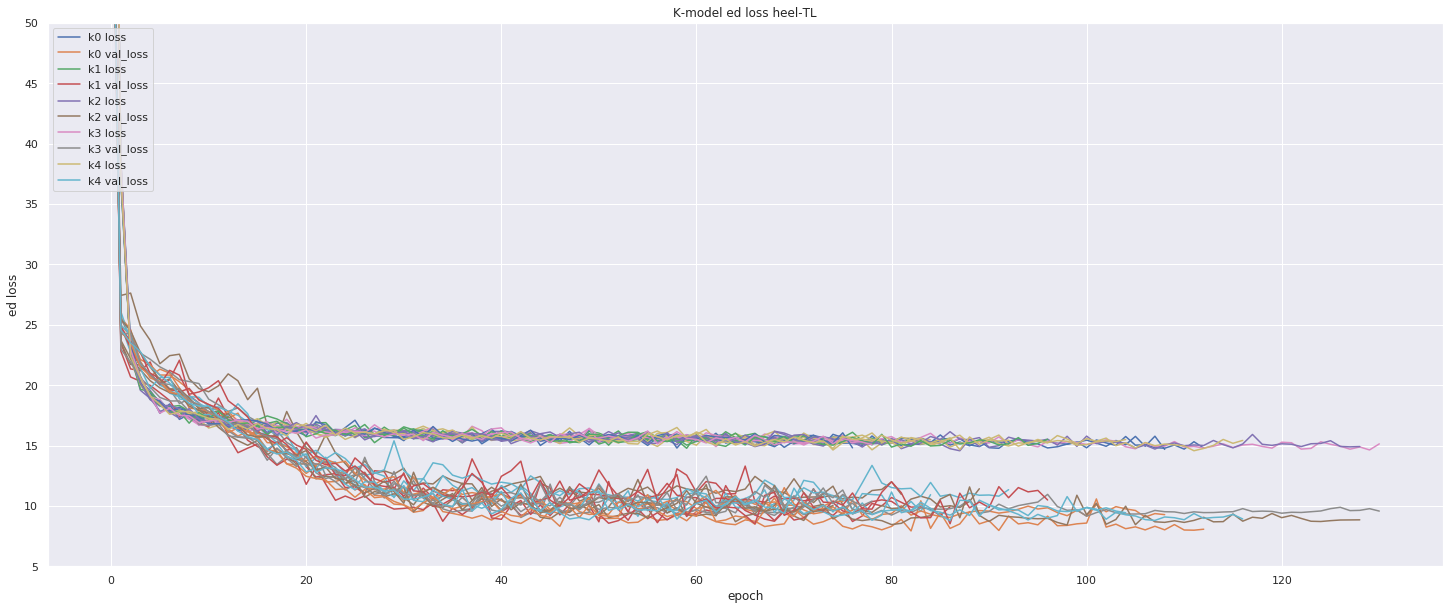

In [105]:
# Sum plot losses heel-tl

plt.figure(figsize=(25, 10))

for k in range(KFlodNum):

    plt.plot(history_heel[k].history['loss'])
    plt.plot(history_heel[k].history['val_loss'])

    
plt.title('K-model ed loss heel-TL')
plt.ylabel('ed loss'), plt.ylim(5, 50)# for too large loss
plt.xlabel('epoch')
plt.legend(['k0 loss', 'k0 val_loss', 'k1 loss', 'k1 val_loss', 'k2 loss', 'k2 val_loss', 
            'k3 loss', 'k3 val_loss', 'k4 loss', 'k4 val_loss'], loc='upper left') 
# plt.show()

# save plot : comment plo.show in jupyter notebook.
plt.savefig(f'{log_dir_name}/{log_dir_name}_heel_Ksum_TL.png', bbox_inches = 'tight')

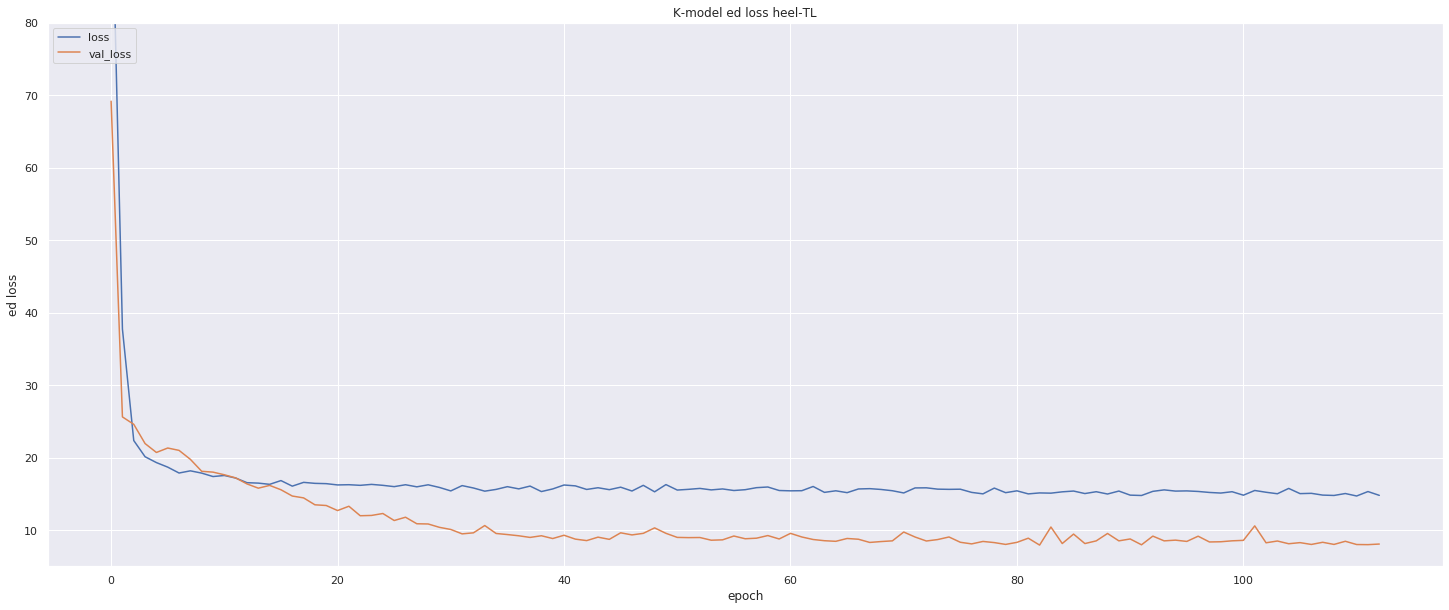

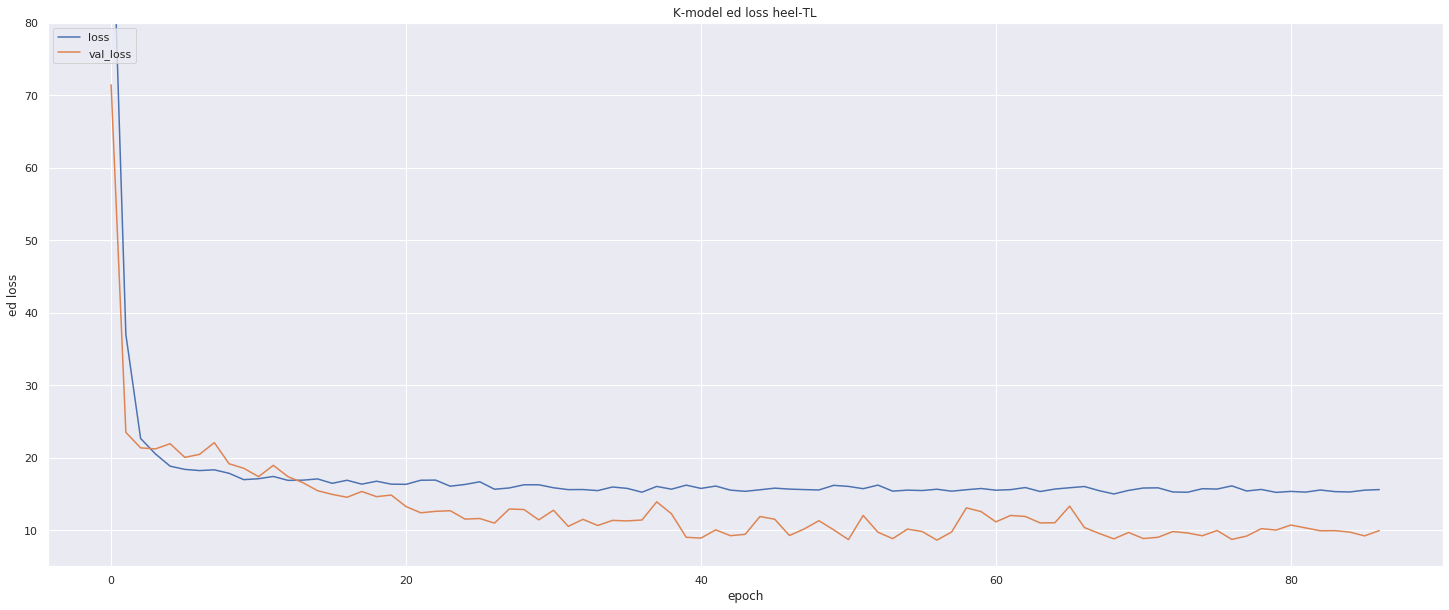

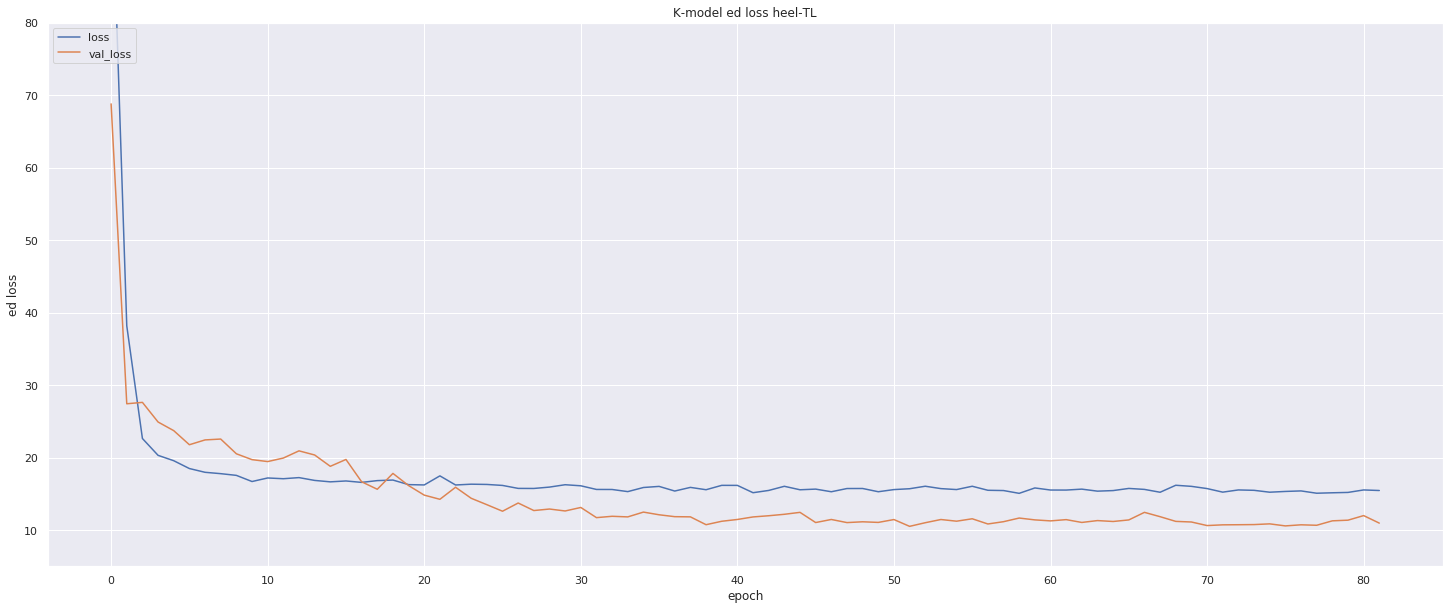

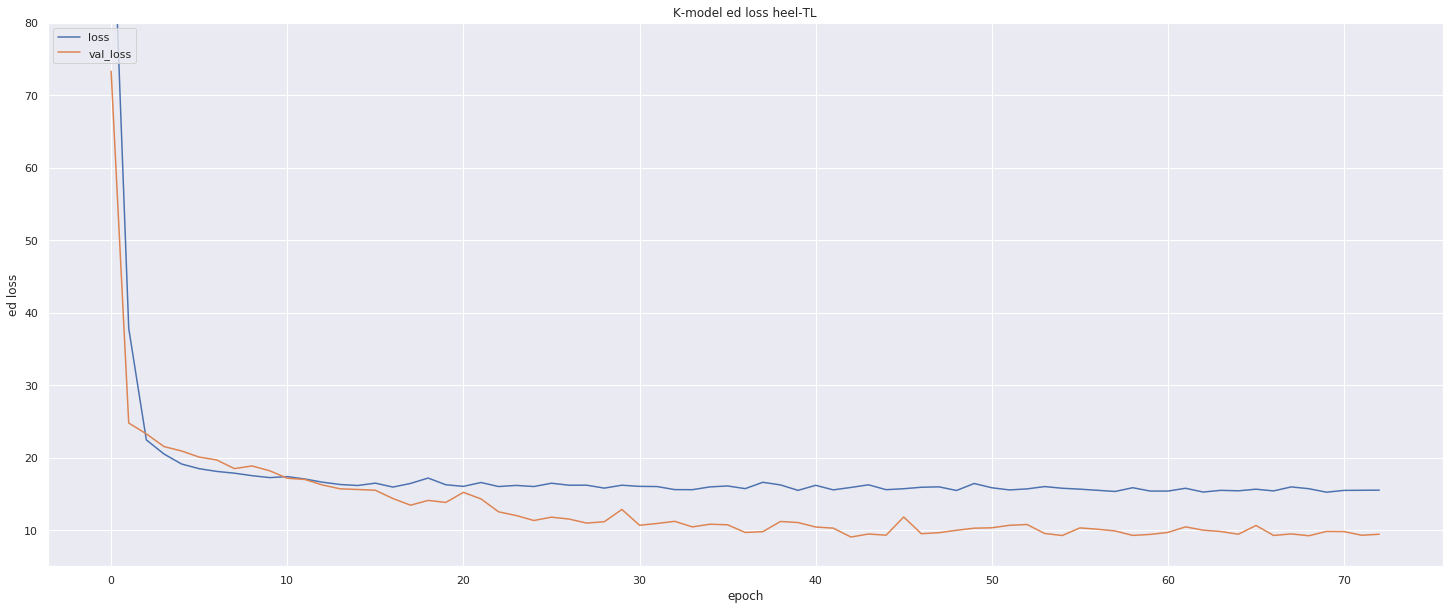

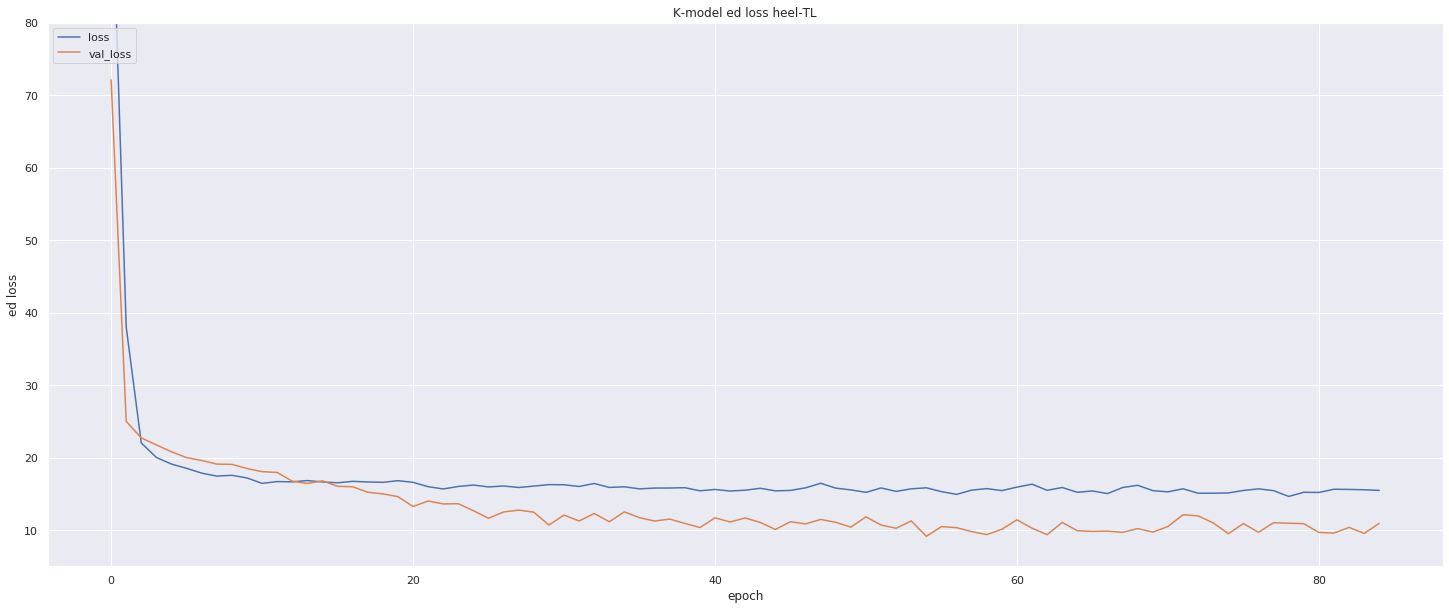

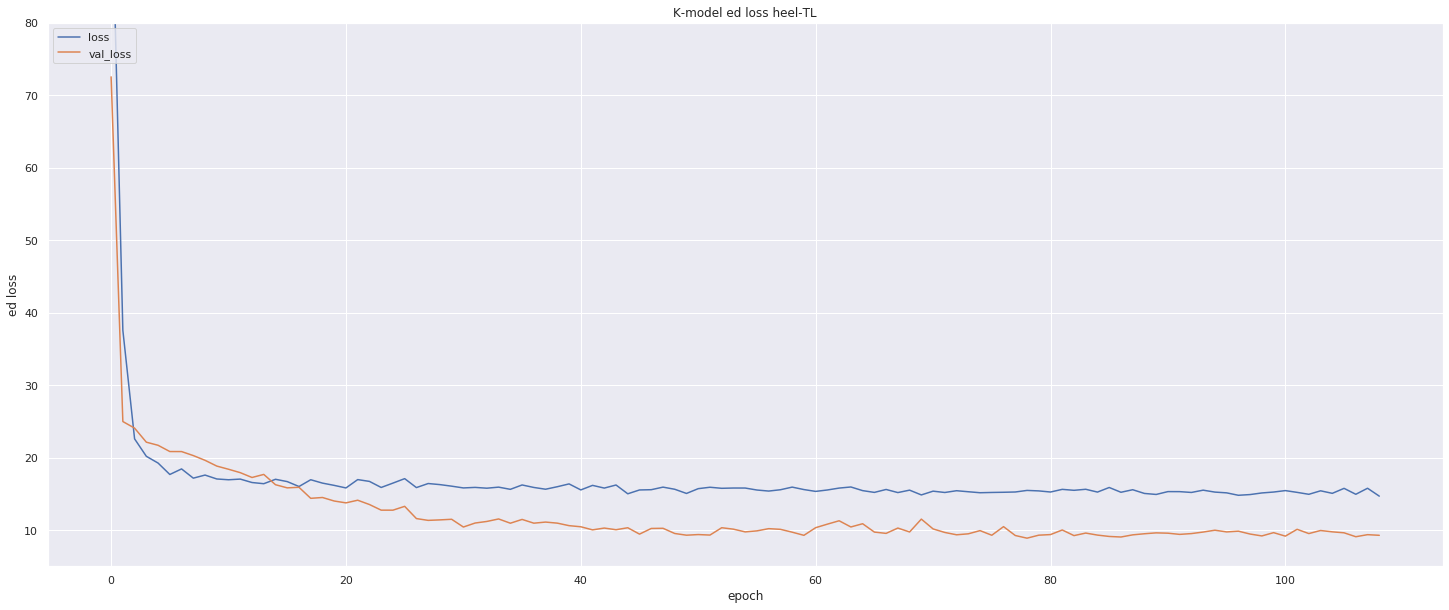

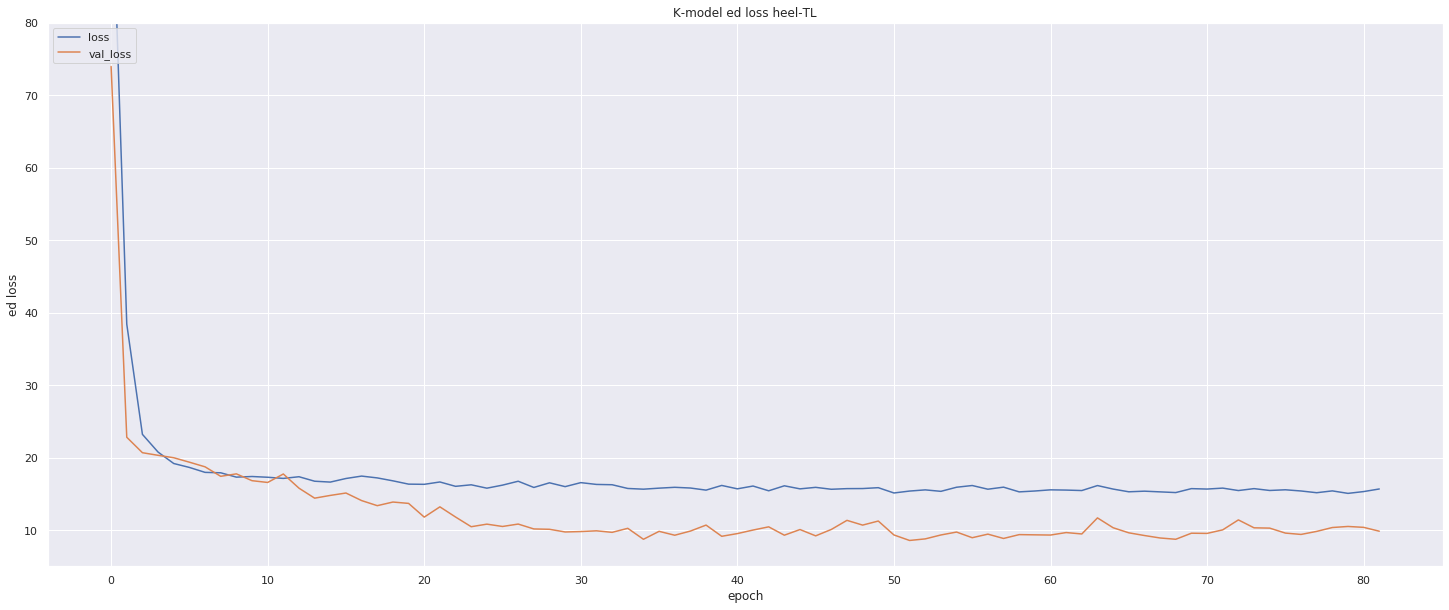

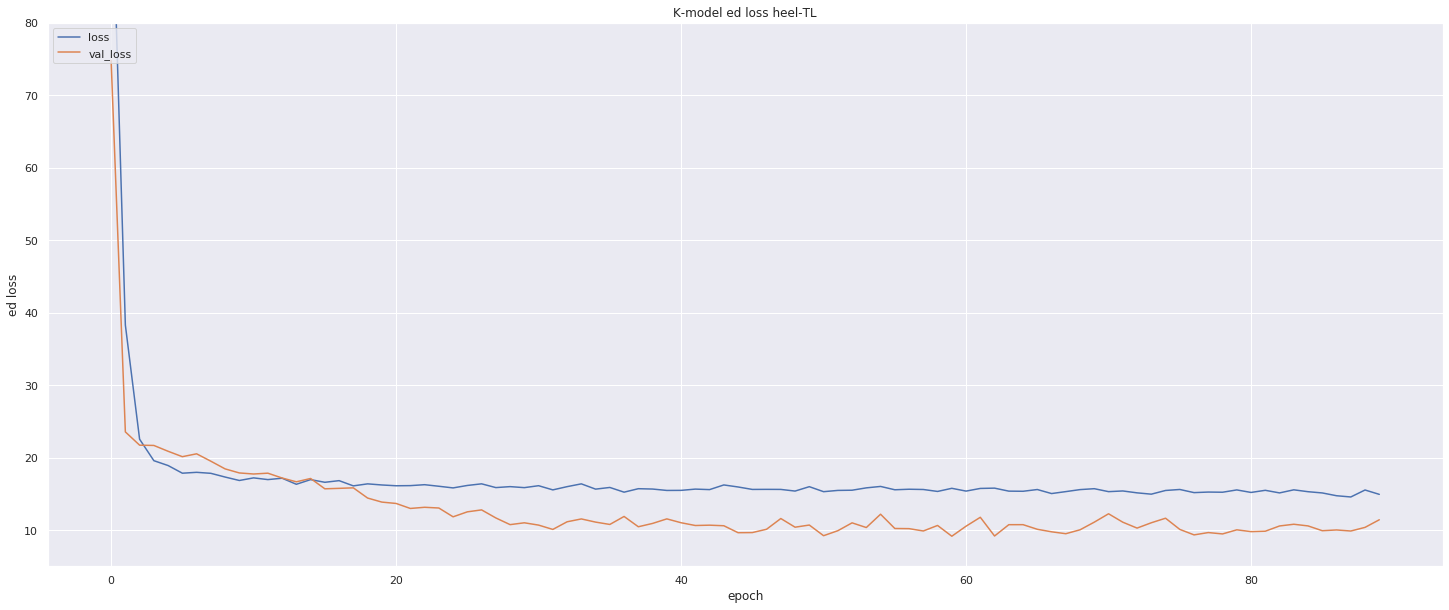

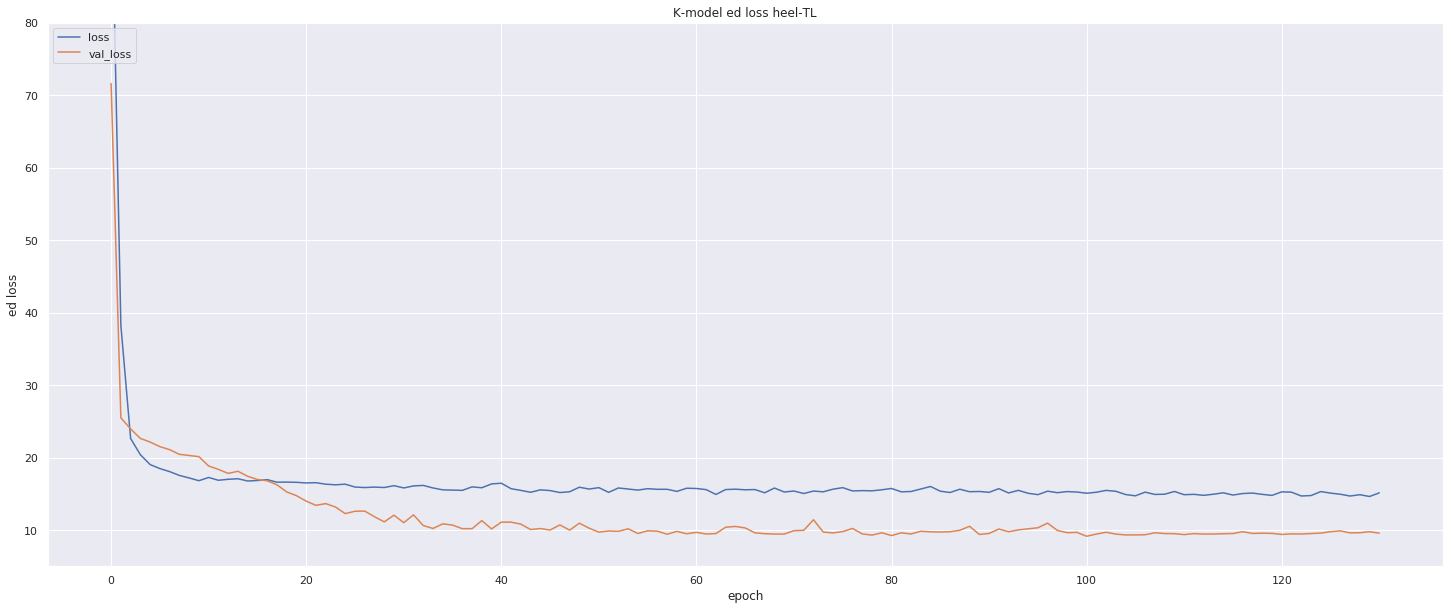

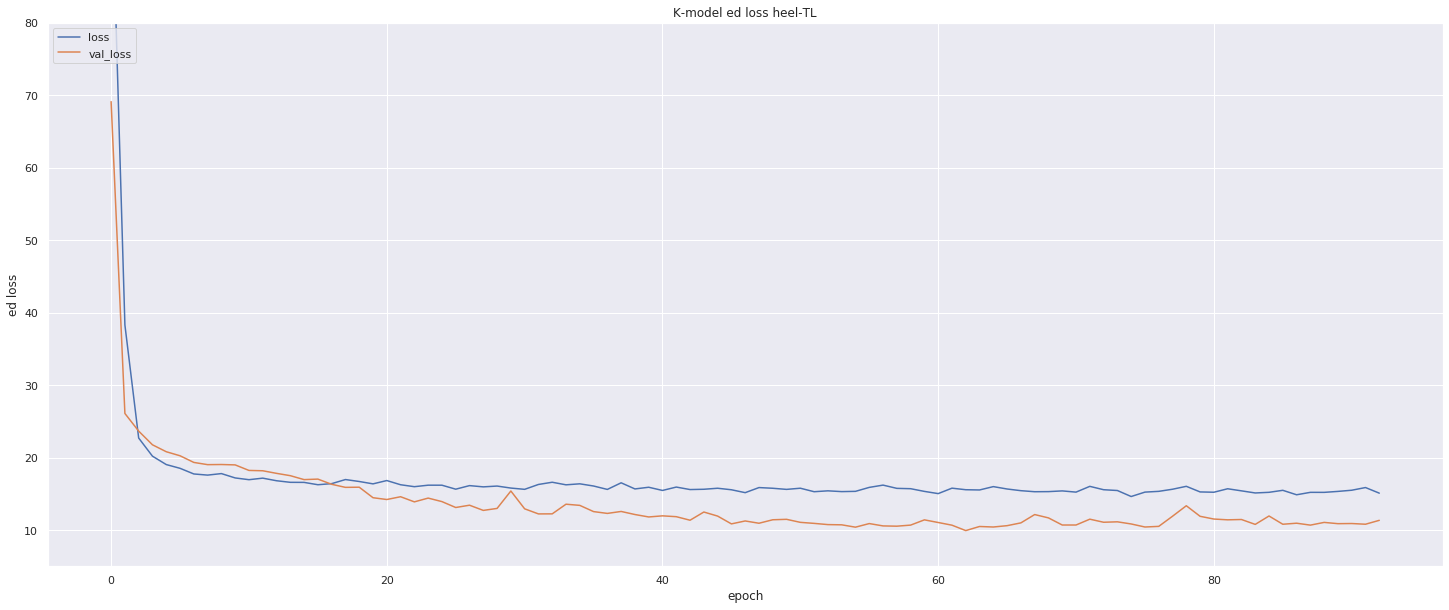

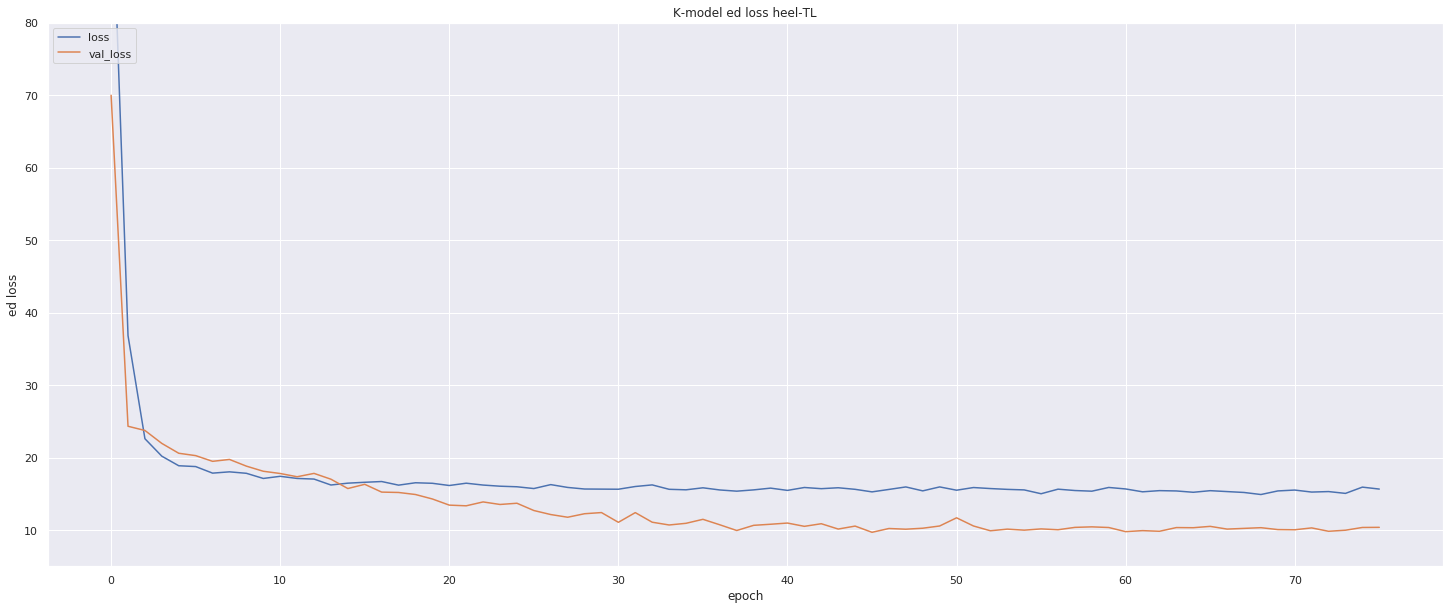

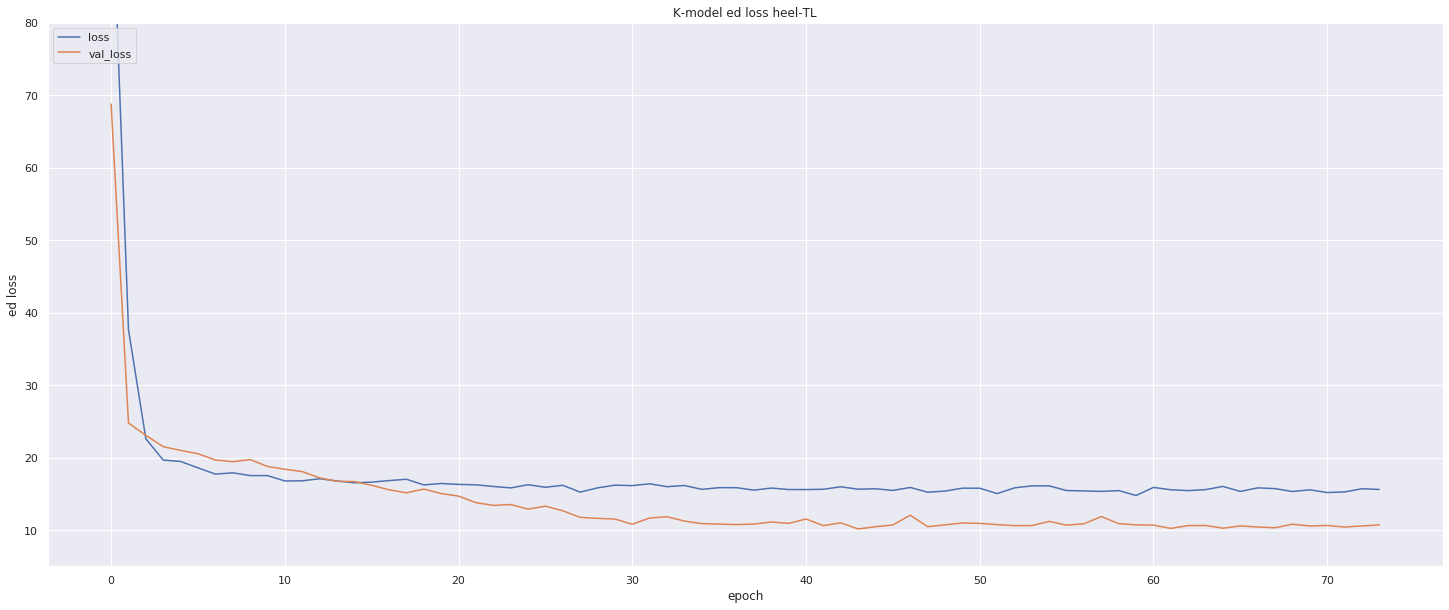

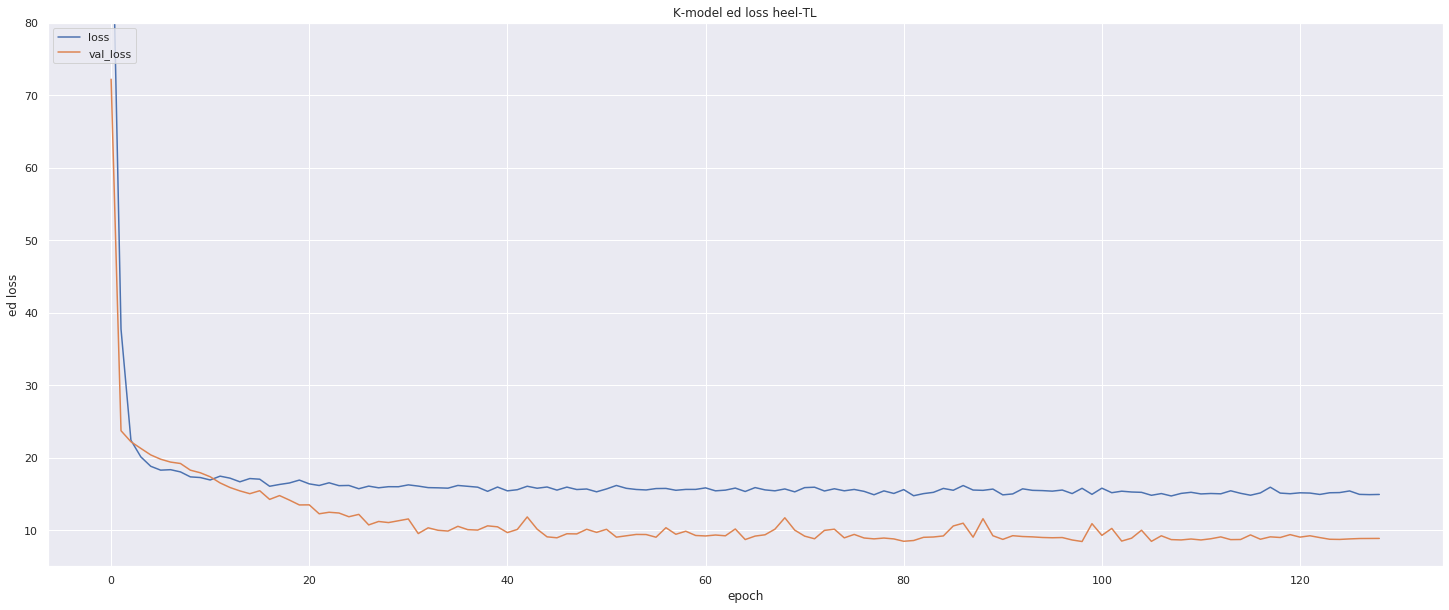

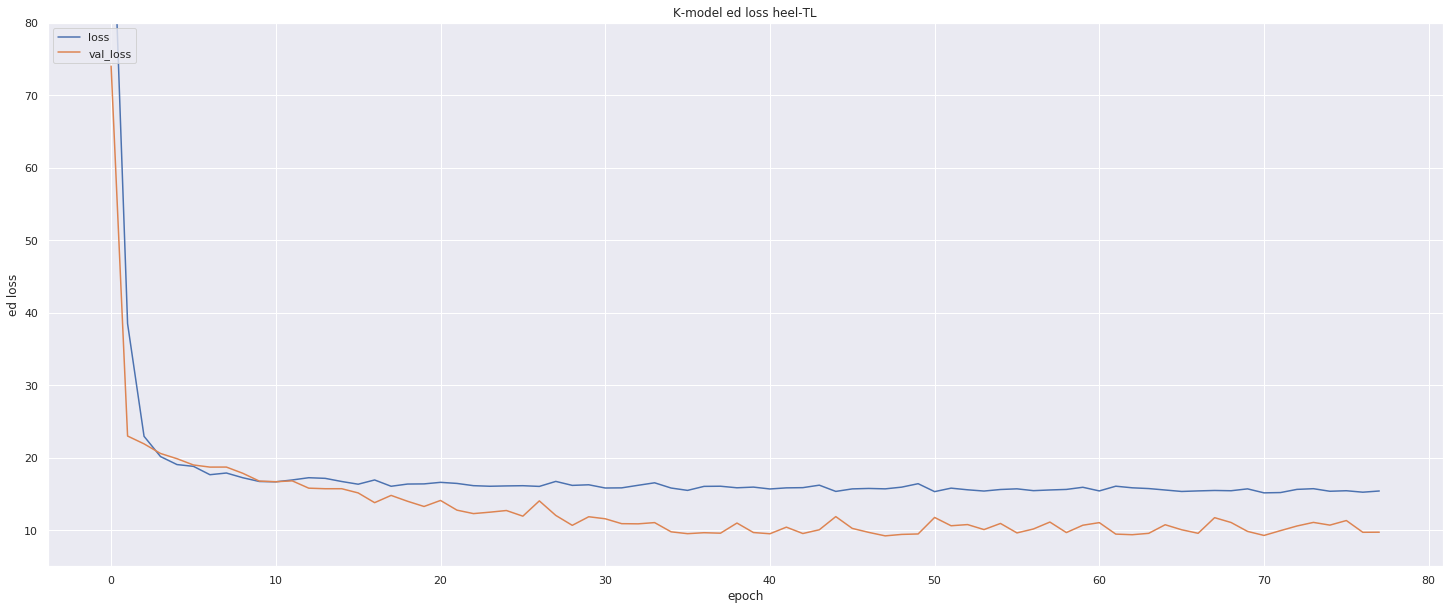

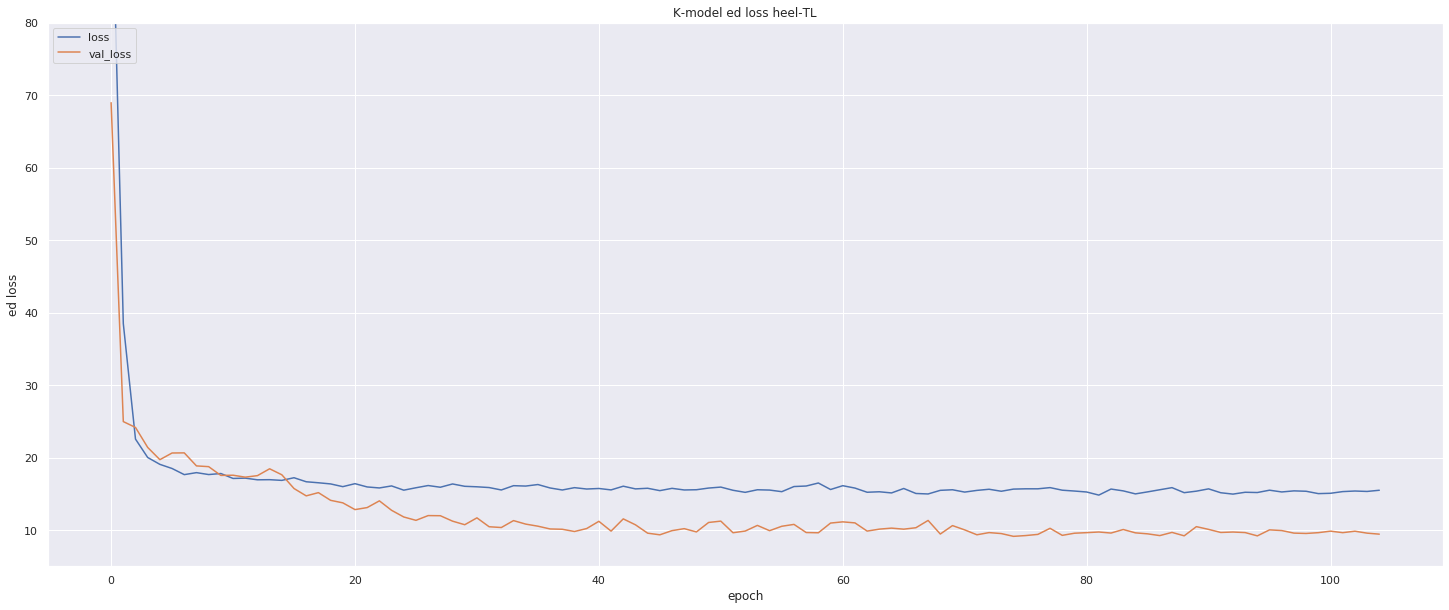

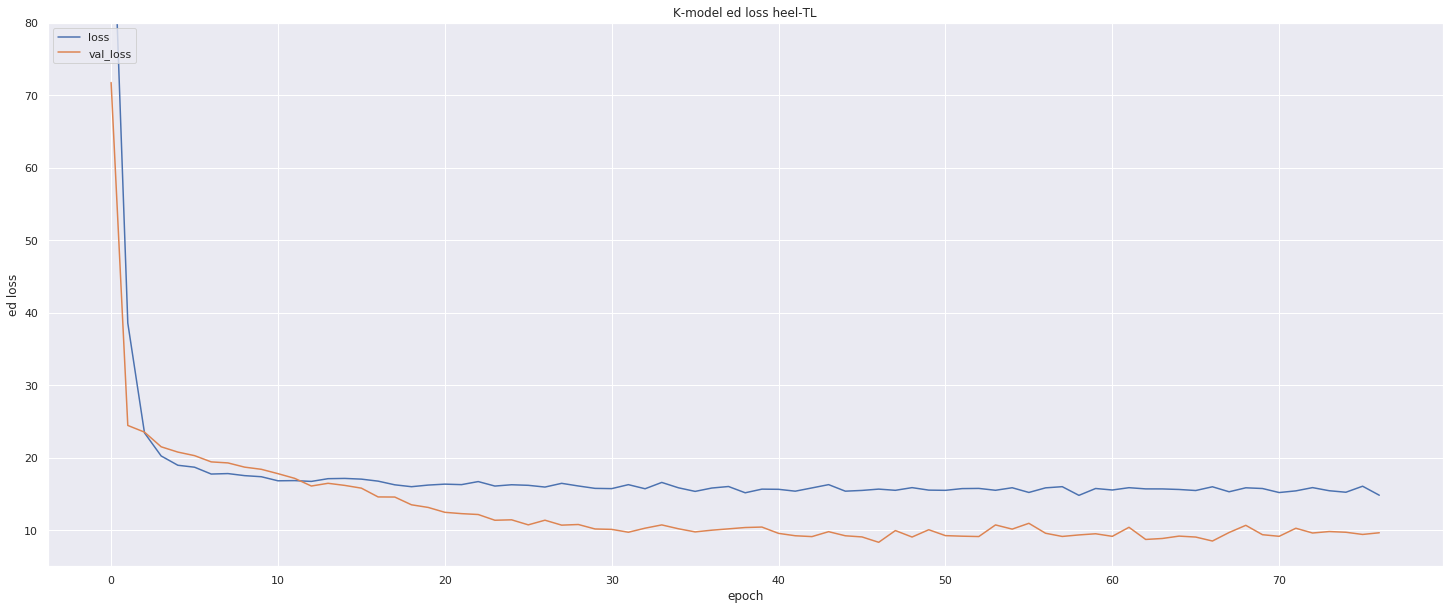

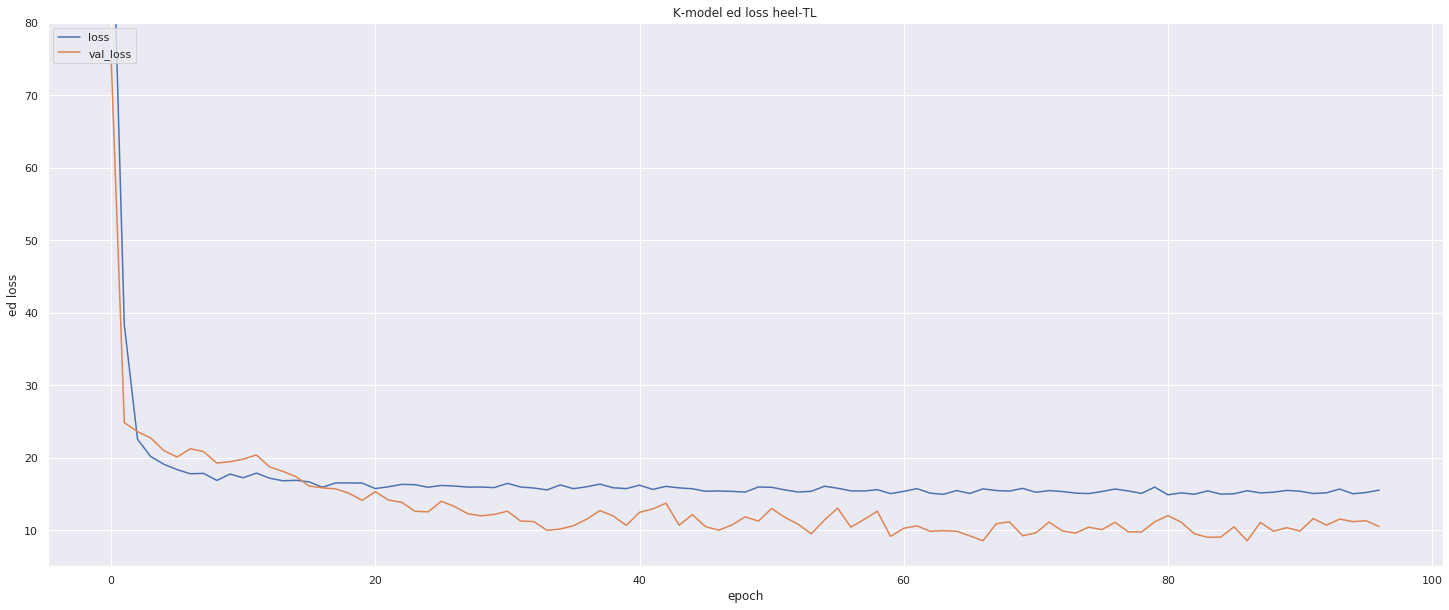

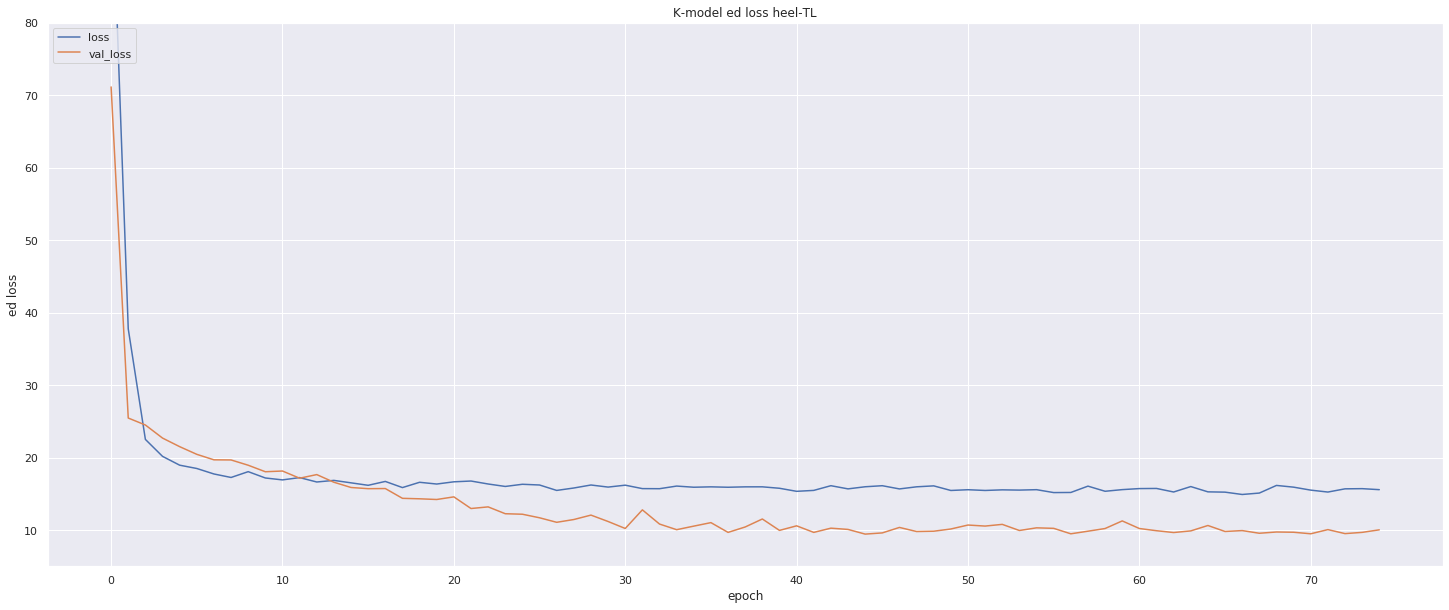

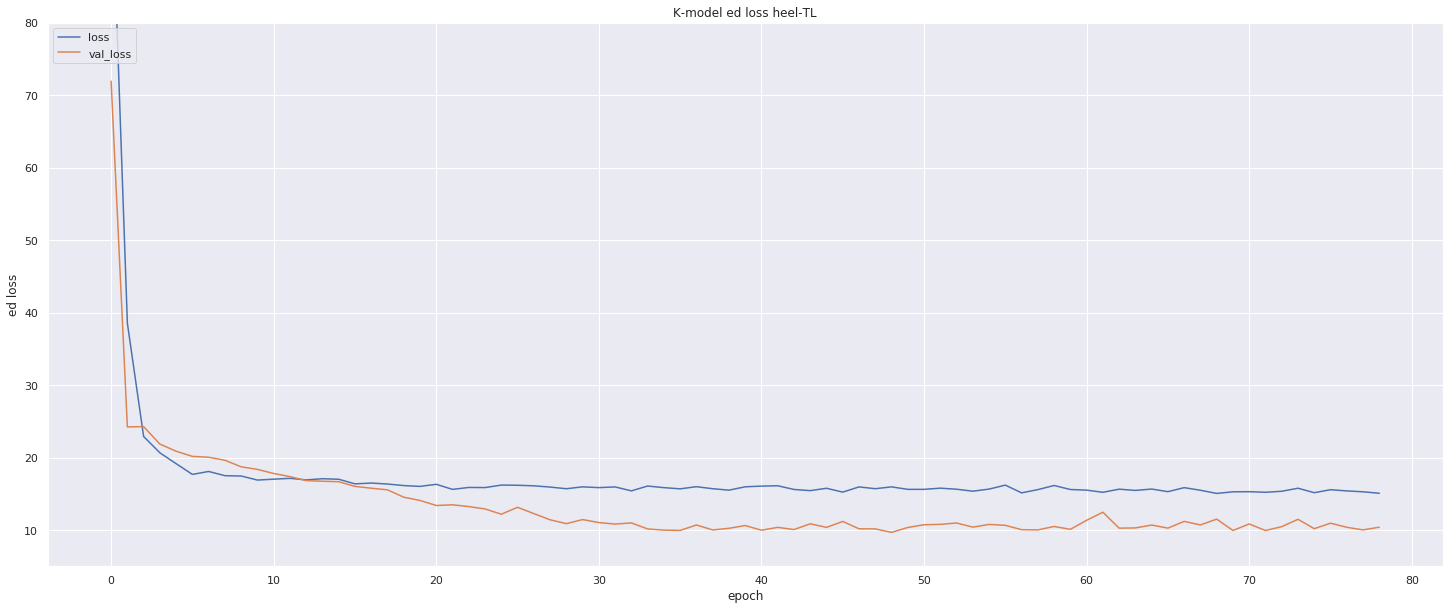

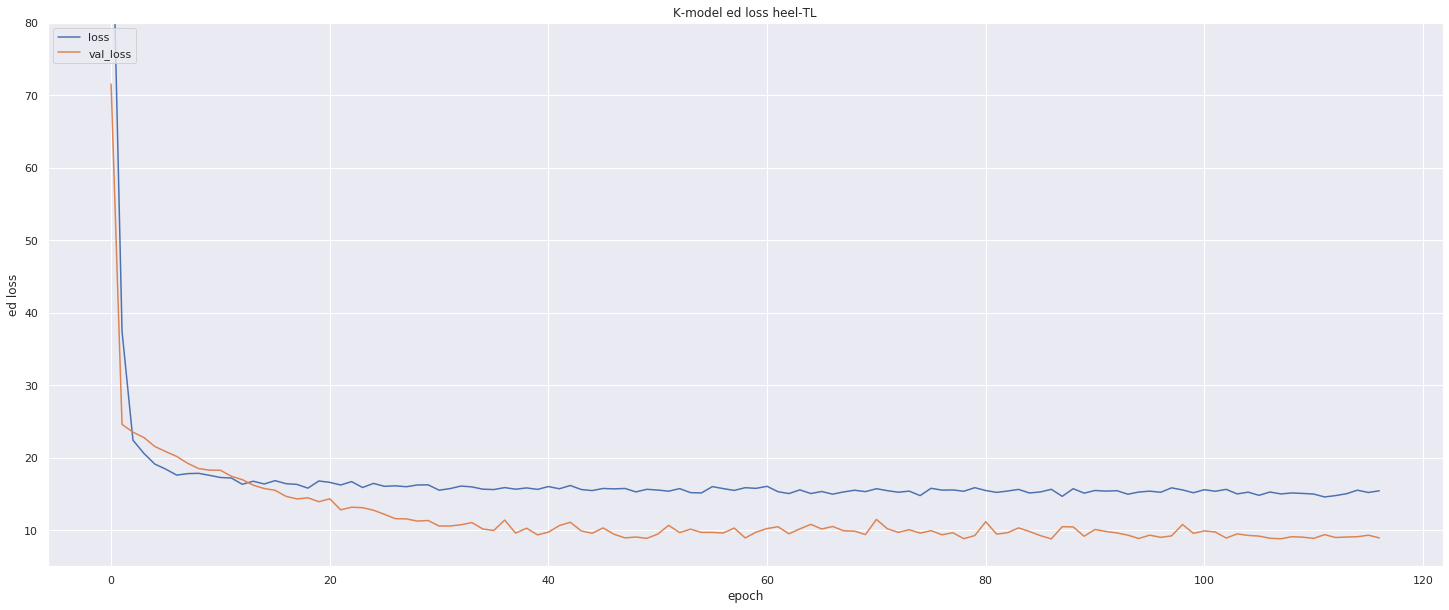

In [106]:
# Single plot loss heel-tl

for k in range(KFlodNum):
    plt.figure(figsize=(25, 10))
    plt.plot(history_heel[k].history['loss'])
    plt.plot(history_heel[k].history['val_loss'])
    plt.title('K-model ed loss heel-TL')
    plt.ylabel('ed loss'), plt.ylim(5, 80)# for too large loss
    plt.xlabel('epoch')
    plt.legend(['loss', 'val_loss'], loc='upper left') 
    # plt.show()

    # save plot : comment plo.show in jupyter notebook.
    def get_valloss(his_v_l):   
        return np.min(his_v_l), np.argmin(his_v_l)

    vl, ep = get_valloss(history_heel[k].history['val_loss'])
    plt.savefig(f'{log_dir_name}/{log_dir_name}_heel_K{k}_TL_clr_ed{round(vl,4)}@{ep}.png', bbox_inches = 'tight')

K:0
K:1
K:2
K:3
K:4
K:5
K:6
K:7
K:8
K:9
K:10
K:11
K:12
K:13
K:14
K:15
K:16
K:17
K:18
K:19


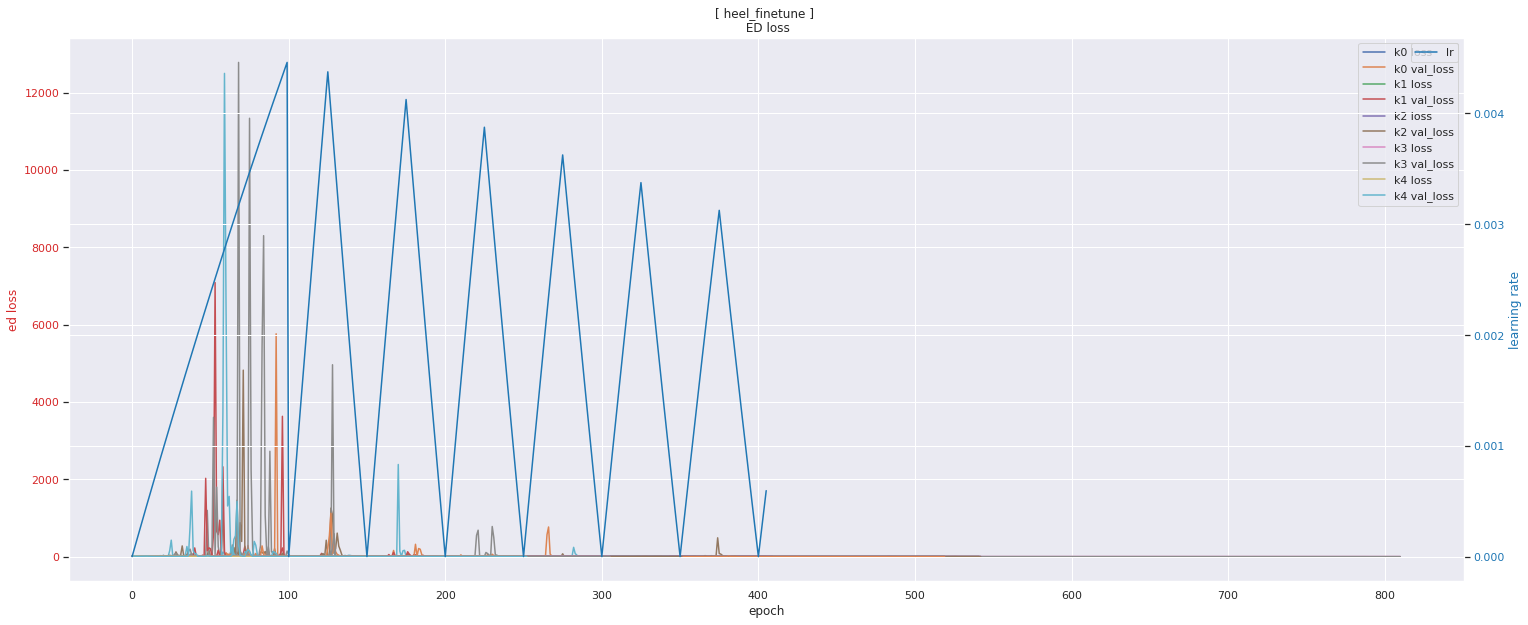

In [107]:
# check the loos the model trained.

def get_valloss(his_v_l):  
    return np.min(his_v_l), np.argmin(his_v_l)

# t_vl = []
h_vl = []
for k in range(KFlodNum):
    print(f'K:{k}')
#     t_v, _ = get_valloss(history_toe_finetune[k].history['val_loss'])
    h_v, _ = get_valloss(history_heel_finetune[k].history['val_loss'])
    
    h_vl.append(h_v)
    
# for different scales (different Y-axes)
# fig, ax1 = plt.subplots()
fig, ax1 = plt.subplots(figsize=(25, 10))

# nice to have this colorful tip.
color = 'tab:red'

ax1.set_title('[ heel_finetune ] \n ED loss')

ax1.set_xlabel('epoch')
ax1.set_ylabel('ed loss', color=color)

for k in range(KFlodNum):

    plt.plot(history_heel_finetune[k].history['loss'])
    plt.plot(history_heel_finetune[k].history['val_loss'])

ax1.tick_params(axis='y', labelcolor=color)
# ax1.legend(['loss', 'val_loss'], loc='upper center') # legend may ocvered by next ax ploting. moved to end.
ax1.legend(['k0 loss', 'k0 val_loss', 'k1 loss', 'k1 val_loss', 'k2 loss', 'k2 val_loss', 
            'k3 loss', 'k3 val_loss', 'k4 loss', 'k4 val_loss'], loc='upper right') 

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('learning rate', color=color)
ax2.plot(history_heel_finetune[0].history['lr'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(['lr'], loc='upper right') 

# plt.show()

# # save plot : comment plo.show in jupyter notebook.
# def get_valloss(his_v_l):   
#     return np.min(his_v_l), np.argmin(his_v_l)

# vl, ep = get_valloss(history_toe_finetune.history['val_loss'])


# t_vl = np.mean(t_vl, axis=0)
h_vl = np.mean(h_vl, axis=0)
plt.savefig(f'{log_dir_name}/{log_dir_name}_heel_ft_Ksum-clr_ed{round(h_vl,4)}.png', bbox_inches = 'tight')

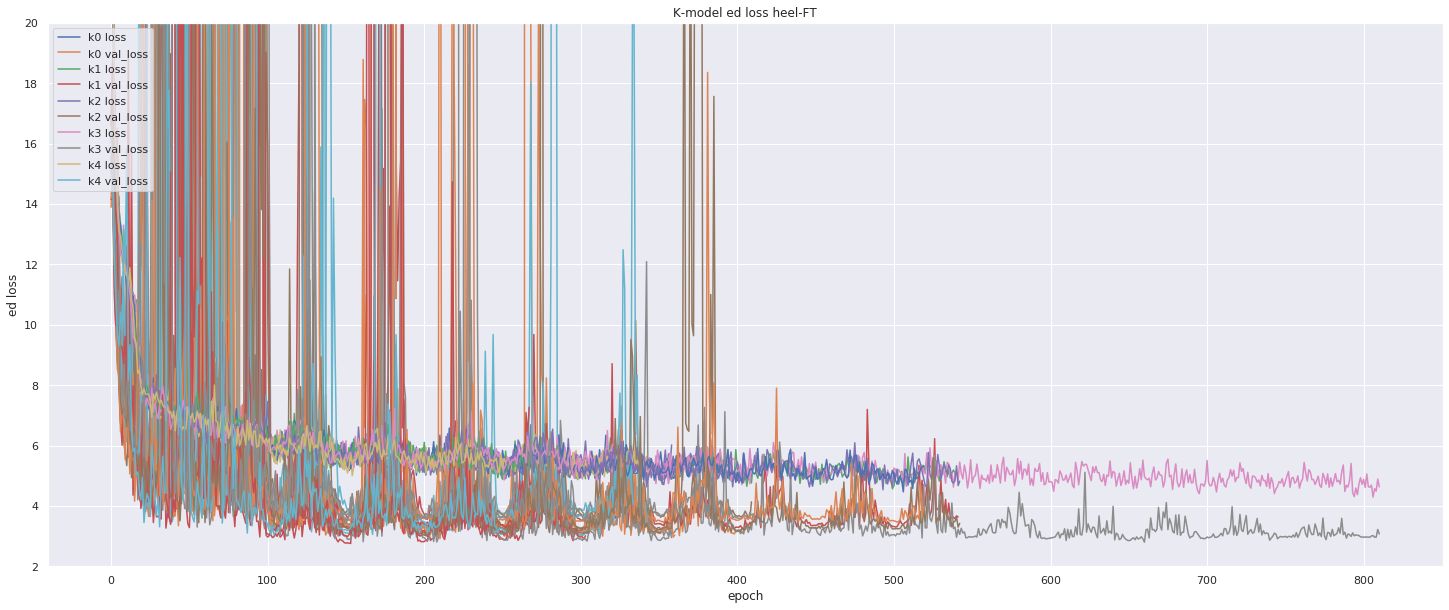

In [108]:
# Sum plot losses heel-ft

plt.figure(figsize=(25, 10))

for k in range(KFlodNum):

    plt.plot(history_heel_finetune[k].history['loss'])
    plt.plot(history_heel_finetune[k].history['val_loss'])

    
plt.title('K-model ed loss heel-FT')
plt.ylabel('ed loss'), plt.ylim(2, 20)# for too large loss
plt.xlabel('epoch')
plt.legend(['k0 loss', 'k0 val_loss', 'k1 loss', 'k1 val_loss', 'k2 loss', 'k2 val_loss', 
            'k3 loss', 'k3 val_loss', 'k4 loss', 'k4 val_loss'], loc='upper left') 
# plt.show()

# save plot : comment plo.show in jupyter notebook.
plt.savefig(f'{log_dir_name}/{log_dir_name}_heel_Ksum_FT.png', bbox_inches = 'tight')

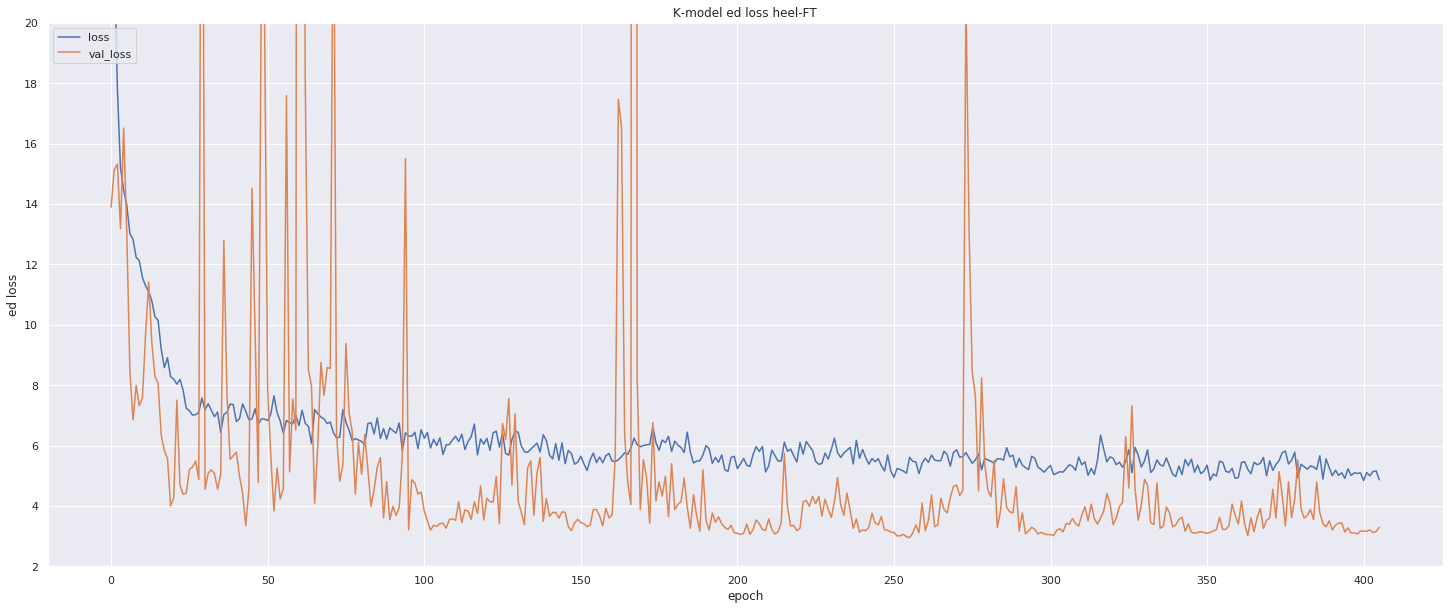

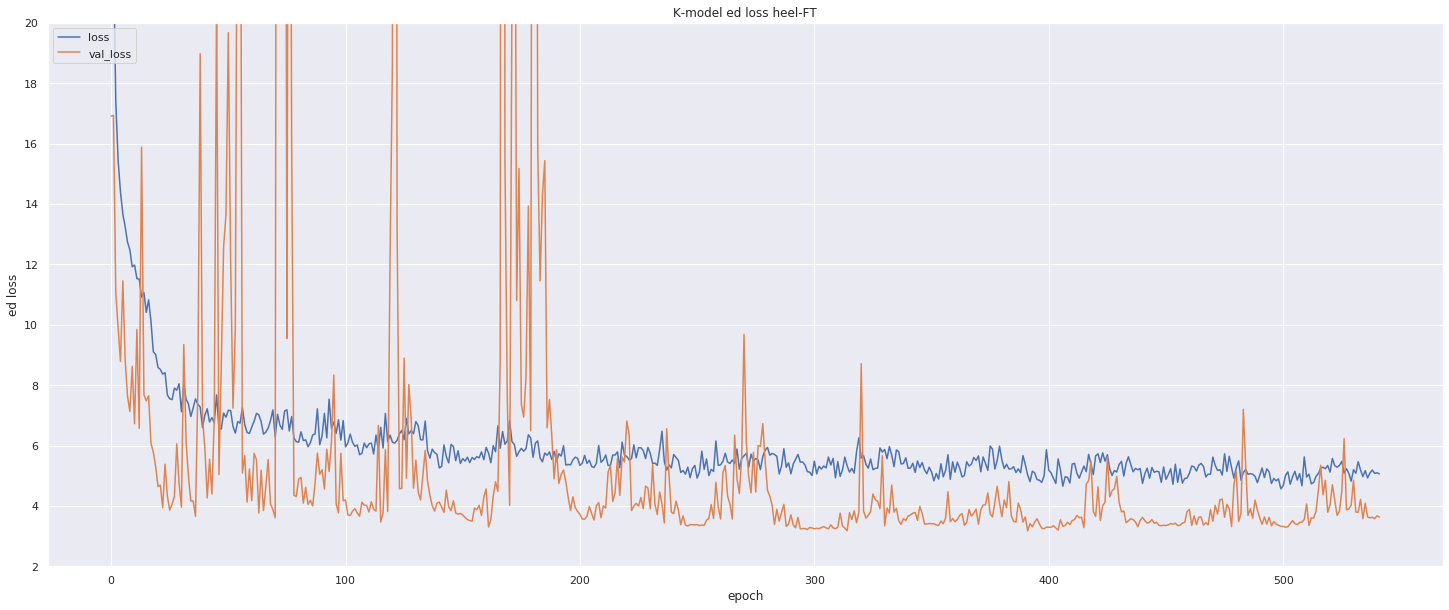

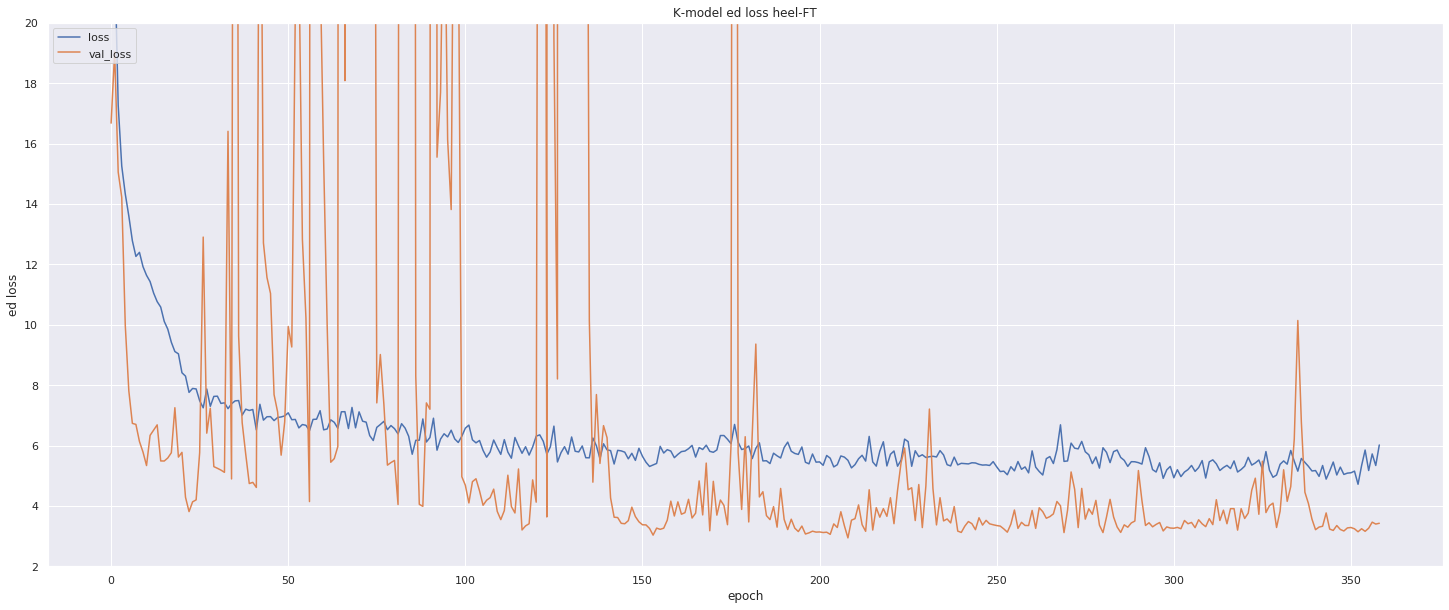

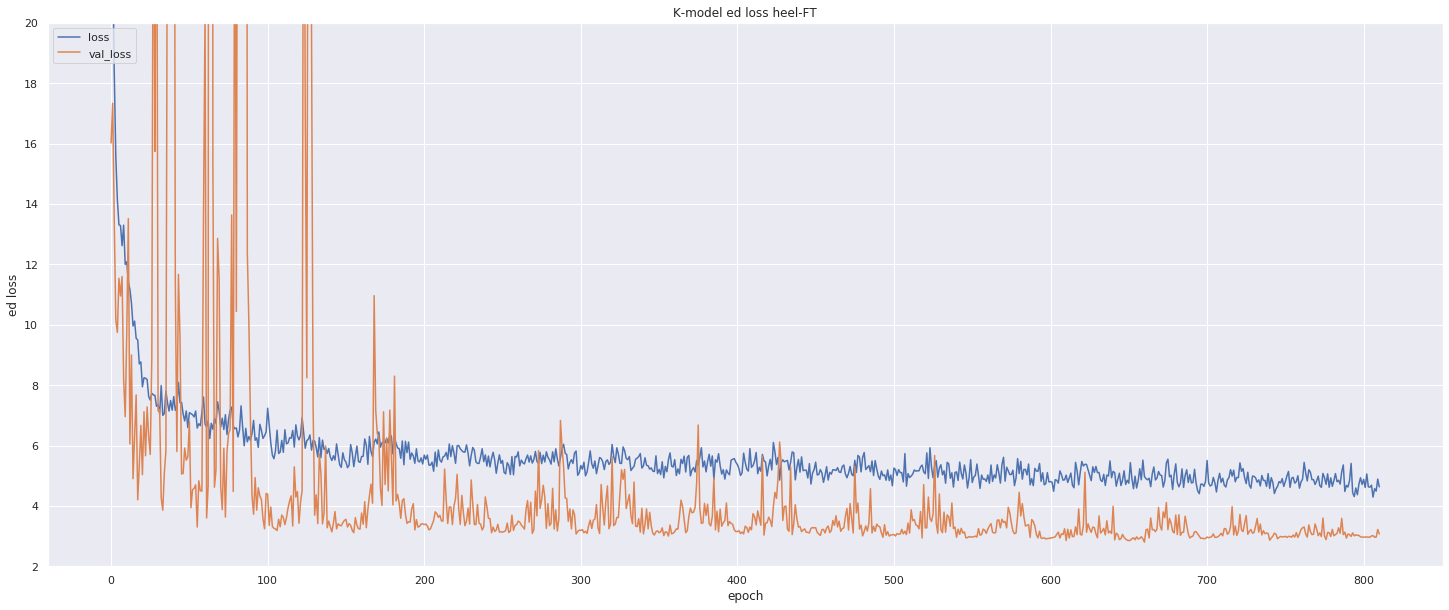

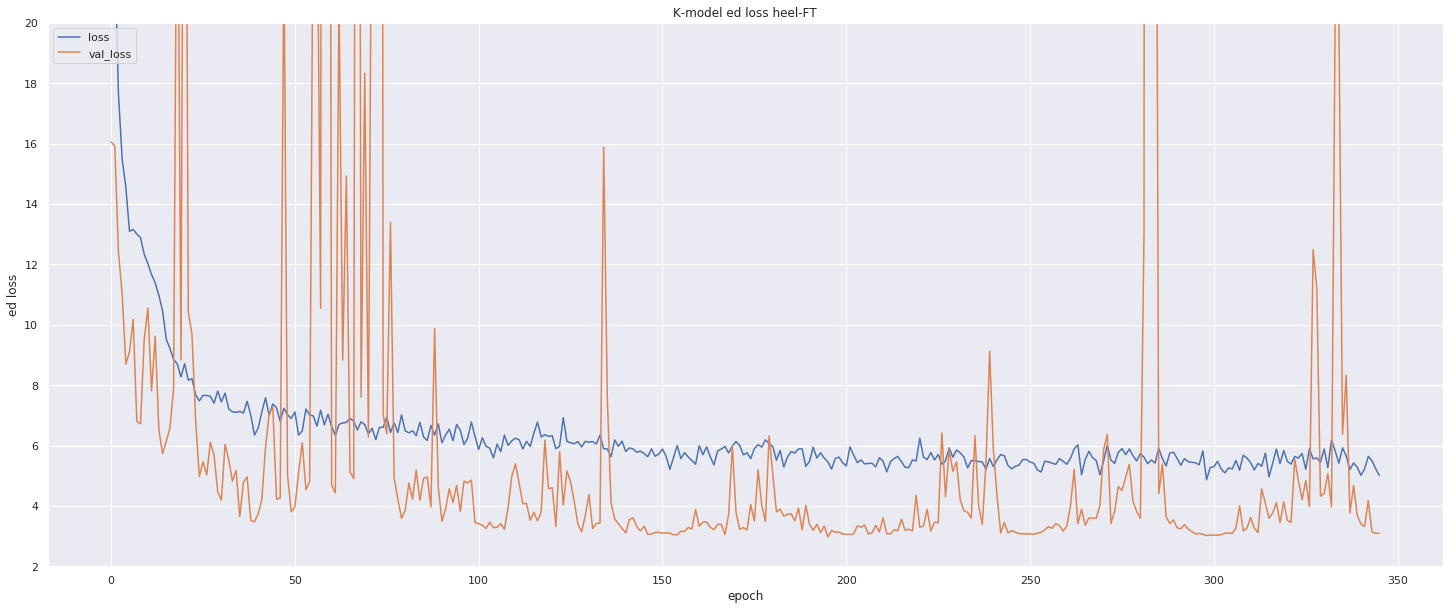

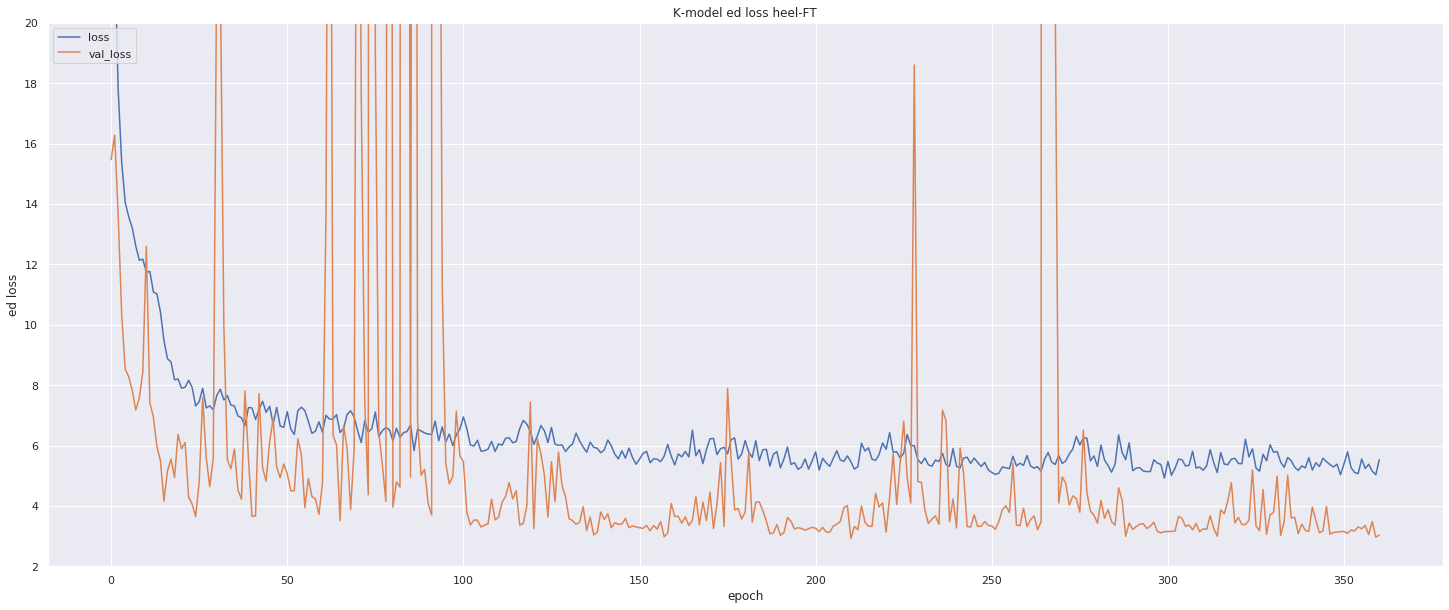

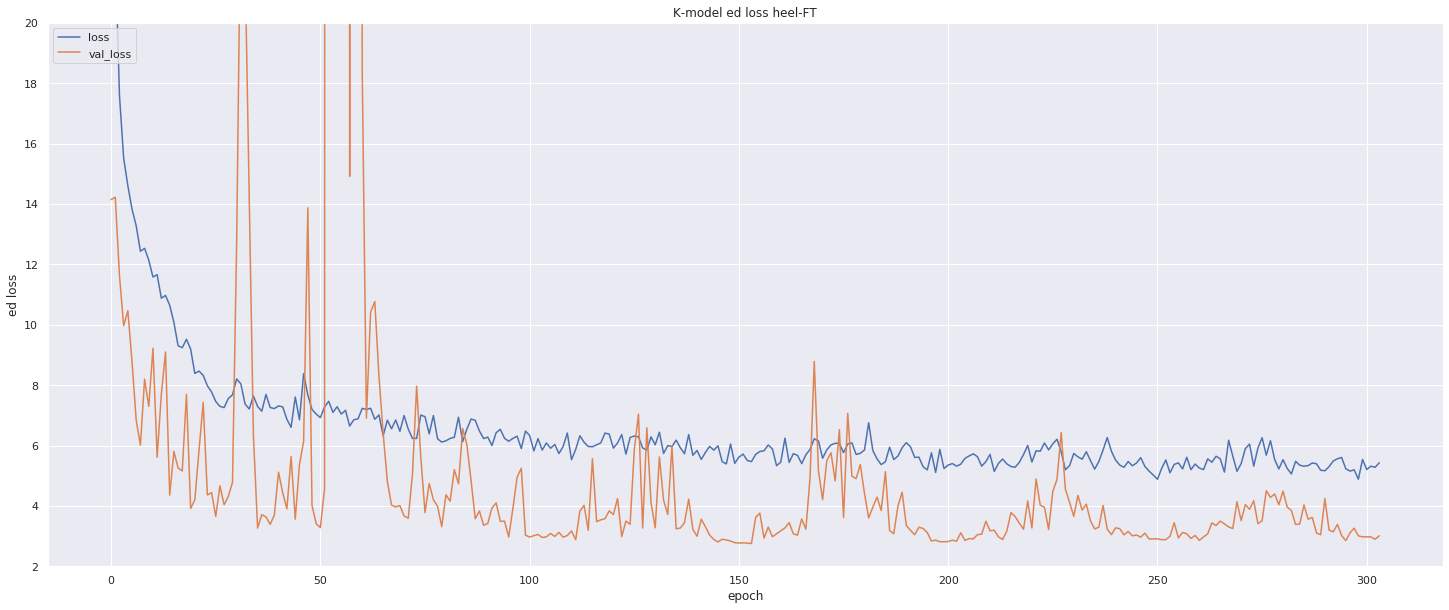

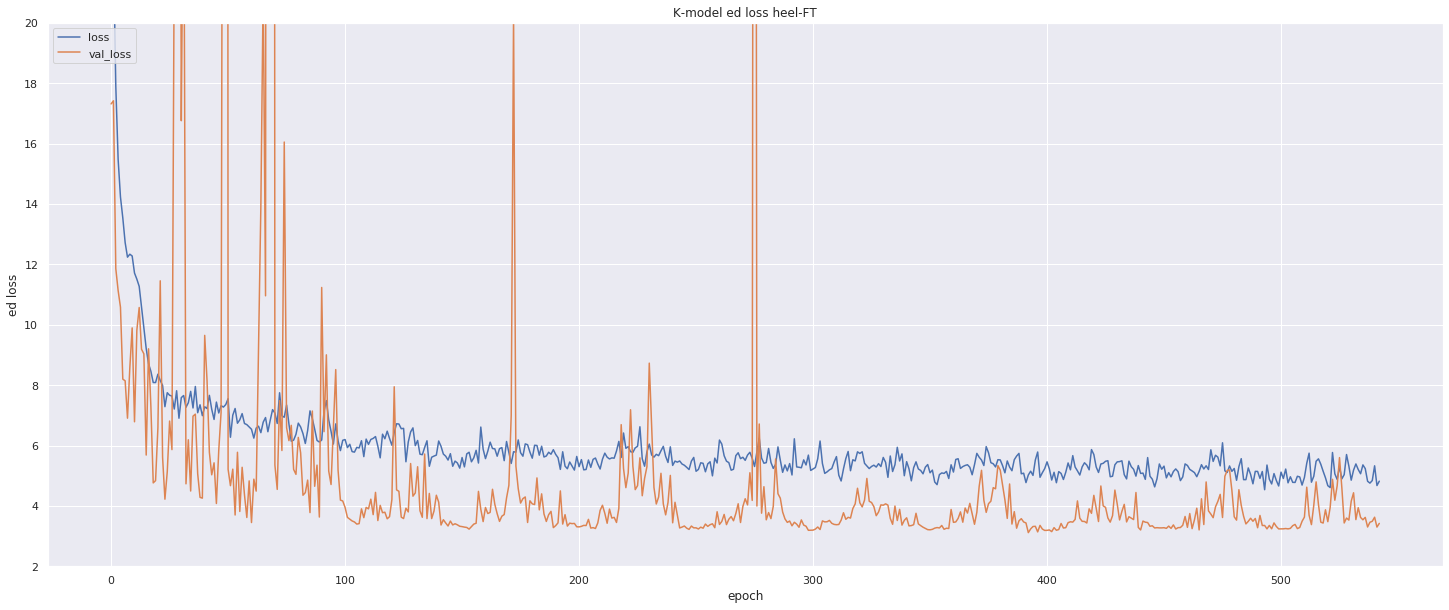

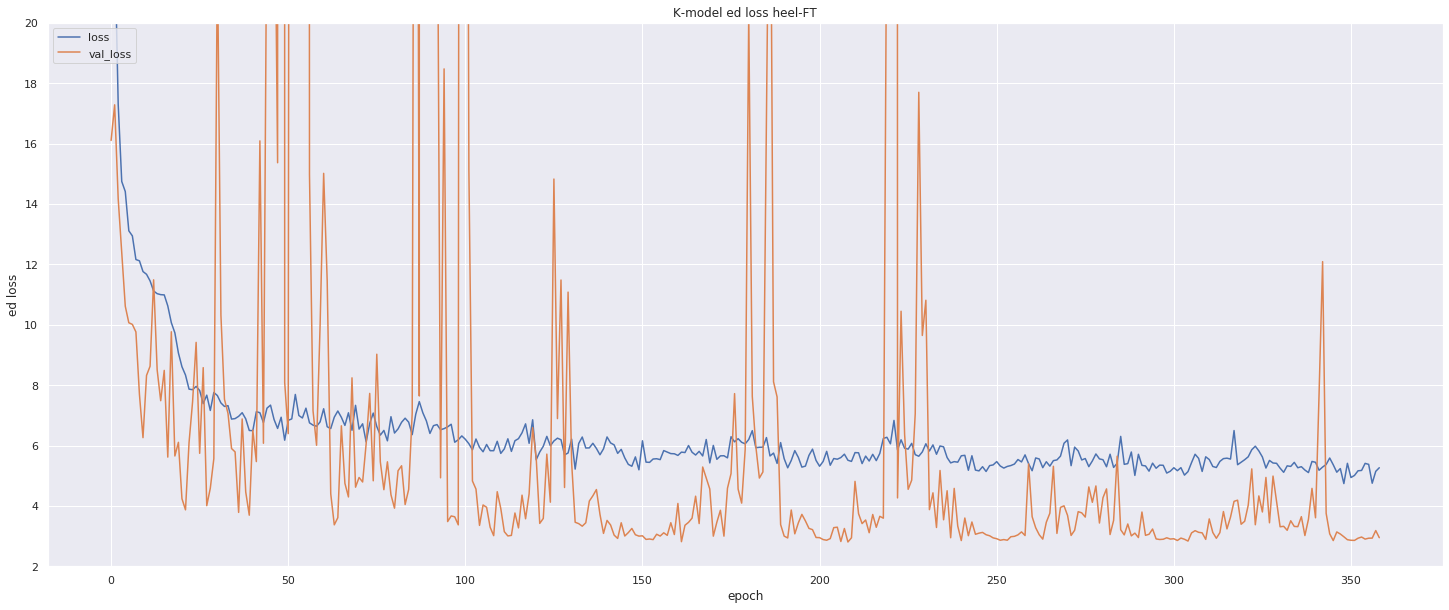

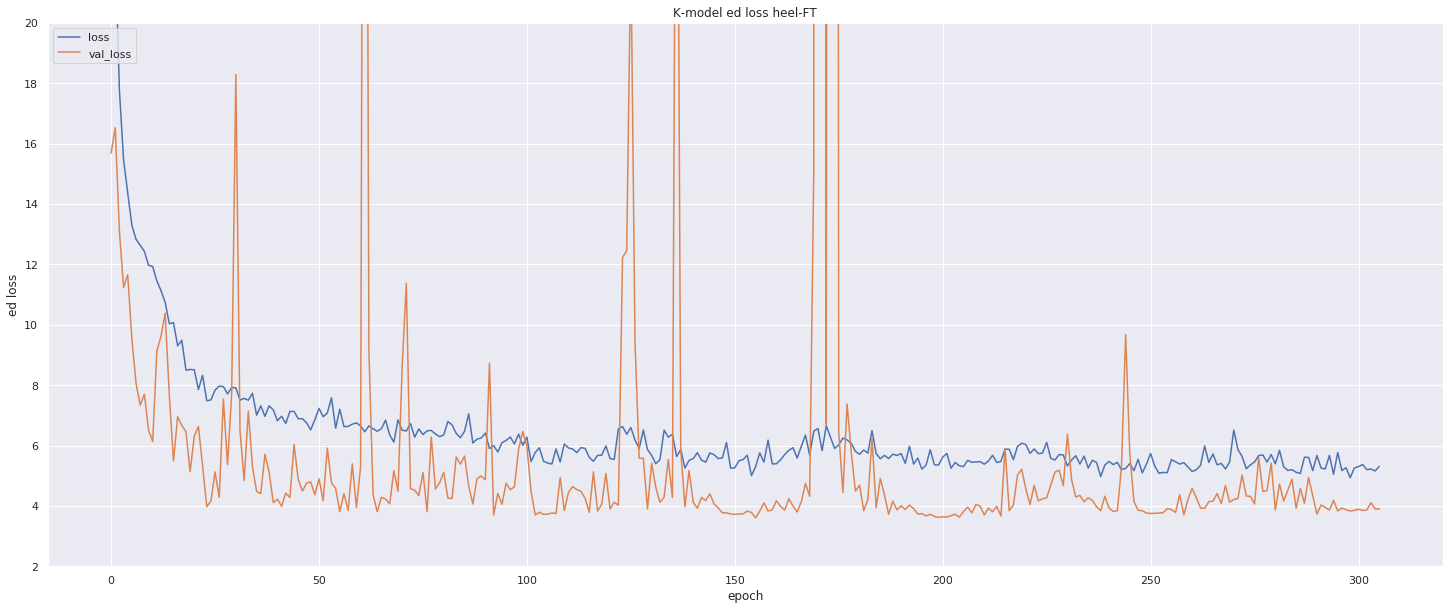

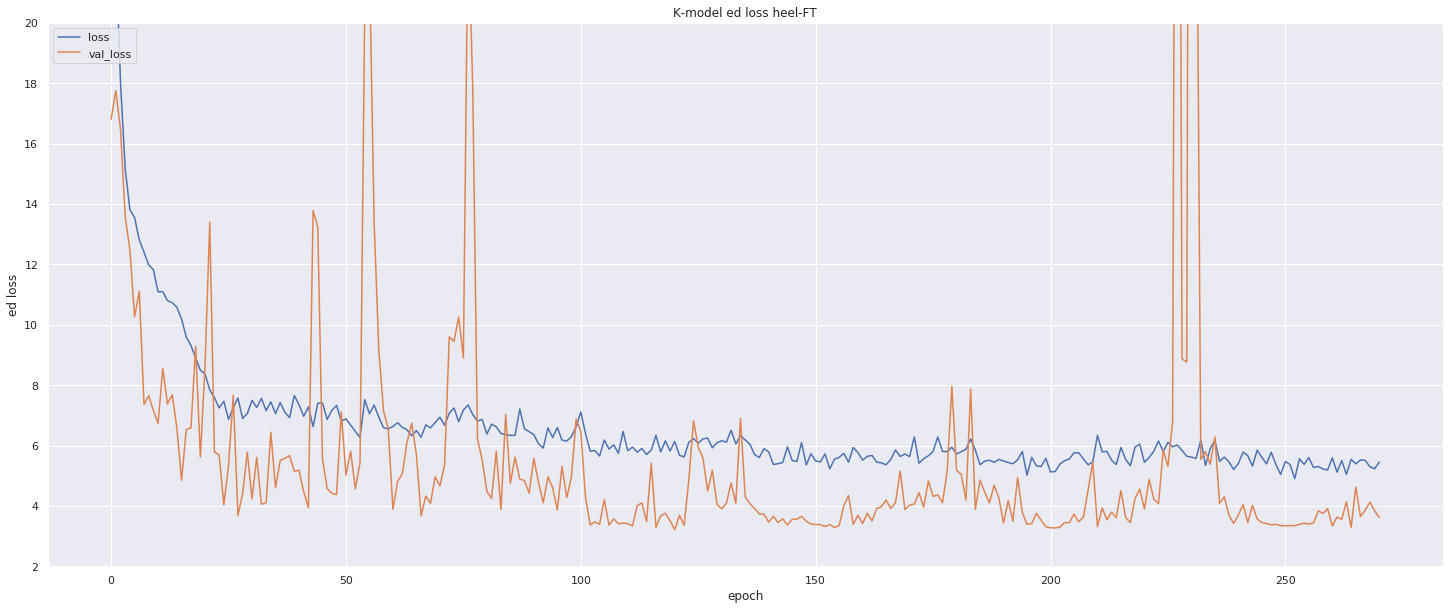

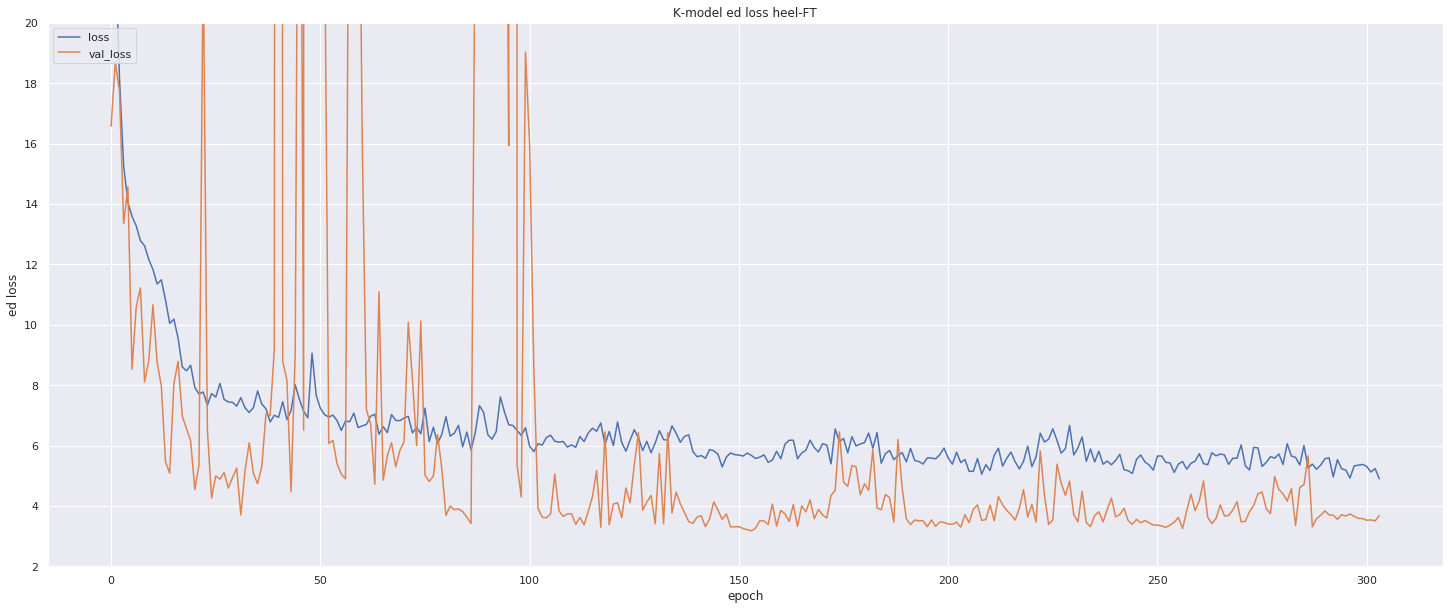

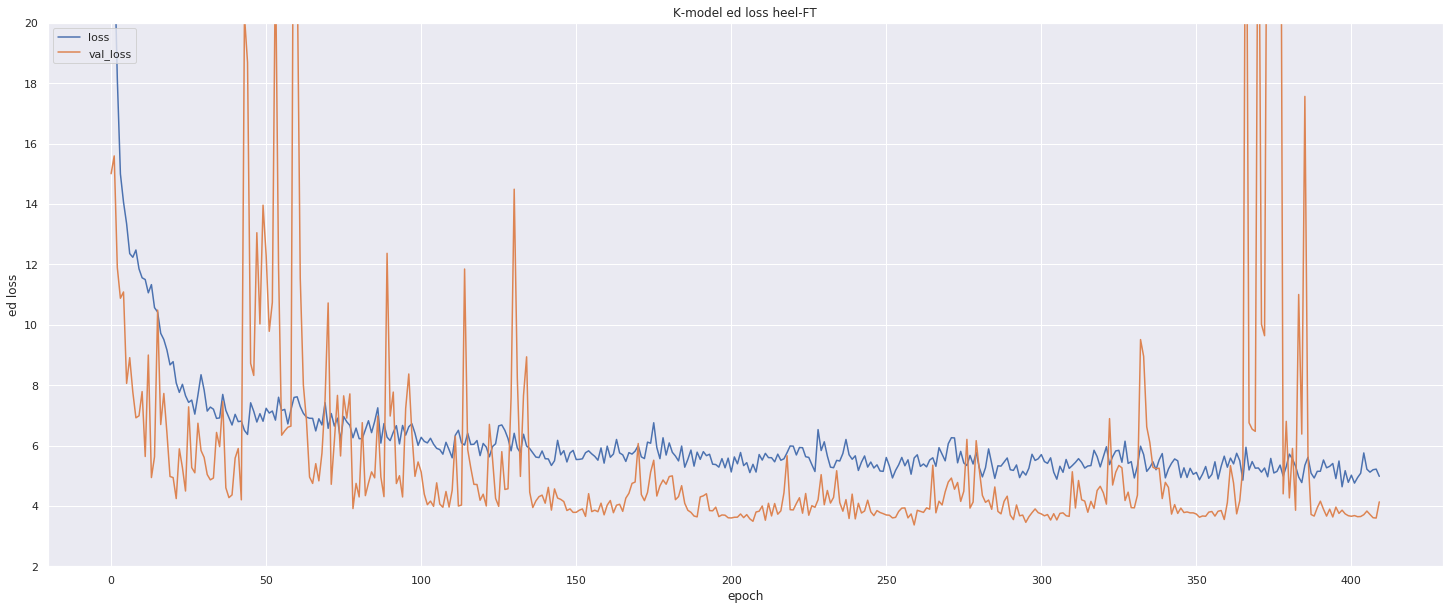

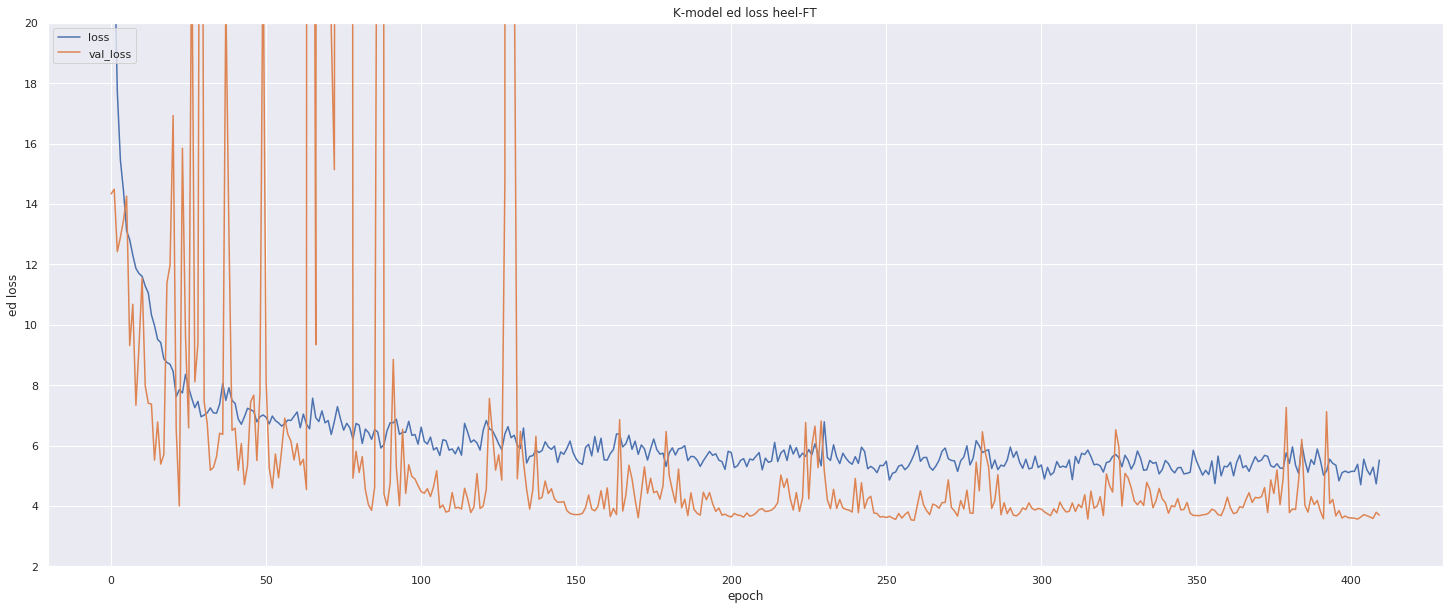

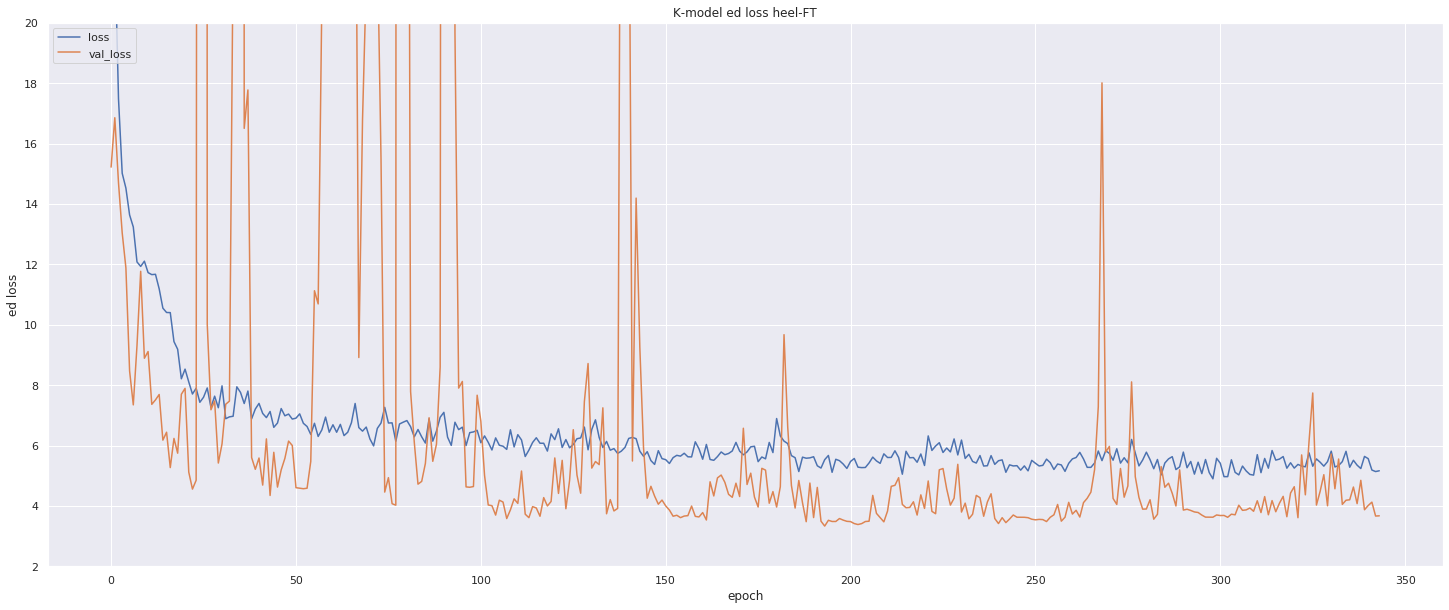

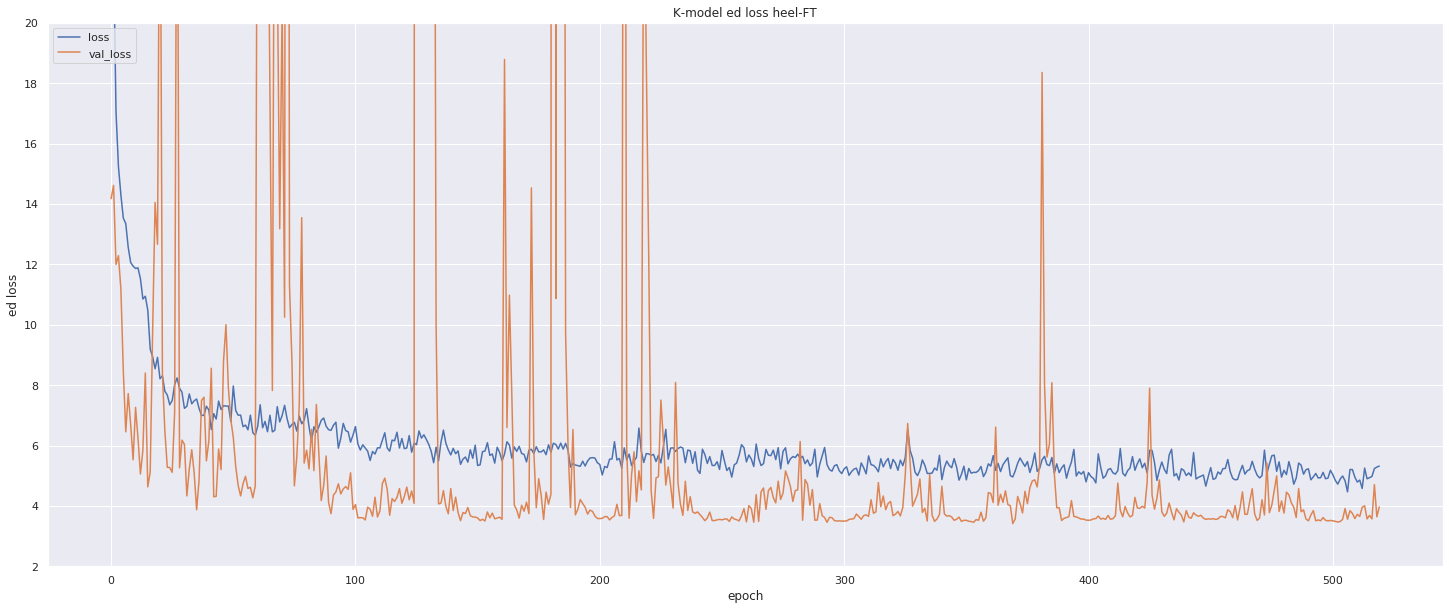

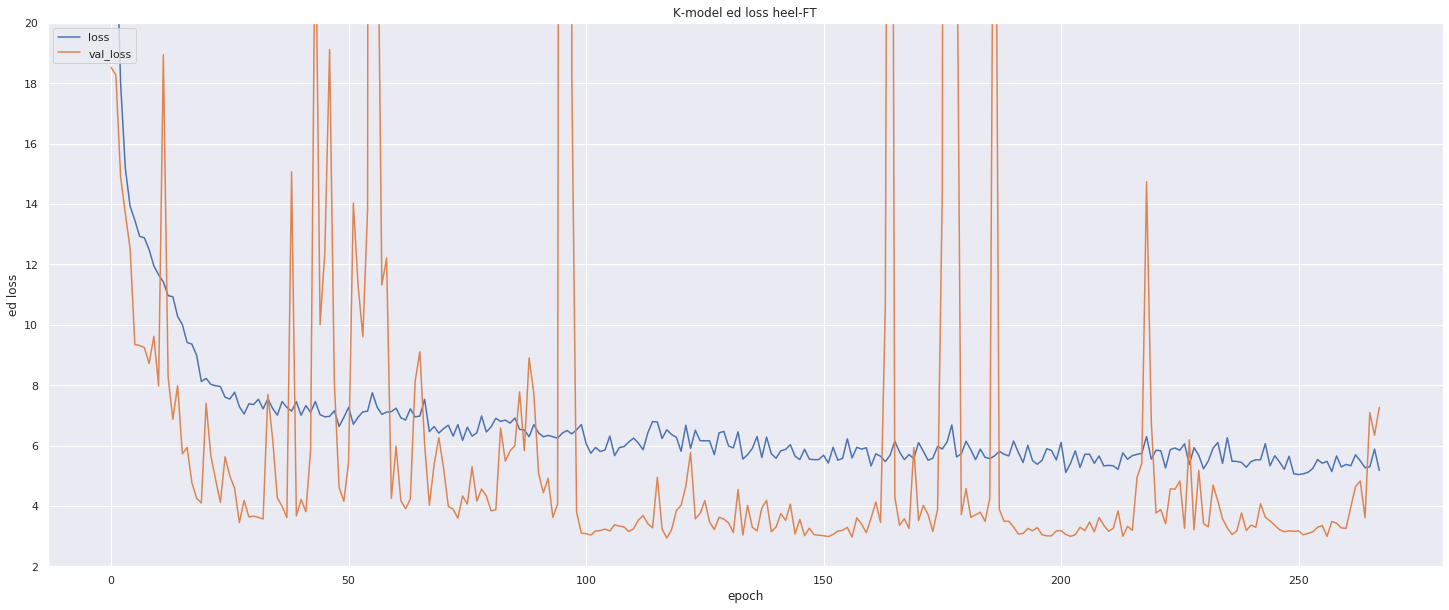

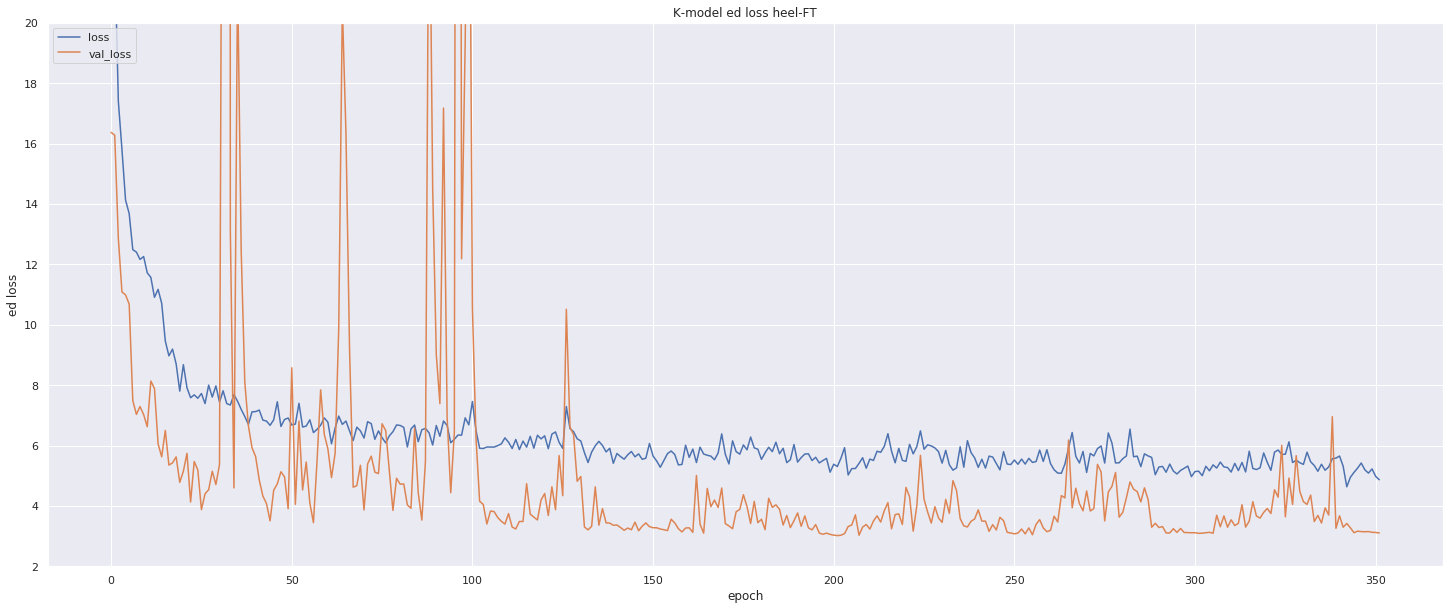

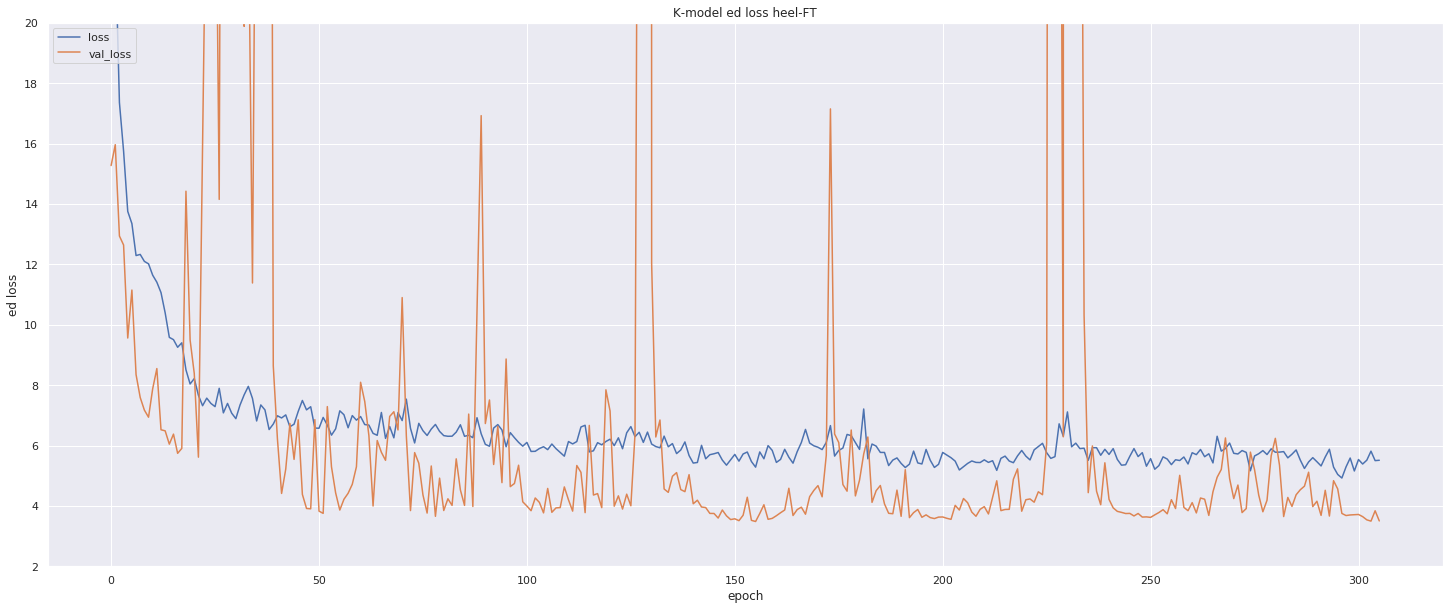

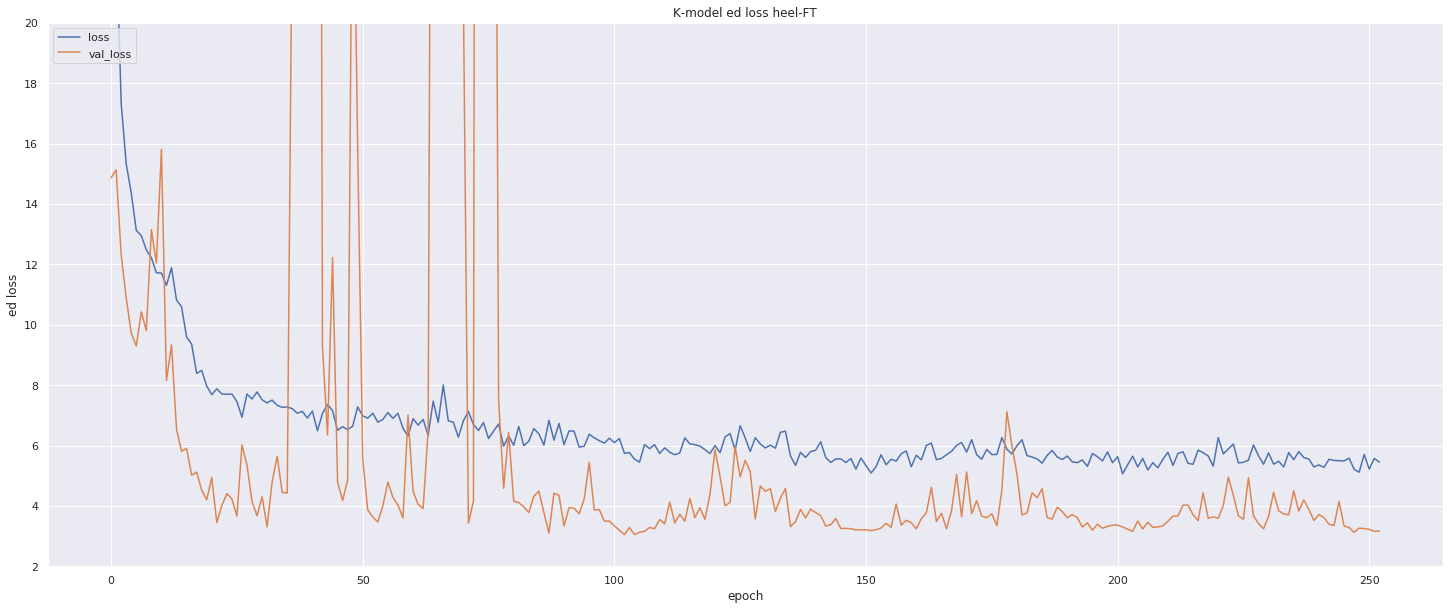

In [109]:
# Single plot loss heel-FT

for k in range(KFlodNum):
    plt.figure(figsize=(25, 10))
    plt.plot(history_heel_finetune[k].history['loss'])
    plt.plot(history_heel_finetune[k].history['val_loss'])
    plt.title('K-model ed loss heel-FT')
    plt.ylabel('ed loss'), plt.ylim(2, 20)# for too large loss
    plt.xlabel('epoch')
    plt.legend(['loss', 'val_loss'], loc='upper left') 
    # plt.show()

    # save plot : comment plo.show in jupyter notebook.
    def get_valloss(his_v_l):   
        return np.min(his_v_l), np.argmin(his_v_l)

    vl, ep = get_valloss(history_heel_finetune[k].history['val_loss'])
    plt.savefig(f'{log_dir_name}/{log_dir_name}_heel_K{k}_FT_clr_ed{round(vl,4)}@{ep}.png', bbox_inches = 'tight')

### Ploting your model

In [110]:
# model_toe.summary()

In [111]:
# # show after modl.fit
# model_toe.metrics_names

In [112]:
# # check metrics the model have.
# history_toe.history.keys()

In [113]:
# tf.keras.utils.plot_model(model_toe, show_shapes=True)

In [114]:
# from tensorflow.keras.utils import plot_model
# plot_model(model_toe, to_file='model_toe_conv_layer_blocks.png', show_shapes=True)
# from IPython.display import Image
# Image(filename='model_toe_conv_layer_blocks.png') 

## show pp pred

* we can switch toe/hell by comment it

### EFN Toe

In [115]:
# it_valid_ds_pre_toe_s = iter(valid_ds_pre_toe_s)
# # it_valid_ds_pre_heel_s = iter(valid_ds_pre_heel_s)

In [116]:
# %%time

# # image_batch, label_batch = next(valid_ds_pre_toe_s)

# image_batch, label_batch = next(it_valid_ds_pre_toe_s)
# # image_batch, label_batch = next(it_valid_ds_pre_heel_s)


# pred = model_toe.predict_on_batch(image_batch) #predictions
# # pred = model.predict_on_batch(image_batch) #Simple 2D CNN model predictions

# plt.figure(figsize=(20, 20))
# for i in range(64):
#     ax = plt.subplot(8, 8, i + 1)
#     plt.imshow(image_batch[i])
#     plt.title(label_batch[i].numpy())
#     plt.axis("off")
    
#     # note: y_offset_toe for ds image
    
#     #ground truth
#     plt.plot(label_batch[i].numpy()[0], label_batch[i].numpy()[1], 'r+', markersize=15, mew=2)

#     #pred
#     plt.plot(pred[i][0], pred[i][1], 'k+', markersize=15, mew=2)

In [117]:
# #test_ds一次做完即可不用分batch
# neg = label_batch - pred
# neg[:5]

In [118]:
# np.abs(neg)[:5]

In [119]:
# neg_abs = np.abs(neg)
# neg_abs.mean(axis=0)#所有x 所有y個別平均  neg.mean(axis=0)#所有x 所有y個別平均

#### ED 2D

In [120]:
# # y_pred = neg_abs.mean(axis=0)
# ed_metric_2d([0,0], [neg_abs.mean(axis=0)]).numpy()

### EFN Heel

In [121]:
# # it_valid_ds_pre_toe_s = iter(valid_ds_pre_toe_s)
# it_valid_ds_pre_heel_s = iter(valid_ds_pre_heel_s)

In [122]:
# %%time

# # image_batch, label_batch = next(valid_ds_pre_toe_s)

# # image_batch, label_batch = next(it_valid_ds_pre_toe_s)
# image_batch, label_batch = next(it_valid_ds_pre_heel_s)


# pred = model_heel.predict_on_batch(image_batch) #predictions
# # pred = model.predict_on_batch(image_batch) #Simple 2D CNN model predictions

# plt.figure(figsize=(20, 20))
# for i in range(64):
#     ax = plt.subplot(8, 8, i + 1)
#     plt.imshow(image_batch[i])
#     plt.title(label_batch[i].numpy())
#     plt.axis("off")
    
#     # note: y_offset_toe for ds image
    
#     #ground truth
#     plt.plot(label_batch[i].numpy()[0], label_batch[i].numpy()[1], 'r+', markersize=15, mew=2)

#     #pred
#     plt.plot(pred[i][0], pred[i][1], 'k+', markersize=15, mew=2)

In [123]:
# pred[:5]

In [124]:
# label_batch[:5]

In [125]:
# #test_ds一次做完即可不用分batch
# neg = label_batch - pred
# neg[:10]

In [126]:
# np.abs(neg)[:10]

In [127]:
# neg_abs = np.abs(neg)
# neg_abs.mean(axis=0)#所有x 所有y個別平均  neg.mean(axis=0)#所有x 所有y個別平均

#### ED 2d

In [128]:
# # y_pred = neg_abs.mean(axis=0)
# ed_metric_2d([0,0], [neg_abs.mean(axis=0)]).numpy()

# Merg Toe/Heel model and predict the Test data at once

### Create TEST DS

In [129]:
# ts = 'test_submission.csv'
# df_ts = pd.read_csv(ts)
# df_ts.head(5)

In [130]:
# df_ts['images']

In [131]:
# # from dataframe
# list_ds_test = tf.data.Dataset.from_tensor_slices(df_ts['images'])


In [132]:
# len(list_ds_test)#.shape() #take(1)

In [133]:
# # check The type specification of an element of this dataset.
# list_ds_test.element_spec

In [134]:
# for f in list_ds_test.take(5):
#     print(f'take test sample: {f}')

### TEST DS: Process TEST path to image tensor

In [135]:
# ## TEST-DS: re-used from train/val-ds

# im_test = 'test_images/'

# '''
# def get_label(file_path):
#     # convert the path to a list of path components
#     parts = tf.strings.split(file_path, os.path.sep)
#     # The second to last is the class-directory
#     boolen = parts[-2] == class_names
#     #one_hot_num = np.array(boolen, dtype=np.int) not works should use tf.x repalced.
#     one_hot_num = tf.dtypes.cast(boolen, tf.int64)
#     one_num = tf.argmax(one_hot_num)
#     print('one_num:', one_num)
#     # Integer encode the label
#     return one_num

# def decode_img(img):
#     # convert the compressed string to a 3D uint8 tensor
#     img = tf.io.decode_jpeg(img, channels=3)
#     # resize the image to the desired size
# #     return tf.image.resize(img, [img_height, img_width])# augment 已經resize過一次了 但這邊不先做會比較慢
#     return tf.cast(tf.image.resize(img, [img_height, img_width]), tf.uint8)# 避免float over at augment
# '''

# #
# # map list to ds, Toe part.
# #

# def decode_crop_png_toe_test(img):
#     # convert the compressed string to a 3D uint8 tensor
#     img = tf.io.decode_png(img, channels=3)
#     # crop the toe from top-left corner [image, offset_height y1, offset_width x1, target_height, target_width]
#     y1=y_offset_toe;    x1=0;    h=img_height;    w=img_width # not the pp location
#     img = tf.image.crop_to_bounding_box(img, int(y1), int(x1), h, w)
#     #img = tf.image.crop_to_bounding_box(img, int(y1), int(x1), int(y2)-int(y1), int(x2)-int(x1))
#     # resize the image to the desired size
#     return img

# def process_path_toe_test(file_name):
#     file_path = im_test + file_name
#     #label = get_label(file_path)
#     # load the raw data from the file as a string
#     img = tf.io.read_file(file_path)#can read the byte string paths b'image_0001.png'
#     img = decode_crop_png_toe_test(img)
#     return img, file_name

# #
# # map list to ds, Heel part.
# #

# def decode_crop_png_heel_test(img):
#     # convert the compressed string to a 3D uint8 tensor
#     img = tf.io.decode_png(img, channels=3)
#     # crop the toe from top-left corner [image, offset_height y1, offset_width x1, target_height, target_width]
#     y2=y_offset_heel;    x2=0;    h=img_height;    w=img_width # not the pp location
#     img = tf.image.crop_to_bounding_box(img, int(y2), int(x2), h, w)
#     #img = tf.image.crop_to_bounding_box(img, int(y1), int(x1), int(y2)-int(y1), int(x2)-int(x1))
#     # resize the image to the desired size
#     return img

# def process_path_heel_test(file_name):
#     file_path = im_test + file_name
#     #label = get_label(file_path)
#     # load the raw data from the file as a string
#     img = tf.io.read_file(file_path)#can read the byte string paths b'image_0001.png'
#     img = decode_crop_png_heel_test(img)
#     return img, file_name


# #
# # test how to put parameters to map
# #

# def t_ds_map(file_path,x1,y1,x2,y2):
# #     img = get_img('train/images/' + str(file_path))
# #     print(file_path)
#     return file_path,x1,y1,x2,y2 #img, [x1,y1]
    

In [136]:
# # TEST Toe ds
# test_ds_map_toe = list_ds_test.map(process_path_toe_test, num_parallel_calls=AUTOTUNE)

# # TEST Heel ds
# test_ds_map_heel = list_ds_test.map(process_path_heel_test, num_parallel_calls=AUTOTUNE)

In [137]:
# for img, file_name in test_ds_map_toe.take(5):
#     print(f'take sample: {img.shape} {file_name}')
    
# # print('f', f.dtype)
# # print('xy', xy.dtype)

### prepare TEST_ds_pre

In [138]:
# def configure_for_performance_cache_test(ds, cache=True):

#     if cache:
#         ds = ds.cache()
#         print("Check cache in memory:Y", cache)
#     else:
#         print("Check cache in memory:N", cache)
        
# #     if augment:
# # #         ds = ds.map(data_augment, num_parallel_calls=AUTOTUNE)
# #         ds = ds.map(AA, num_parallel_calls=AUTOTUNE)
# # #         ds = ds.map(RA, num_parallel_calls=AUTOTUNE)
# #         print("Check augment :Y", augment)
# #     else:
# #         print("Check augment :N", augment)
    
# #     #ds = ds.repeat()#TODO:2020-12-14: test
# #     ds = ds.shuffle(buffer_size=MULTI_BATCH_SIZE*2) # (buffer_size=MULTI_BATCH_SIZE*5) 6sec,buffer_size=1000 take few sec. or buffer_size=image_count <- take too long # each take ds take 30~45 sec, TODO!!
# #     ds = ds.shuffle(len(list_ds), reshuffle_each_iteration=False) #todo: move to ds_pre. see https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle
#     ds = ds.batch(1000)# 1k for foot test images #MULTI_BATCH_SIZE for multi-GPUs
#     ds = ds.prefetch(buffer_size=AUTOTUNE) #buffer_size=AUTOTUNE seem no speed improve
    
#     return ds


In [139]:
# """
# Prepare the ds properties (cache, augment, bs, shuffle, prefetch, etc.) for better performance.
# """
# # TEST Toe ds_pre
# test_ds_pre_toe = configure_for_performance_cache_test(test_ds_map_toe)

# # TEST Heel ds_pre
# test_ds_pre_heel = configure_for_performance_cache_test(test_ds_map_heel)

# Load Best-K-models

In [140]:
# # if K-models are in last time frame
# # best_model_name = get_best_model_name(th, K=str(k))

# predictions_toe = []
# predictions_heel = []

# for k in range(KFlodNum):
#     print(f'K:{k}')
#     best_model_toe_name = get_best_model_name('toe', K=str(k))
#     best_model_heel_name = get_best_model_name('heel', K=str(k))

# # # if models are in last time frame
# # best_model_toe_name = get_best_model_name('toe')
# # best_model_heel_name = get_best_model_name('heel')

# # # if toe/heel are in different time frame
# # best_model_toe_name = '20210118-212454/toe_EfficientNetB0_bs64_w120_best_val_loss.h5'#6.3318 @e393
# # best_model_heel_name = '20210122-084854/heel_EfficientNetB0_bs64_w120_best_val_loss.h5'#3.27979@152




#     print(best_model_toe_name)
#     print(best_model_heel_name)
#     # log_dir_name + '/' + 'leaf-2020-12-01-EfficientNetB7_top-layer50_lr_lrfn_val-acc.8352_wh512_e37.h5'

#     best_model_toe = tf.keras.models.load_model(best_model_toe_name,compile=False)
#     best_model_heel = tf.keras.models.load_model(best_model_heel_name,compile=False)
    
#     best_model_toe.compile(optimizer = tf.keras.optimizers.Adam(),#RMSprop , Adam
#                 loss=ed_metric_2d_mean)#, ed_loss ed_metric_2d ed_metric_2d_mean            
#                 #metrics=['mae', 'accuracy'])
#     best_model_heel.compile(optimizer = tf.keras.optimizers.Adam(),#RMSprop , Adam
#                 loss=ed_metric_2d_mean)#, ed_loss ed_metric_2d ed_metric_2d_mean            
#                 #metrics=['mae', 'accuracy'])
        
        
#     pred_toe = best_model_toe.predict(test_ds_pre_toe)
#     pred_toe[:,1] = pred_toe[:,1] + y_offset_toe
#     predictions_toe.append(pred_toe)
    
#     pred_heel = best_model_heel.predict(test_ds_pre_heel)
#     pred_heel[:,1] = pred_heel[:,1] + y_offset_heel
#     predictions_heel.append(pred_heel)
    
    

In [141]:
# len(predictions_toe[0])

In [142]:
# # make sure we got the k-pred as k models.
# for i, _ in enumerate(predictions_toe):
#     print(i)

In [143]:
# np.shape(predictions_toe)

In [144]:
# predictions_toe[0]

In [145]:
# predictions_toe[1]

In [146]:
# predictions_heel[0]

In [147]:
# predictions_heel[1]

In [148]:
# # mean the k-predictions
# k_predictions_toe = np.mean(predictions_toe, axis=0)
# k_predictions_toe

In [149]:
# np.shape(k_predictions_toe)

In [150]:
# # mean the k-predictions
# k_predictions_heel = np.mean(predictions_heel, axis=0)
# k_predictions_heel

### Merge toe/hell pred

In [151]:
# predictions_th = np.append(k_predictions_toe, k_predictions_heel, axis=1)#左右接
# predictions_th.shape

In [152]:
# images_name = np.expand_dims(df_ts['images'], axis=1)
# images_name.shape

In [153]:
# predictions_merge = np.append(images_name, predictions_th, axis=1)#左右接
# predictions_merge.shape

In [154]:
# df_submission = pd.DataFrame(predictions_merge)
# df_submission.columns = ['images','x1','y1','x2','y2']

In [155]:
# submi_name = CSVNAME + '.' + log_dir_name +'.csv'

# df_submission.to_csv(submi_name, index=False)
# print('Save {} as submission CSV.'.format(submi_name))

In [156]:
# df_submission.head()

In [157]:
#ED sum
def get_valloss(his_v_l):  
    return np.min(his_v_l), np.argmin(his_v_l)

# t_vl = []
h_vl = []
for k in range(KFlodNum):
    print(f'K:{k}')
#     t_v, _ = get_valloss(history_toe_finetune[k].history['val_loss'])
    h_v, _ = get_valloss(history_heel_finetune[k].history['val_loss'])
    
#     t_vl.append(t_v)
    h_vl.append(h_v)

# t_vl = np.mean(t_vl, axis=0)
h_vl = np.mean(h_vl, axis=0)
# print(f'{round(t_vl,5)} + {round(h_vl,5)} = {round(t_vl + h_vl,5)}')
print(f'Heel ED = {round(h_vl,5)}')

K:0
K:1
K:2
K:3
K:4
K:5
K:6
K:7
K:8
K:9
K:10
K:11
K:12
K:13
K:14
K:15
K:16
K:17
K:18
K:19
Heel ED = 3.12695


In [158]:
# K134520210224-114845.csv
# 5.63922 + 3.34466 = 8.98389 LB:8.4890610

In [159]:
# t_vl

In [160]:
h_vl

3.1269500255584717

In [161]:
t_timer.toc() #Time elapsed since t.tic()

Elapsed time is 57130.925502 seconds.


### compile the model separately afterwards. to load model with custom loss function

* https://github.com/tensorflow/tensorflow/issues/32348

In [162]:
# best_model_toe.compile(optimizer = tf.keras.optimizers.Adam(),#RMSprop , Adam
#                 loss=ed_metric_2d_mean)#, ed_loss ed_metric_2d ed_metric_2d_mean            
#                 #metrics=['mae', 'accuracy'])
# best_model_heel.compile(optimizer = tf.keras.optimizers.Adam(),#RMSprop , Adam
#                 loss=ed_metric_2d_mean)#, ed_loss ed_metric_2d ed_metric_2d_mean            
#                 #metrics=['mae', 'accuracy'])

# best_model_toe.compile(optimizer = tf.keras.optimizers.Adam(),#RMSprop , Adam
#                 loss=tf.keras.losses.MeanSquaredError())#, ed_loss ed_metric_2d ed_metric_2d_mean            
#                 #metrics=['mae', 'accuracy'])
# best_model_heel.compile(optimizer = tf.keras.optimizers.Adam(),#RMSprop , Adam
#                 loss=tf.keras.losses.MeanSquaredError())#, ed_loss ed_metric_2d ed_metric_2d_mean            
#                 #metrics=['mae', 'accuracy'])

    

In [163]:
# %%time
# # inference all test_ds once
# predictions_toe = best_model_toe.predict(test_ds_pre_toe)
# predictions_toe.shape

### Offset Toe

In [164]:
# predictions_toe[:,1] = predictions_toe[:,1] + y_offset_toe

# # for [0,1]
# # predictions_toe[:,0] = predictions_toe[:,0]*120
# # predictions_toe[:,1] = predictions_toe[:,1]*120 + y_offset_toe

# # # for [-1,1]
# # # for re-scale back xy 
# # # return img, [(x1-60)/60,((y1-y_offset_toe)-60)/60]#normalized [-1,1] 
# # # return img, [(x2-60)/60,((y2-y_offset_heel)-60)/60]#normalized [-1,1] 
# # predictions_toe[:,0] = (predictions_toe[:,0]*60)+60
# # predictions_toe[:,1] = (predictions_toe[:,1]*60)+60 + y_offset_toe

# predictions_toe

In [165]:
# %%time
# # inference all test_ds once
# predictions_heel = best_model_heel.predict(test_ds_pre_heel)
# predictions_heel.shape

### Offset Heel

In [166]:
# predictions_heel[:,1] = predictions_heel[:,1] + y_offset_heel

# # for [0,1]
# # predictions_heel[:,0] = predictions_heel[:,0]*120
# # predictions_heel[:,1] = predictions_heel[:,1]*120 + y_offset_heel

# # # for [-1,1]
# # predictions_heel[:,0] = (predictions_heel[:,0]*60)+60
# # predictions_heel[:,1] = (predictions_heel[:,1]*60)+60 + y_offset_heel

# predictions_heel

### Merge toe/hell pred

In [167]:
# predictions_th = np.append(predictions_toe, predictions_heel, axis=1)#左右接
# predictions_th.shape

In [168]:
# images_name = np.expand_dims(df_ts['images'], axis=1)
# images_name.shape

In [169]:
# predictions_merge = np.append(images_name, predictions_th, axis=1)#左右接
# predictions_merge.shape

In [170]:
# df_submission = pd.DataFrame(predictions_merge)
# df_submission.columns = ['images','x1','y1','x2','y2']

In [171]:
# submi_name = '0000_ft_' + log_dir_name +'.csv'
# # submi_name = 'Bth_clr3_2690_XYnorm[0-1]_' + log_dir_name +'.csv'
# df_submission.to_csv(submi_name, index=False)
# print('Save {} as submission CSV.'.format(submi_name))

In [172]:
#Bth_clr3_2690_ed_findtune_20210202-141718.csv

#toe.9.9/heel.4.4 109 trainable LB:9.3411759 比heel保持top-20略高0.04 (9.3084957)

In [173]:
# df_submission.head()

In [174]:
# #ED sum
# def get_valloss(his_v_l):  
#     return np.min(his_v_l), np.argmin(his_v_l)

# t_vl, _ = get_valloss(history_toe_finetune.history['val_loss'])
# h_vl, _ = get_valloss(history_heel_finetune.history['val_loss'])

# print(f'{round(t_vl,5)} + {round(h_vl,5)} = {round(t_vl + h_vl,5)}')

In [175]:
#

## save model

In [176]:

# best_model_name = './cop_' + model_name + '_bs' + str(BATCH_SIZE) + '_w' + str(img_width) + '_e' + str(ep_num) + '_' + datetime.now().strftime("%Y%m%d-%H%M%S") + '_.h5'
# # model.save(best_model_name)
# print("Save model: ", best_model_name)

## Reference

multi output model:
https://navoshta.com/end-to-end-deep-learning/

